In [1]:
import pandas as pd
import numpy as np
from astropy.cosmology import Planck13
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

import disperse

In [2]:
cosmo = Planck13
H0 = cosmo.H0.value
Om = cosmo.Om0
Ol = 0.69288
Ok = 0.0
print(f'H0 = {cosmo.H0.value}')
print(f'Om = {cosmo.Om0}')
print(f'Ol = {0.69288}')

H0 = 67.77
Om = 0.30712
Ol = 0.69288


In [3]:
gal_RA_int = (140, 260)
gal_DEC_int = (-10, 30)
gal_Z_int = (0, 1.0)

In [4]:
galaxies = pd.read_csv('SDSS/SDSS_DR16.csv')
galaxies = galaxies[galaxies['class'] == 'GALAXY']
galaxies = galaxies[(gal_RA_int[0] <= galaxies['ra']) & (galaxies['ra'] <= gal_RA_int[1])]
galaxies = galaxies[(gal_DEC_int[0] <= galaxies['dec']) & (galaxies['dec'] <= gal_DEC_int[1])]
galaxies = galaxies[(gal_Z_int[0] < galaxies['z']) & (galaxies['z'] <= gal_Z_int[1])]
galaxies = galaxies[['ra', 'dec', 'z']]
galaxies.columns = ['RA', 'DEC', 'Z']
galaxies.drop_duplicates(subset=['RA', 'DEC', 'Z'])
galaxies.reset_index(drop=True, inplace=True)
galaxies

,RA,DEC,Z
0,146.71421,-1.041304,0.021275
1,146.71421,-1.041304,0.021222
2,146.91945,-0.990492,0.213925
3,146.74413,-0.652191,0.203783
4,146.85983,-0.808902,0.126554
...,...,...,...
931855,146.13969,26.500868,0.903536
931856,146.20911,26.557960,0.628224
931857,146.09398,26.524402,0.845268
931858,146.32252,26.549261,0.058894


In [5]:
cl_RA_int = (160, 240)
cl_DEC_int = (0, 20)
cl_Z_int = (0, 1.0)

In [6]:
dat = Table.read('DR5_cluster-catalog_v1.1.fits', format='fits')
clusters = dat[['RADeg', 'decDeg', 'redshift', 'redshiftType', 'M500c']].to_pandas()
clusters = clusters[clusters['redshiftType'] == b'spec']
clusters = clusters[['RADeg', 'decDeg', 'redshift', 'M500c']]
clusters.columns = ['RA', 'DEC', 'Z', 'M']
clusters = clusters[(cl_RA_int[0] <= clusters['RA']) & (clusters['RA'] <= cl_RA_int[1])]
clusters = clusters[(cl_DEC_int[0] <= clusters['DEC']) & (clusters['DEC'] <= cl_DEC_int[1])]
clusters = clusters[(cl_Z_int[0] < clusters['Z']) & (clusters['Z'] <= cl_Z_int[1])]
clusters = clusters[['RA', 'DEC', 'Z', 'M']]
clusters.columns = ['RA', 'DEC', 'Z', 'M']
clusters.drop_duplicates(subset=['RA', 'DEC', 'Z', 'M'])
clusters.reset_index(drop=True, inplace=True)
clusters = clusters.assign(R=[0] * clusters.shape[0])
clusters

,RA,DEC,Z,M,R
0,160.265704,10.675110,0.789868,4.328044,0
1,160.320666,19.972684,0.413140,2.687590,0
2,160.659186,17.588787,0.442822,2.766446,0
3,162.055869,9.598745,0.586733,2.237799,0
4,162.537472,5.479127,0.417636,2.030756,0
...,...,...,...,...,...
514,238.438790,3.855719,0.554680,1.904794,0
515,238.755974,18.678286,0.358603,2.810605,0
516,239.523481,13.723614,0.376000,1.444235,0
517,239.545873,13.625000,0.237012,1.263648,0


In [7]:
clusters['Z'].max()

0.975

In [8]:
DPS = disperse.Disperse3D(
    galaxies, '_disperse_03/bin/',
    H0, Om, Ol, Ok,
    clusters=clusters
)

In [9]:
DPS.count_cart_coords()

In [10]:
SIGMA = 5.0
SMOOTH = 1
BOARD = 'smooth'
ANGLE = 30

In [11]:
sigmas = [
         0.2, 0.4, 0.6, 0.8,
    1.0, 1.2, 1.4, 1.6, 1.8,
    2.0, 2.2, 2.4, 2.6, 2.8,
    3.0, 3.2, 3.4, 3.6, 3.8, 
    4.0, 4.2, 4.4, 4.6, 4.8, 
    5.0, 5.2, 5.4, 5.6, 5.8, 
    6.0, 6.2, 6.4, 6.6, 6.8,
    7.0, 7.2, 7.4, 7.6, 7.8,
    8.0, 8.2, 8.4, 8.6, 8.8,
    9.0, 9.2, 9.4, 9.6, 9.8,
    10.0, 10.2, 10.4, 10.6, 10.8,
    11.0, 11.2, 11.4, 11.6, 11.8,
    12.0, 12.2, 12.4, 12.6, 12.8,
    13.0, 13.2, 13.4, 13.6, 13.8,
    14.0
]

In [12]:
len(sigmas)

70

In [13]:
# for sigma in sigmas:
#     SIGMA = sigma
#     print('### ', SIGMA)
#     DPS.apply_disperse(SIGMA, SMOOTH, BOARD, ANGLE)
#     DPS.save(f'ACT_01_dumps/{SIGMA}/')

In [14]:
true_cl_dists = []
false_cl_dists = []
for sigma in tqdm(sigmas):
    DPS = disperse.Disperse3D.read(f'ACT_01_dumps/{sigma}/')
    DPS.gen_random_clusters()
    
    cl_conn, fil_conn, cl_dists \
        = DPS.count_conn([3] * DPS.clusters.shape[0])
    true_cl_dists.append(np.array(cl_dists)[None,:])
    
    cl_conn, fil_conn, cl_dists \
        = DPS.count_conn(
            [3] * DPS.clusters.shape[0], 
            DPS.random_clusters[0]
        )
    false_cl_dists.append(np.array(cl_dists)[None,:])

true_dists = np.concatenate(true_cl_dists, axis=0)
false_dists = np.concatenate(false_cl_dists, axis=0)

  0%|          | 0/70 [00:00<?, ?it/s]

>>> Generate random clusters


100%|██████████| 70/70 [05:01<00:00,  4.30s/it]


In [15]:
true_dists = true_dists.T
false_dists = false_dists.T

In [16]:
true_dists.shape, false_dists.shape

((519, 70), (519, 70))

In [17]:
rads = list(range(1, 61))

In [18]:
true_sigmas = []
false_sigmas = []

for i, rad in enumerate(rads):
    t = np.zeros(clusters.shape[0])
    f = np.zeros(clusters.shape[0])
    for j, sigma in tqdm(enumerate(sigmas)):
        t[true_dists[:,j] <= rad] = sigma
        f[false_dists[:,j] <= rad] = sigma

    true_sigmas.append(t)
    false_sigmas.append(f)
    
true_sigmas = np.array(true_sigmas)
false_sigmas = np.array(false_sigmas)

70it [00:00, 72673.58it/s]
70it [00:00, 62788.98it/s]
70it [00:00, 53518.28it/s]
70it [00:00, 67154.91it/s]
70it [00:00, 60300.12it/s]
70it [00:00, 70986.77it/s]
70it [00:00, 53852.03it/s]
70it [00:00, 58837.93it/s]
70it [00:00, 29534.38it/s]
70it [00:00, 101172.05it/s]
70it [00:00, 53881.68it/s]
70it [00:00, 61103.28it/s]
70it [00:00, 89240.51it/s]
70it [00:00, 88674.50it/s]
70it [00:00, 57209.91it/s]
70it [00:00, 62829.29it/s]
70it [00:00, 62059.03it/s]
70it [00:00, 73713.60it/s]
70it [00:00, 55988.04it/s]
70it [00:00, 61001.72it/s]
70it [00:00, 55386.02it/s]
70it [00:00, 87616.02it/s]
70it [00:00, 66636.70it/s]
70it [00:00, 47074.12it/s]
70it [00:00, 71210.59it/s]
70it [00:00, 69017.70it/s]
70it [00:00, 76939.54it/s]
70it [00:00, 65697.31it/s]
70it [00:00, 70071.90it/s]
70it [00:00, 101172.05it/s]
70it [00:00, 66275.68it/s]
70it [00:00, 84343.95it/s]
70it [00:00, 50743.39it/s]
70it [00:00, 96866.14it/s]
70it [00:00, 90394.48it/s]
70it [00:00, 62494.95it/s]
70it [00:00, 76398.98it/s]

In [19]:
true_sigmas = true_sigmas.T
false_sigmas = false_sigmas.T

In [20]:
true_sigmas.shape, false_sigmas.shape

((519, 60), (519, 60))

In [21]:
np.random.seed(0)
cl_num = 100
cl_idx = np.random.choice(list(range(true_dists.shape[0])), size=cl_num)

Text(0.5, 1.0, 'TRUE and FALSE clusters (cl_num=100)')

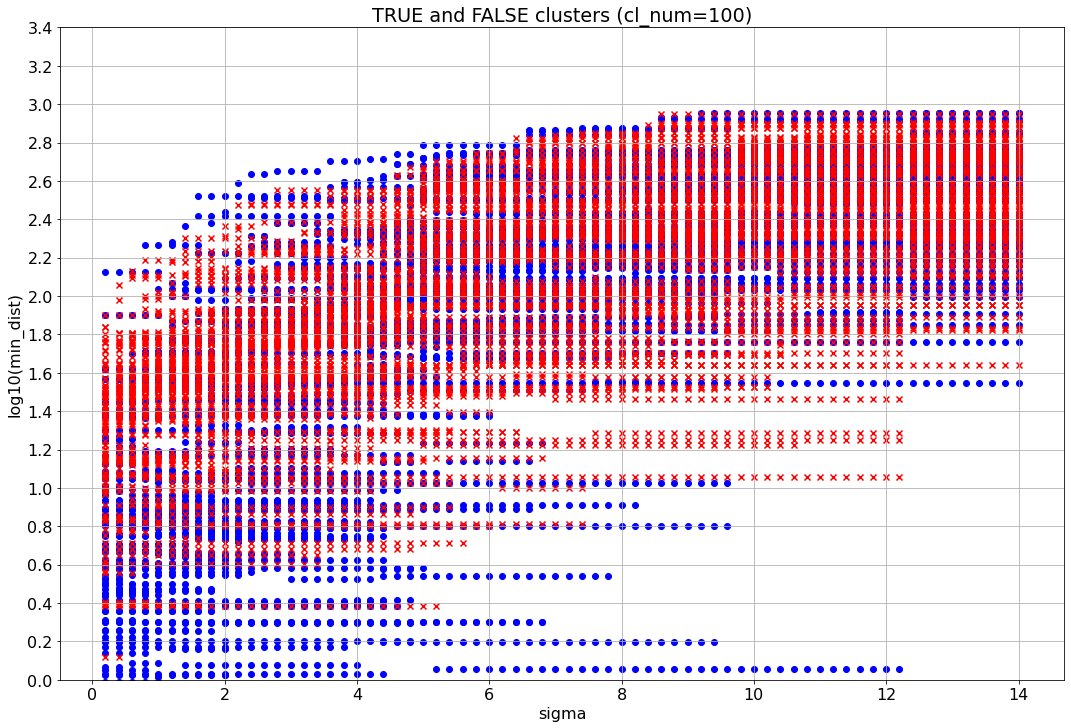

In [22]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))
plt.grid()
plt.yticks(np.arange(0, 3.6, 0.2))
plt.ylim((0, 3.4))

for i in range(cl_num):
    plt.scatter(sigmas, np.log10(true_dists[cl_idx[i]]), c='b', marker='o')
    
for i in range(cl_num):
    plt.scatter(sigmas, np.log10(false_dists[cl_idx[i]]), c ='r', marker='x')
    
plt.xlabel('sigma')
plt.ylabel('log10(min_dist)')
# plt.legend()
plt.title(f'TRUE and FALSE clusters (cl_num={cl_num})')
# plt.savefig(f'TRUE and FALSE clusters (cl_num={cl_num}).jpg')

Text(0.5, 1.0, 'TRUE clusters (cl_num=100)')

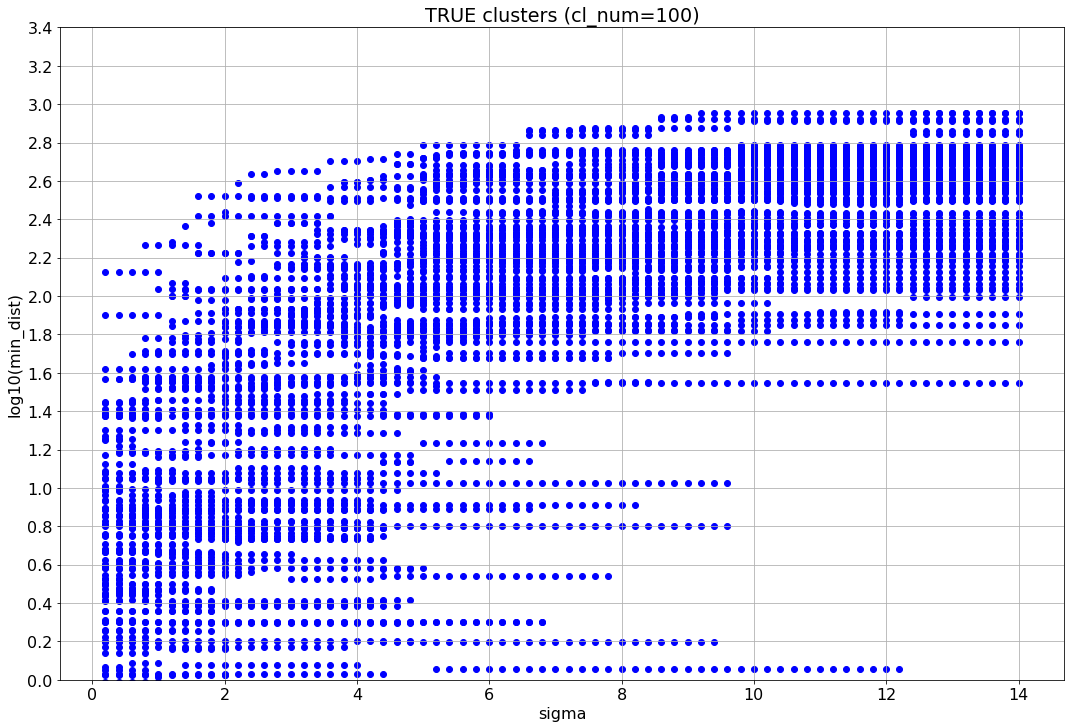

In [23]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))
plt.grid()
plt.yticks(np.arange(0, 3.6, 0.2))
plt.ylim((0, 3.4))

for i in range(cl_num):
    plt.scatter(sigmas, np.log10(true_dists[cl_idx[i]]), c='b', marker='o')
    
plt.xlabel('sigma')
plt.ylabel('log10(min_dist)')
# plt.legend()
plt.title(f'TRUE clusters (cl_num={cl_num})')
# plt.savefig(f'TRUE clusters (cl_num={cl_num}).jpg')

Text(0.5, 1.0, 'FALSE clusters (cl_num=100)')

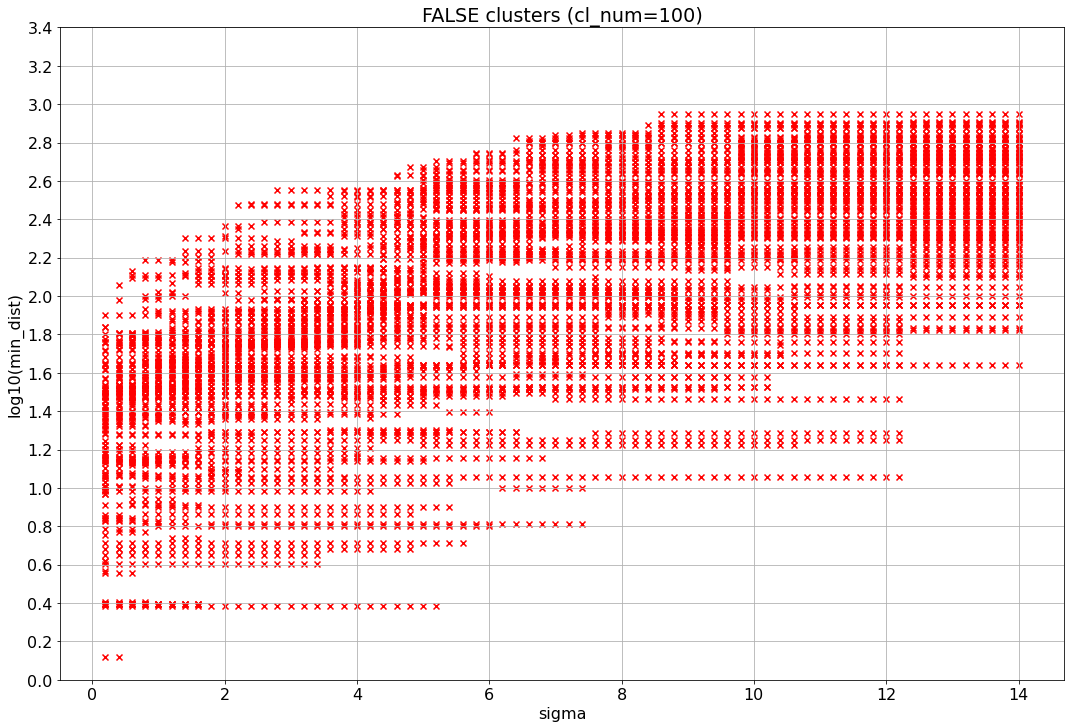

In [24]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))
plt.grid()
plt.yticks(np.arange(0, 3.6, 0.2))
plt.ylim((0, 3.4))

for i in range(cl_num):
    plt.scatter(sigmas, np.log10(false_dists[cl_idx[i]]), c ='r', marker='x')
    
plt.xlabel('sigma')
plt.ylabel('log10(min_dist)')
# plt.legend()
plt.title(f'FALSE clusters (cl_num={cl_num})')
# plt.savefig(f'FALSE clusters (cl_num={cl_num}).jpg')

<ipython-input-25-d5086eb36383>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(18, 12))


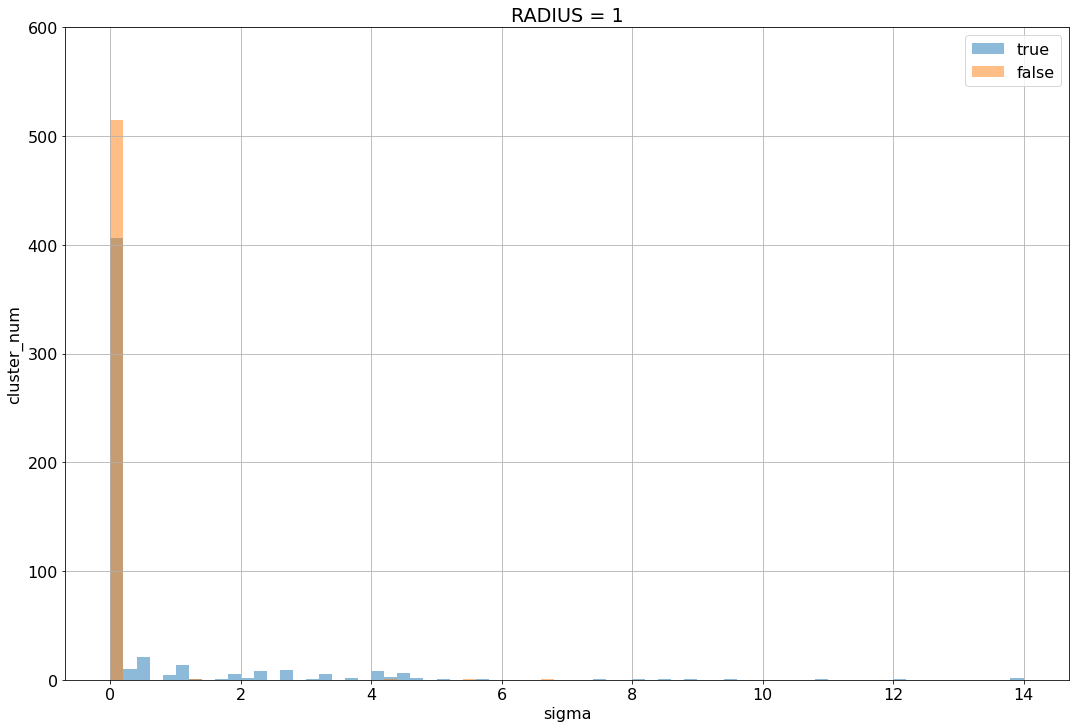

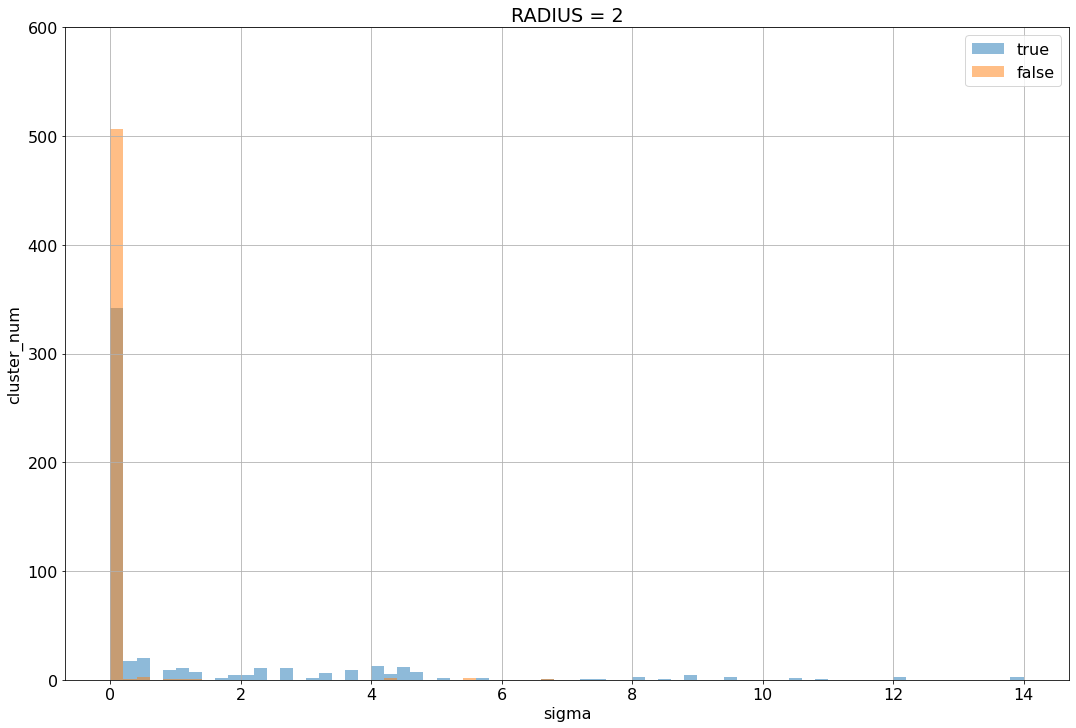

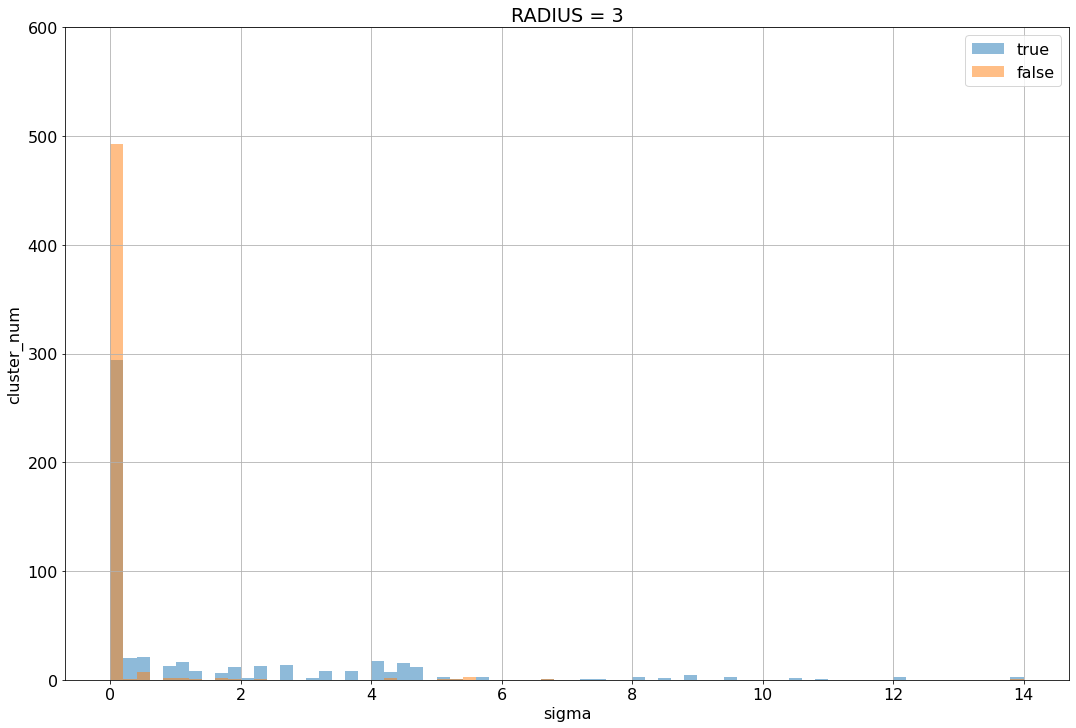

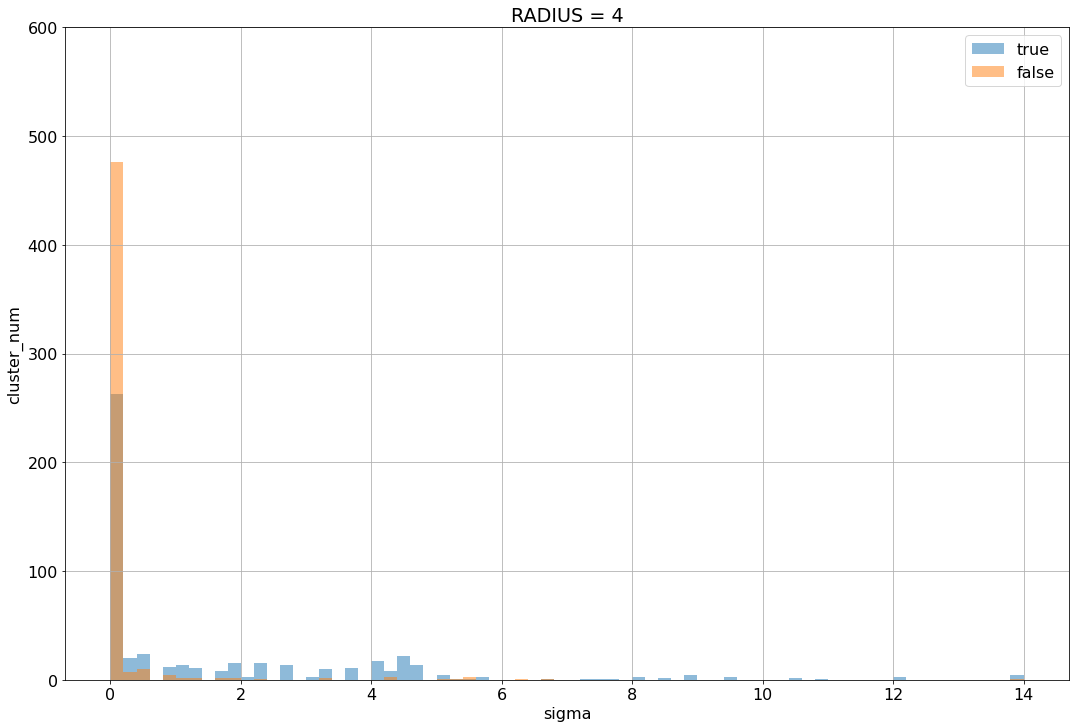

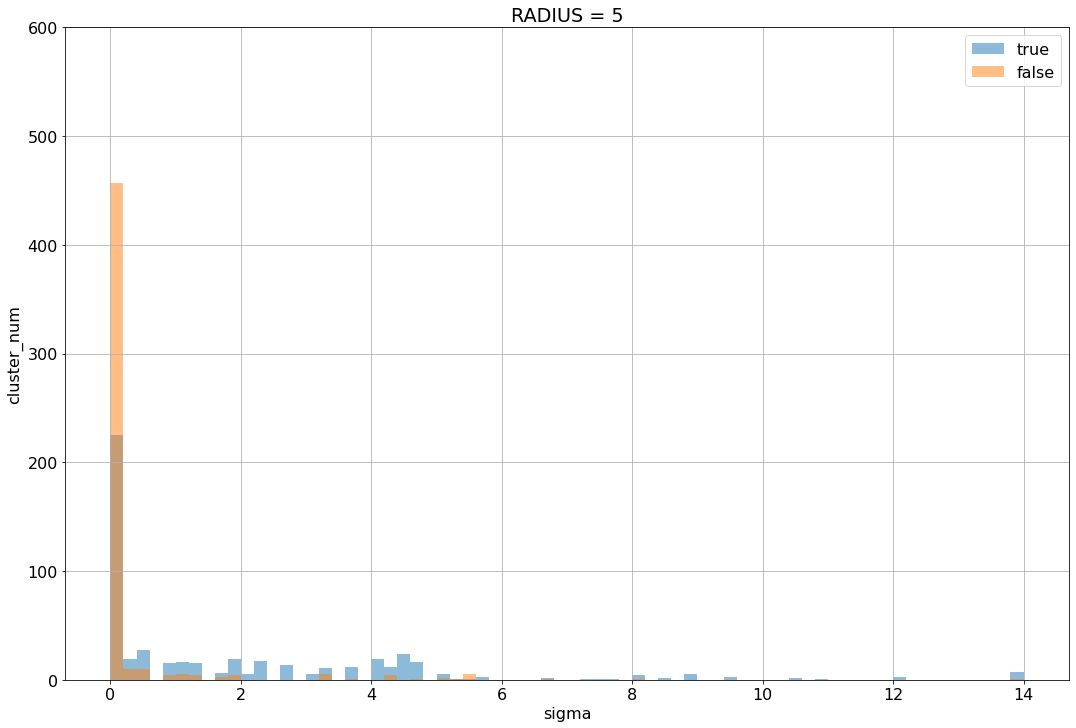

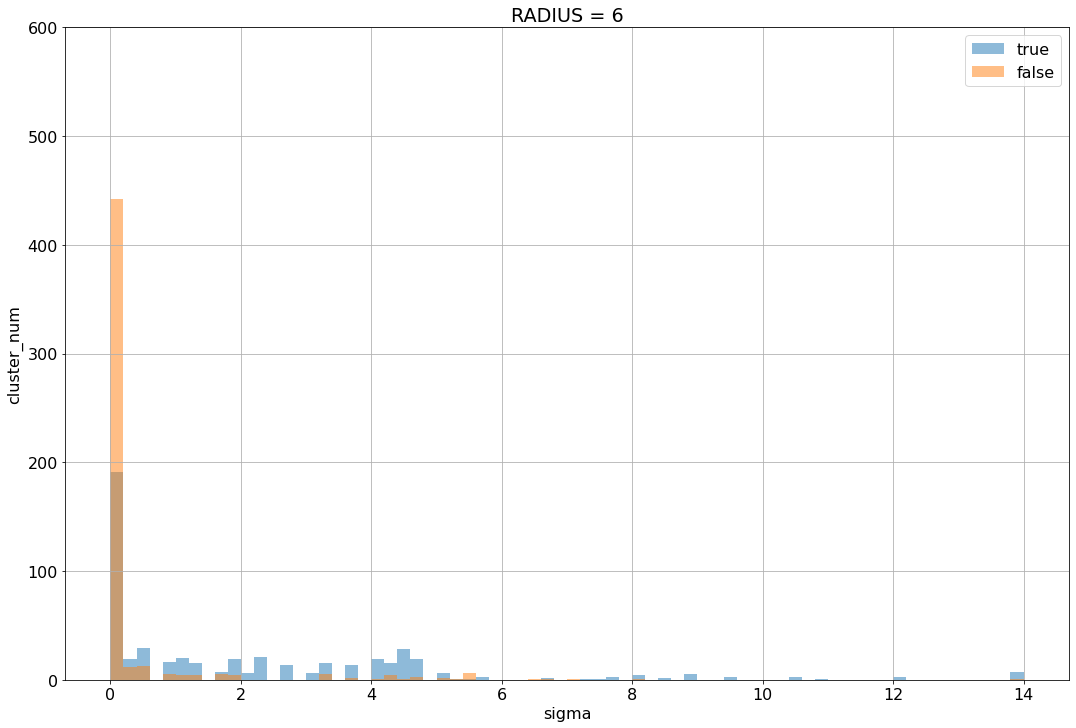

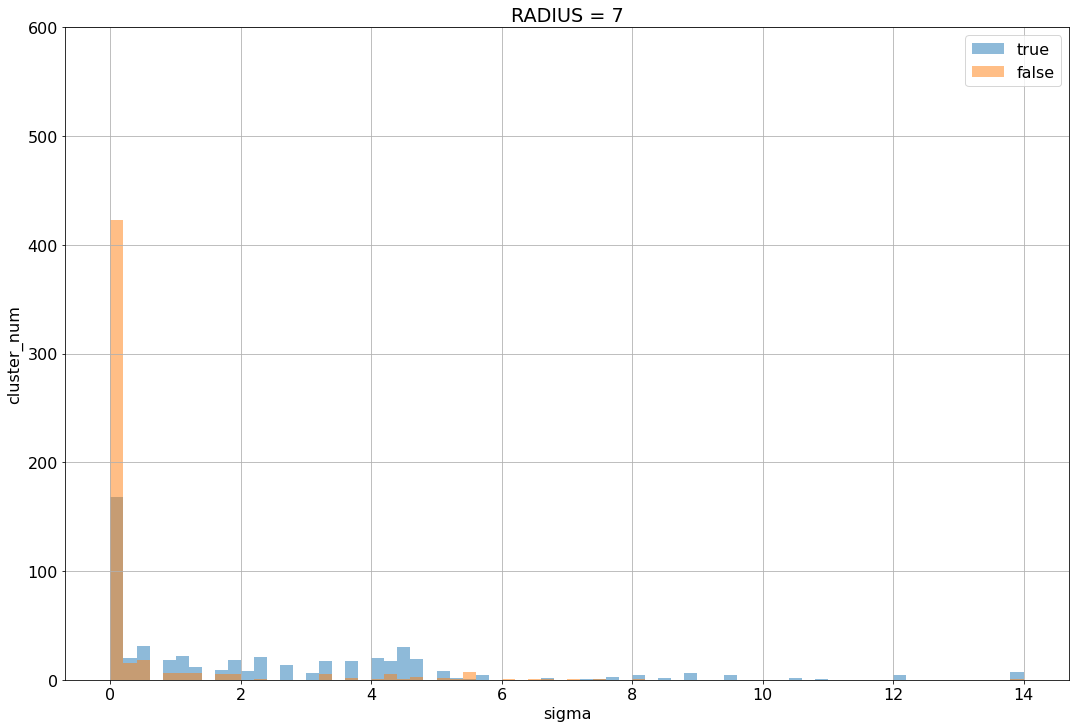

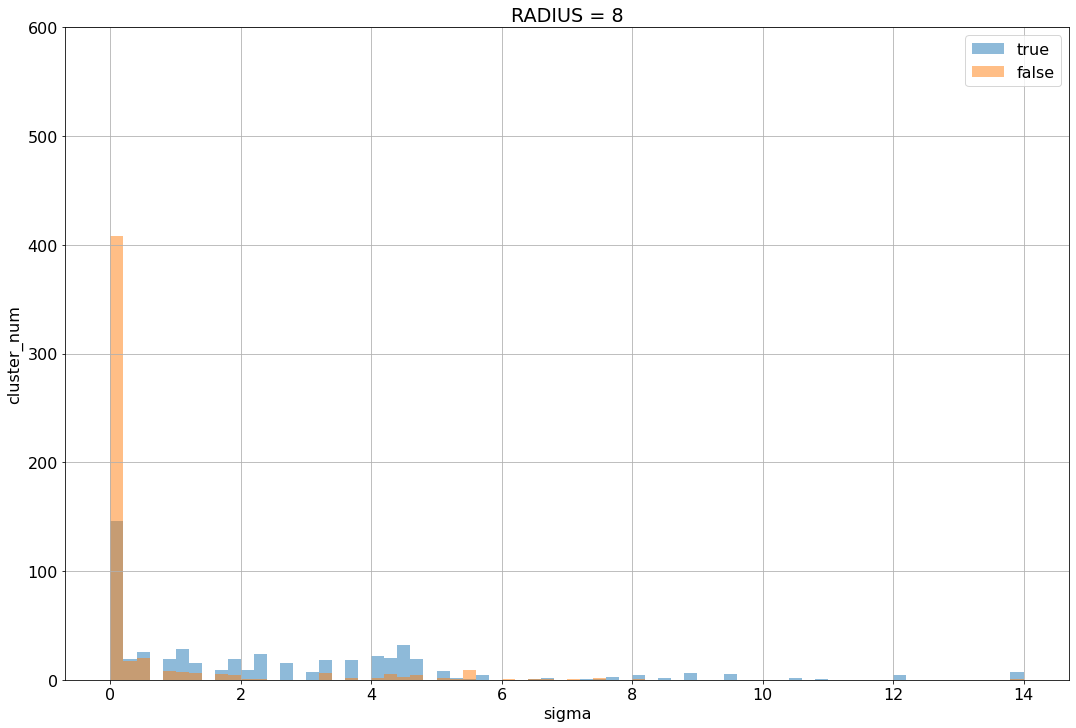

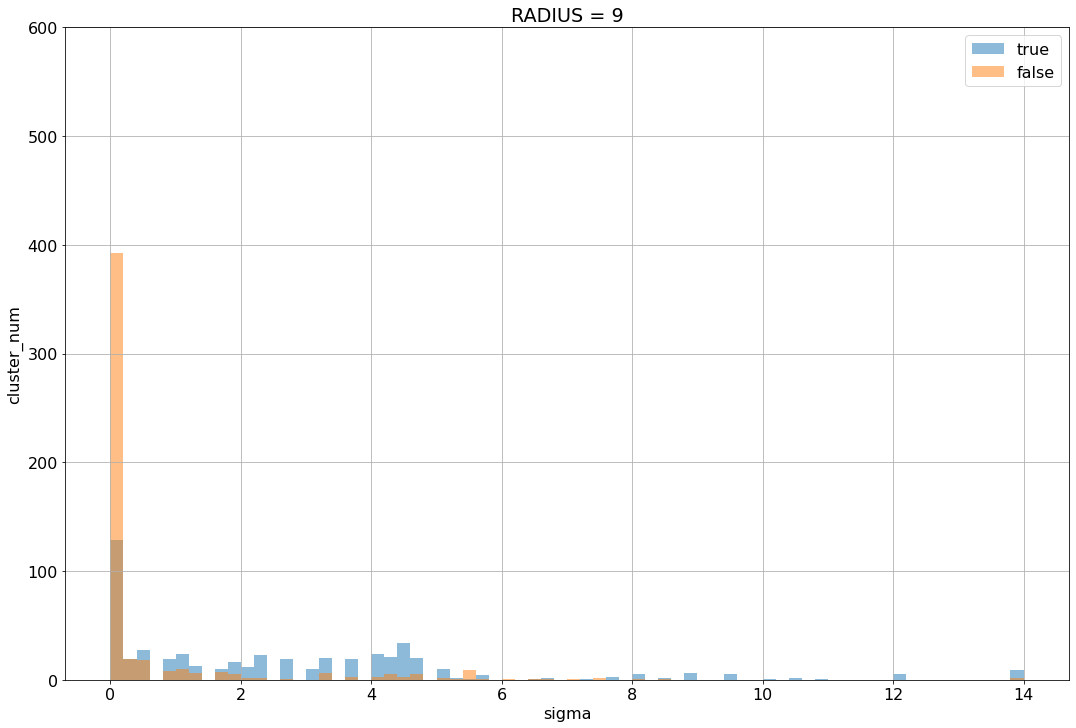

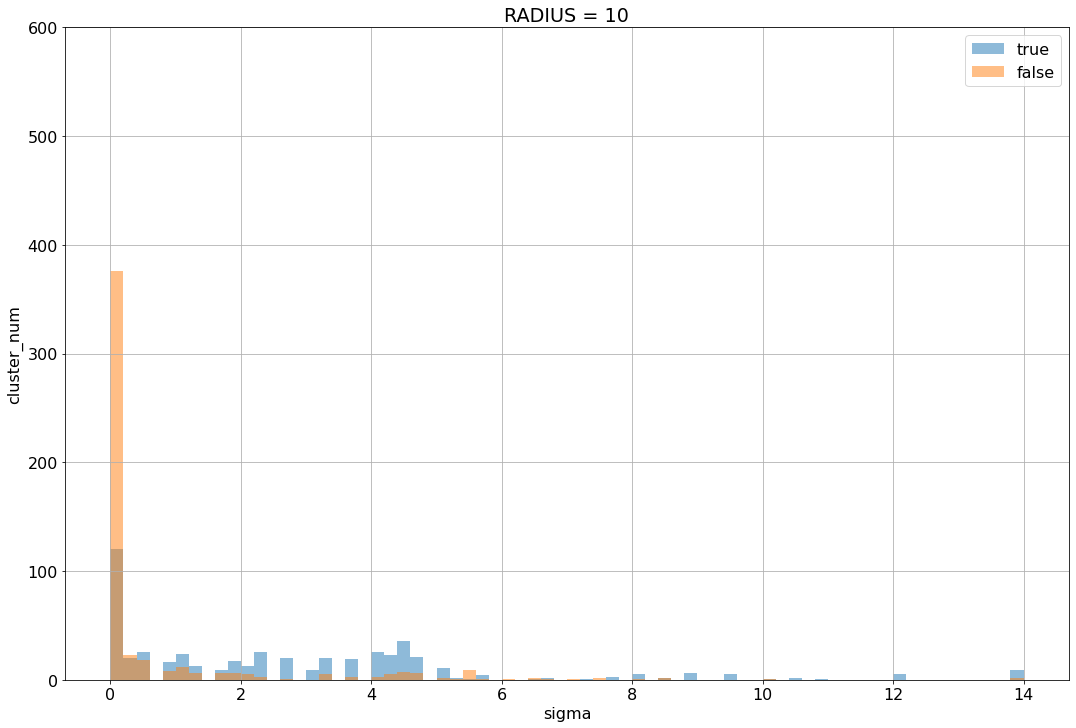

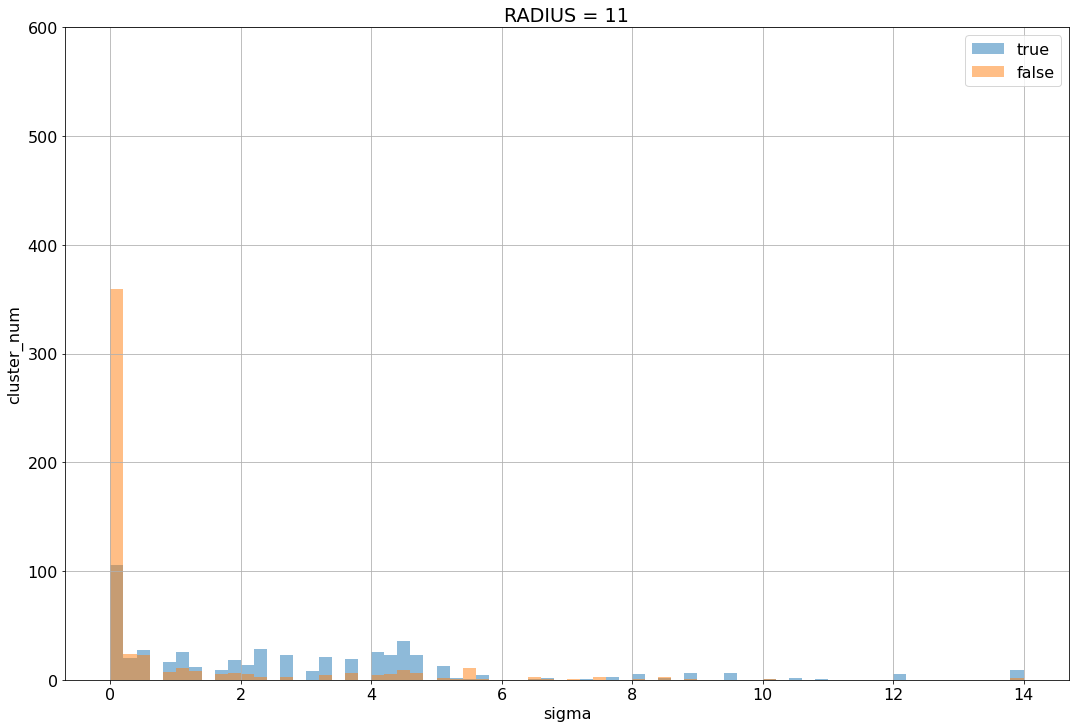

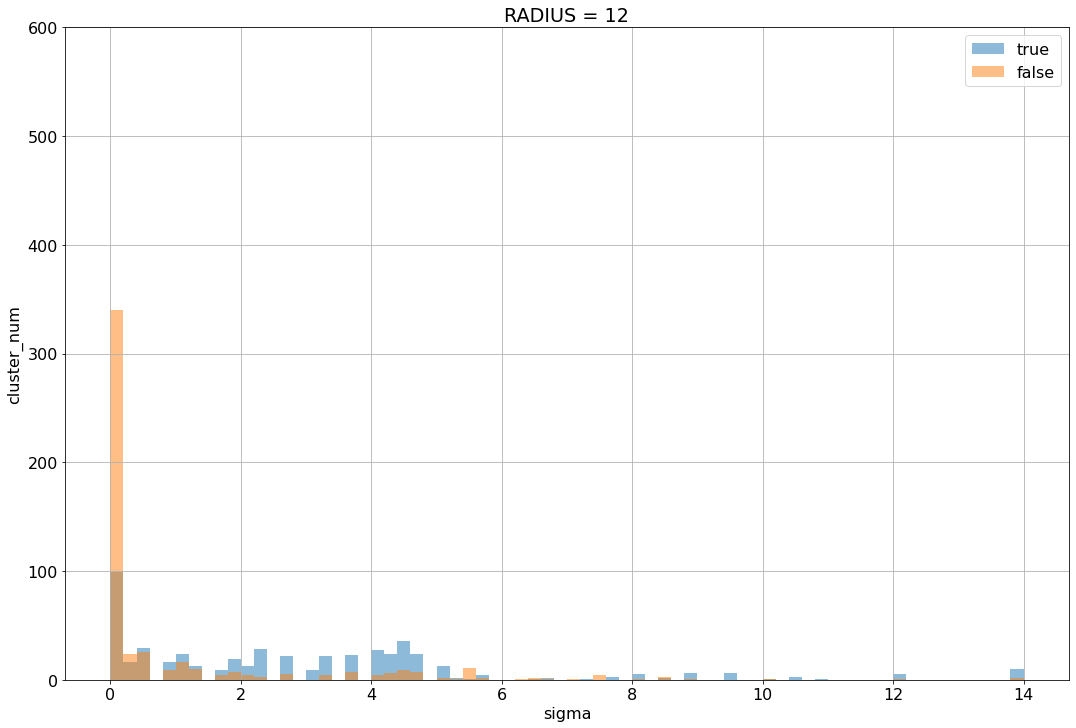

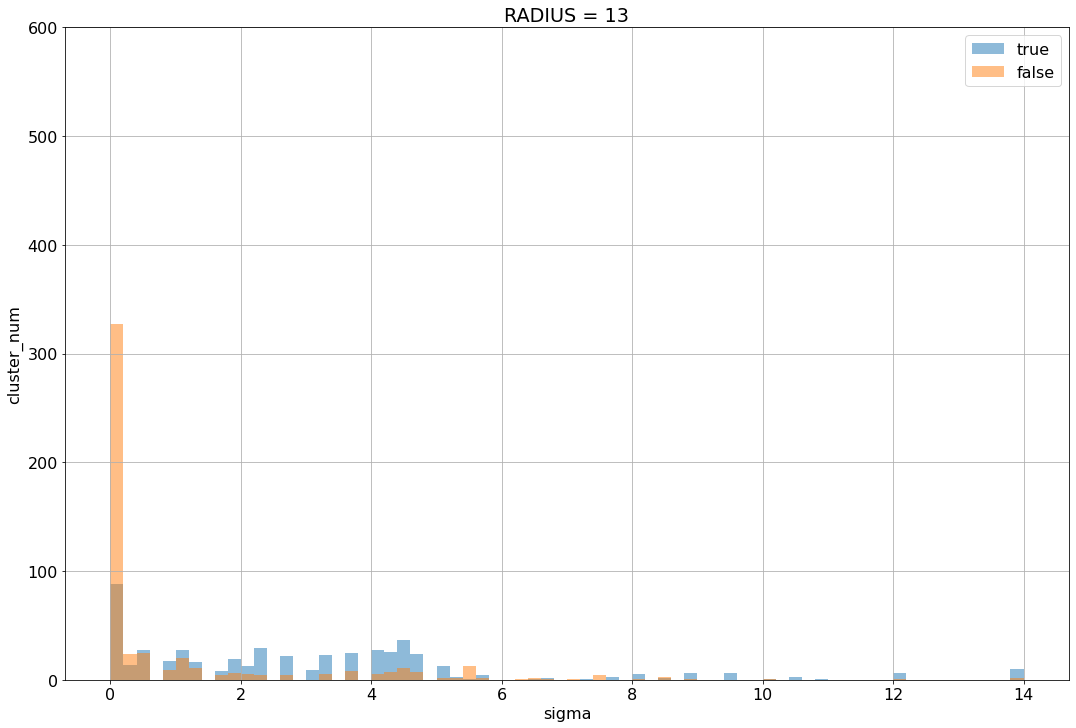

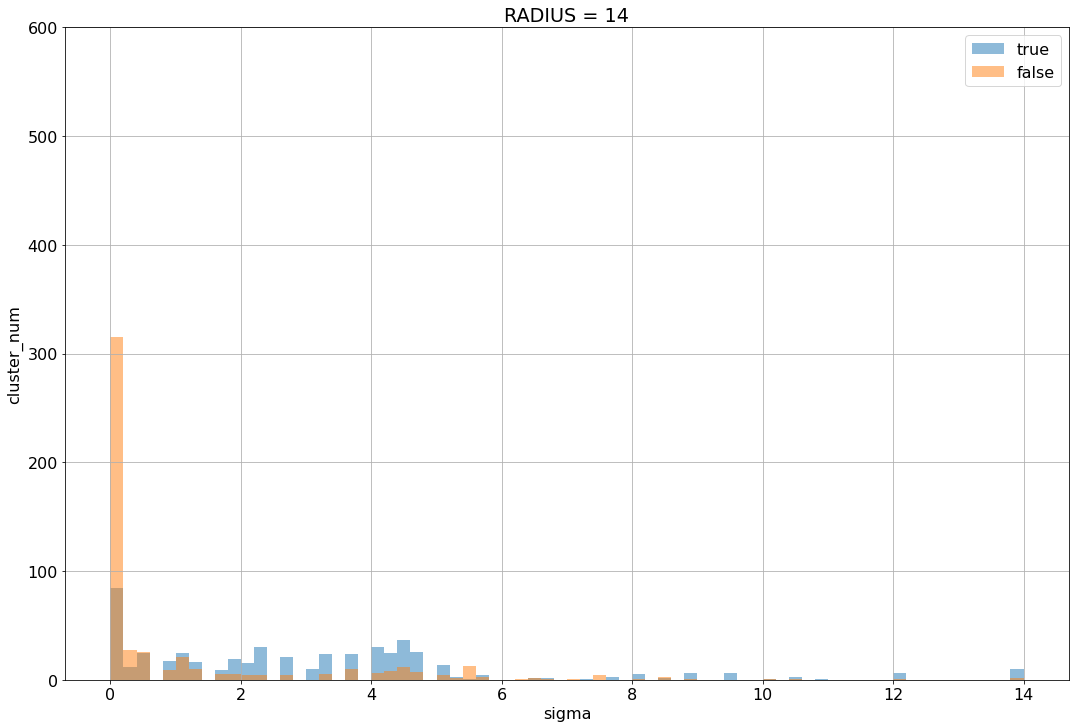

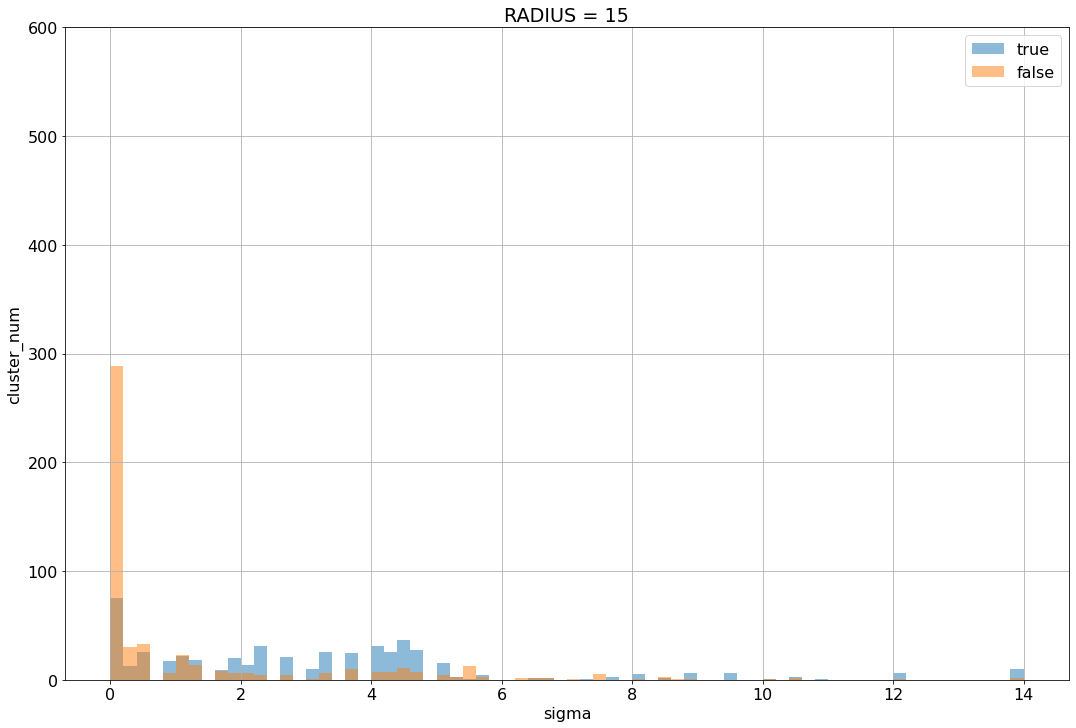

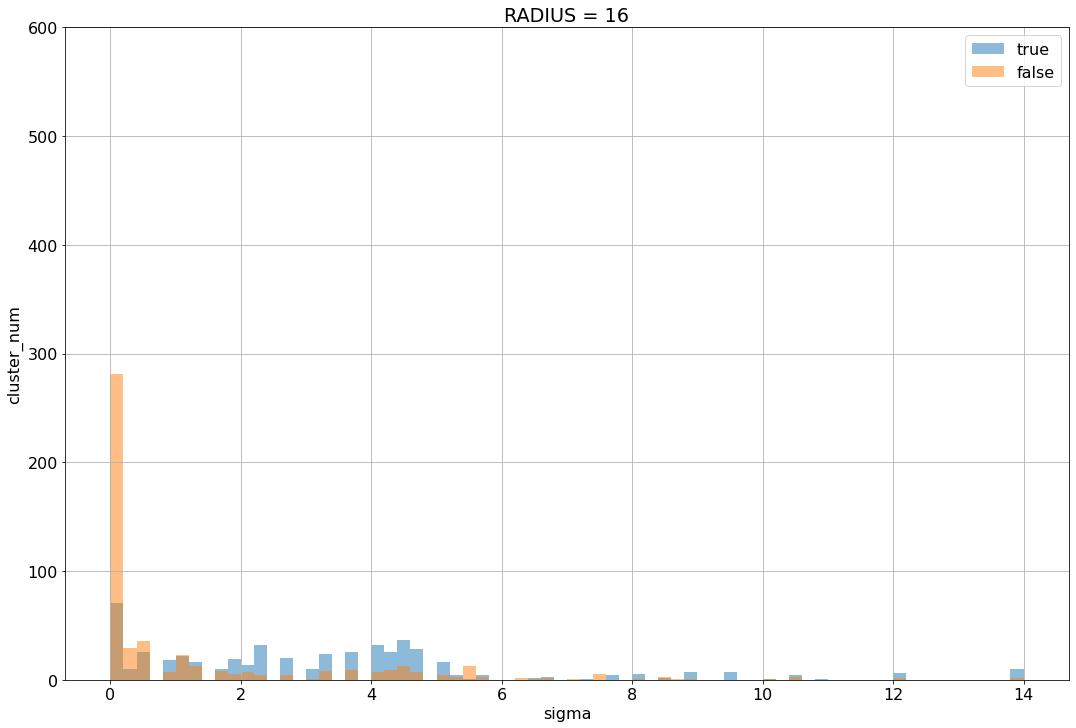

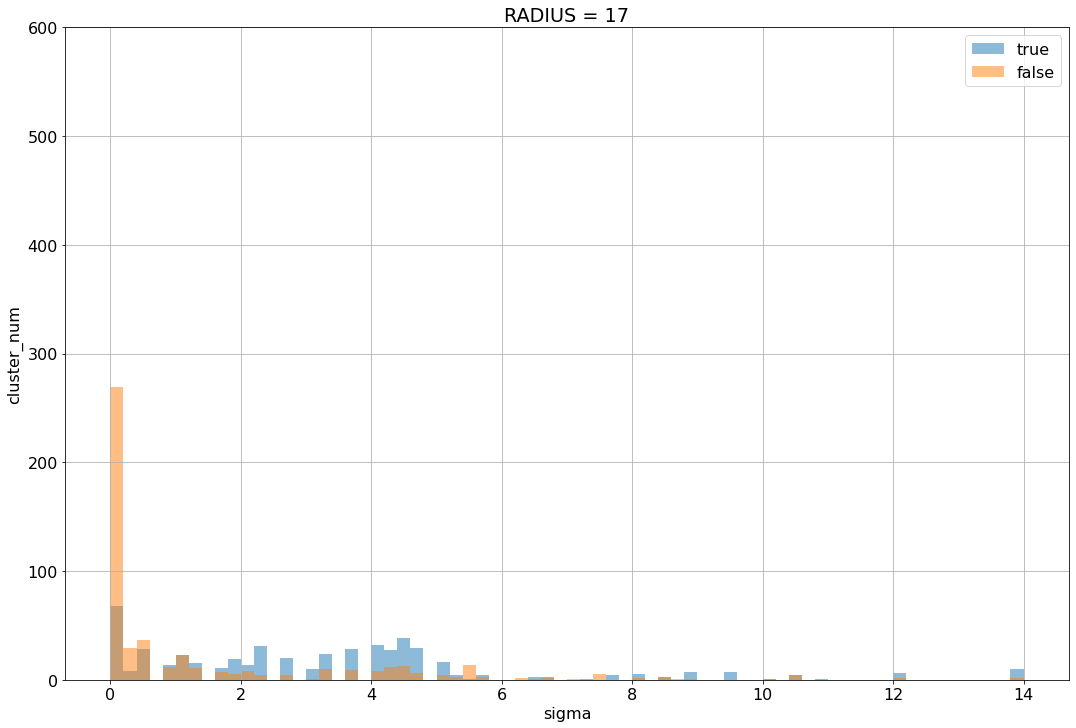

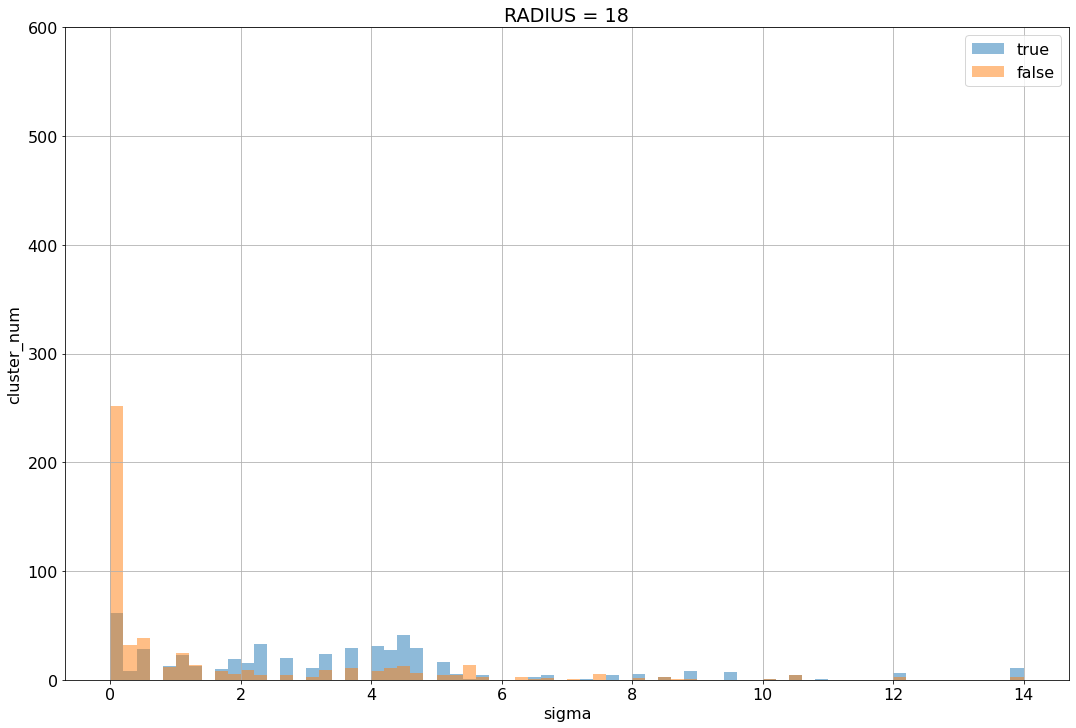

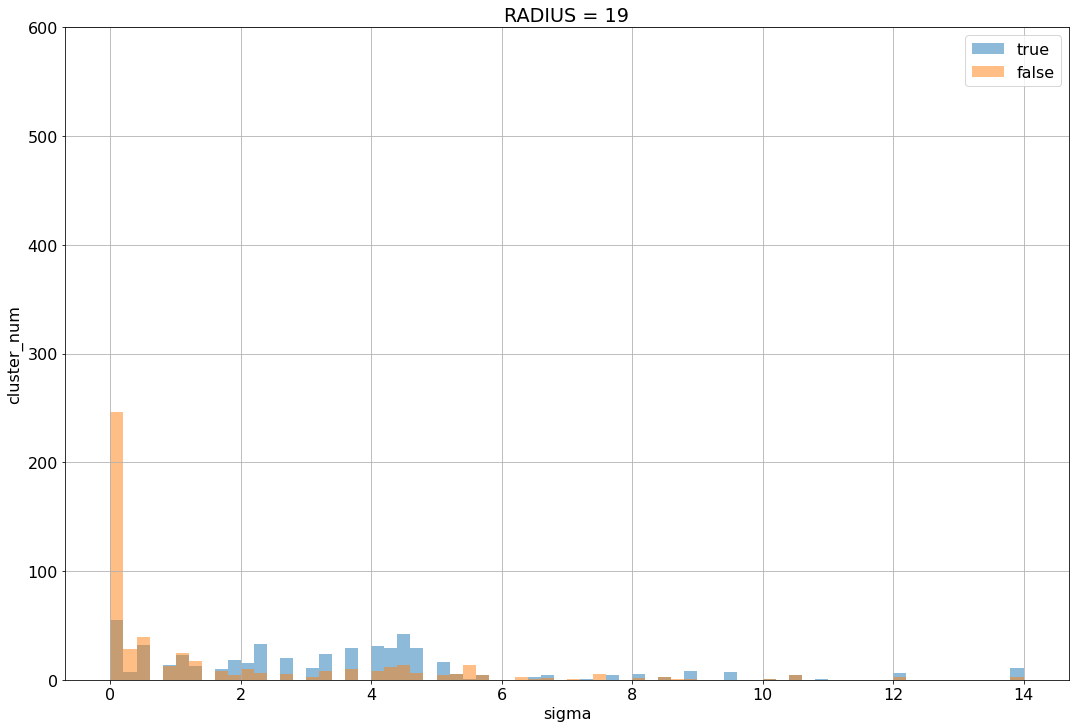

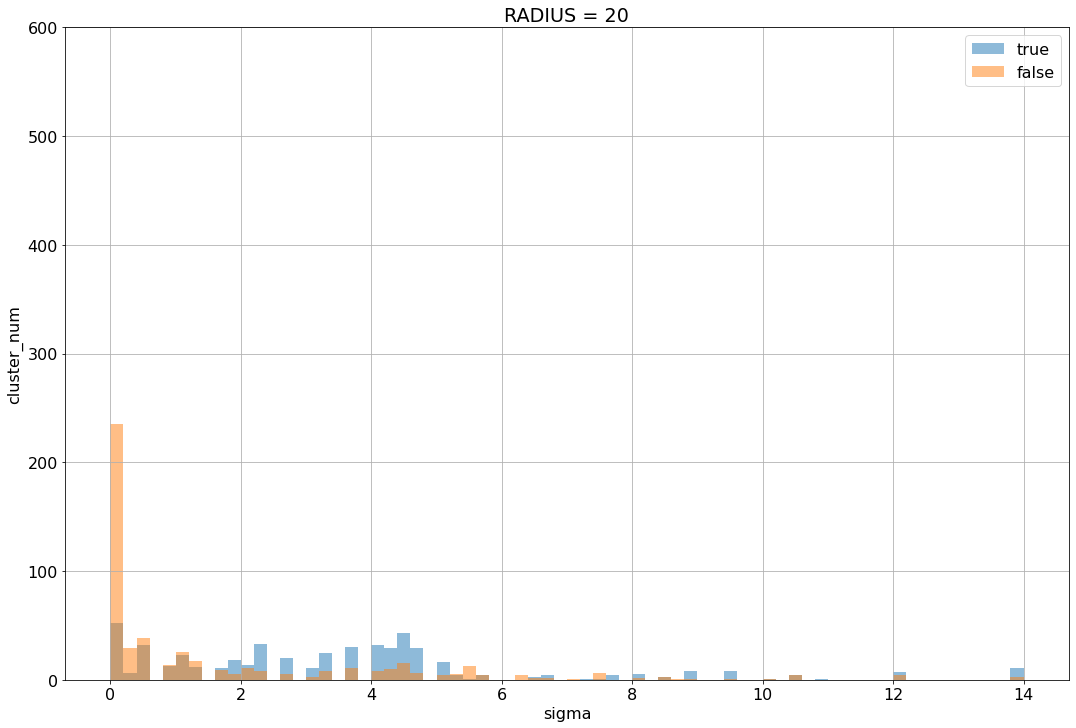

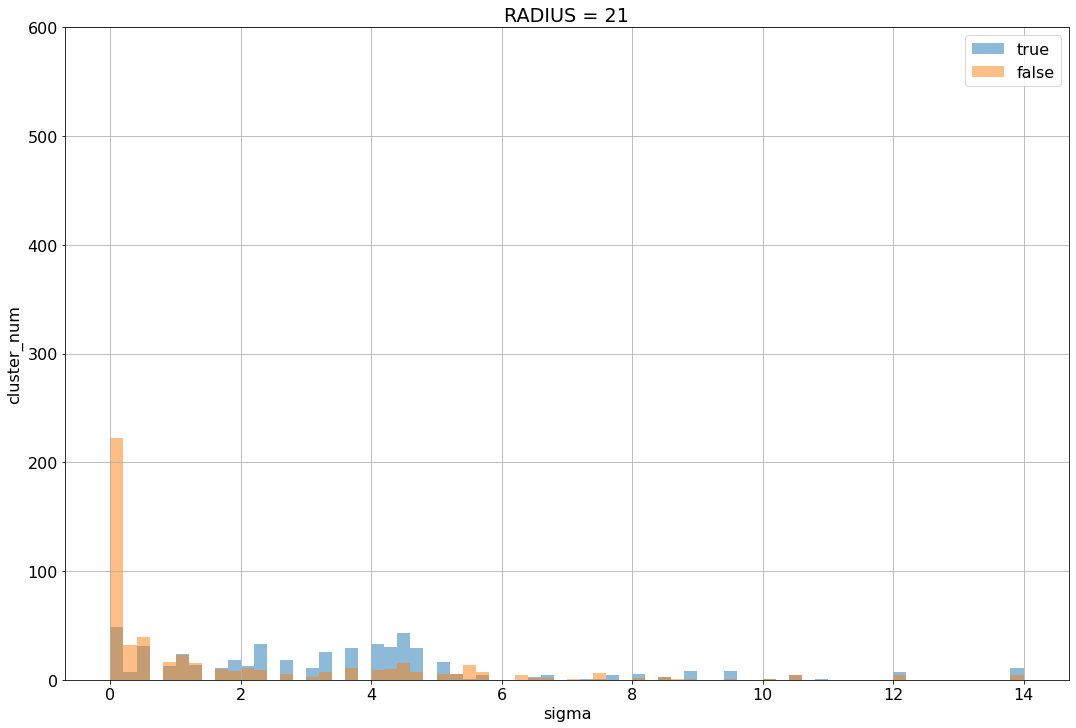

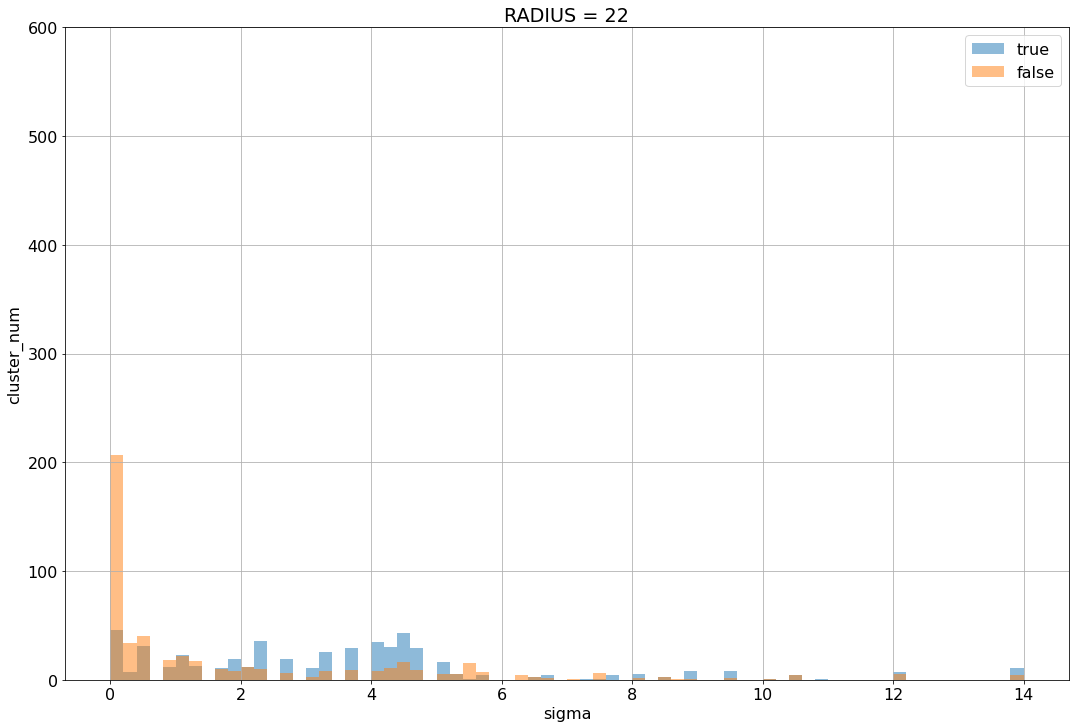

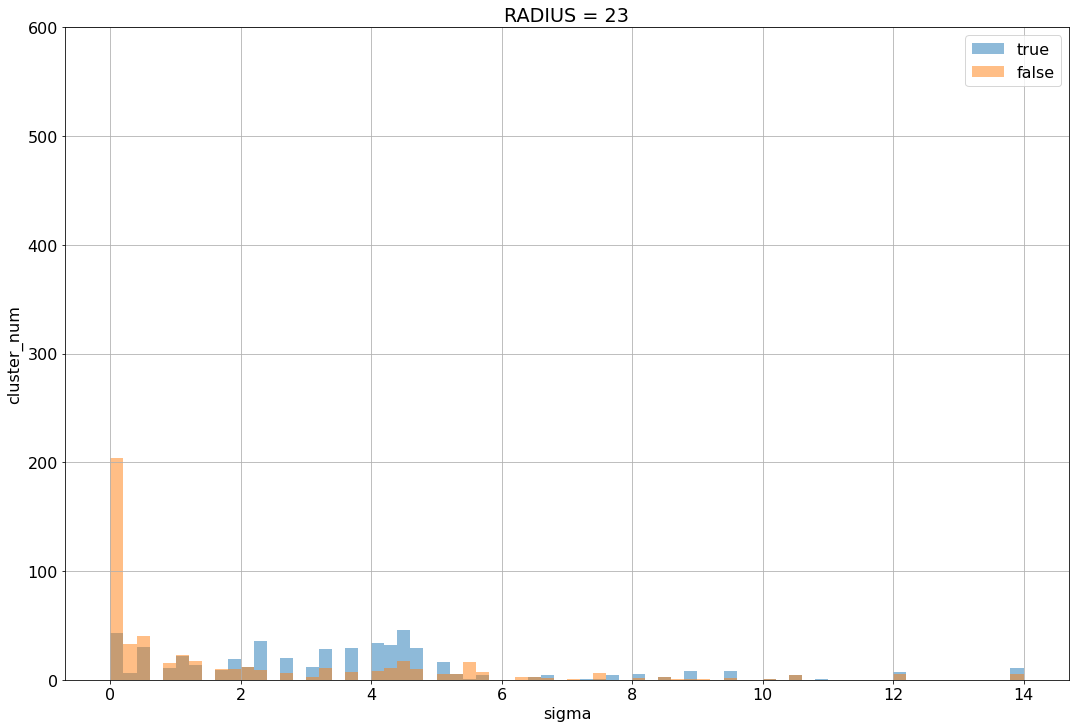

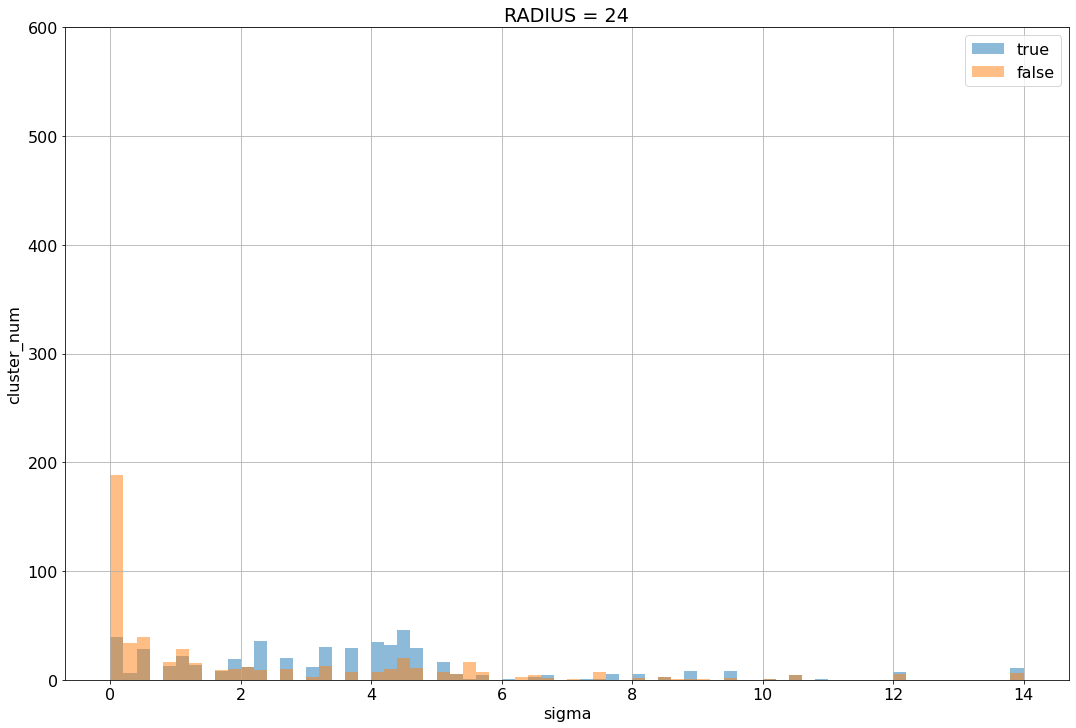

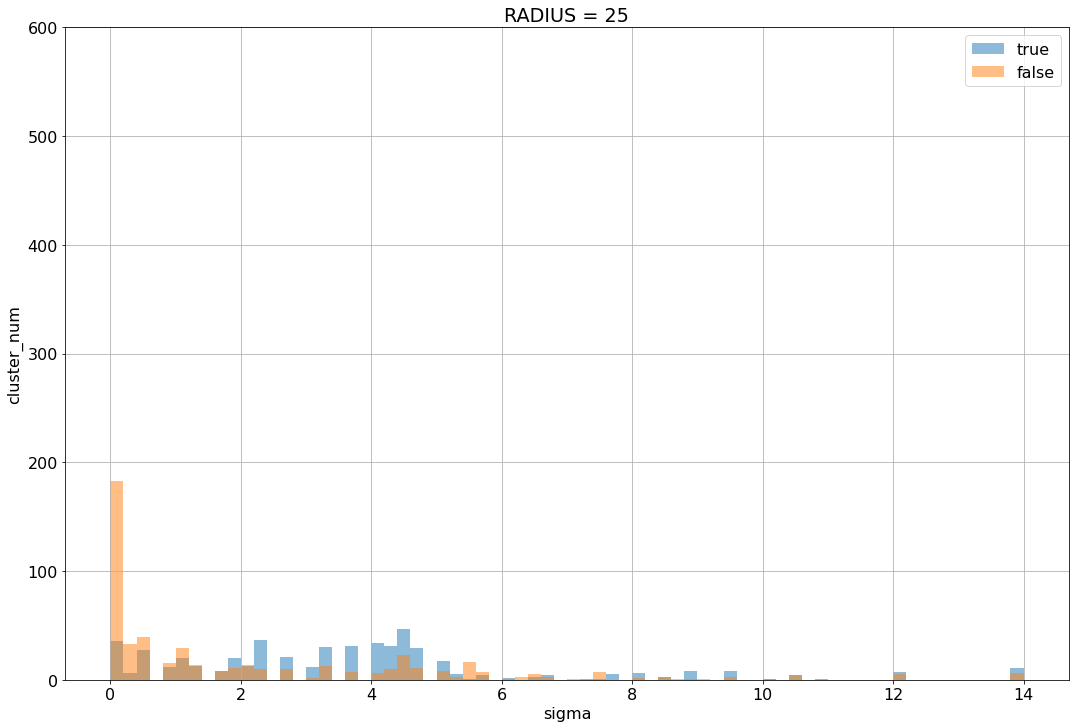

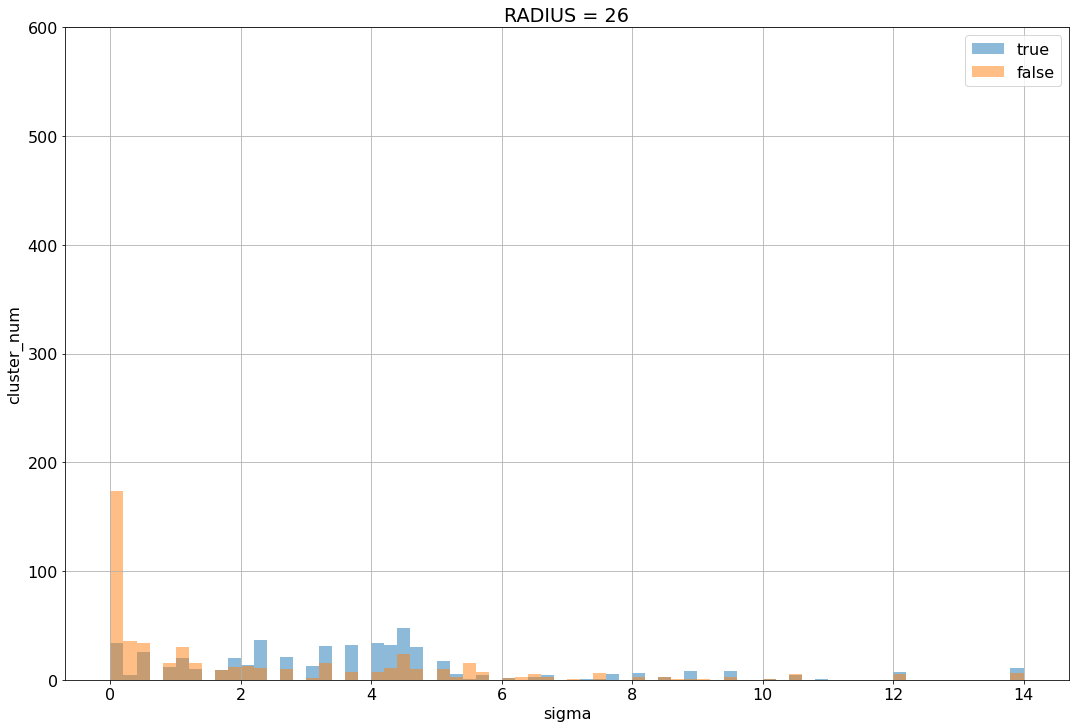

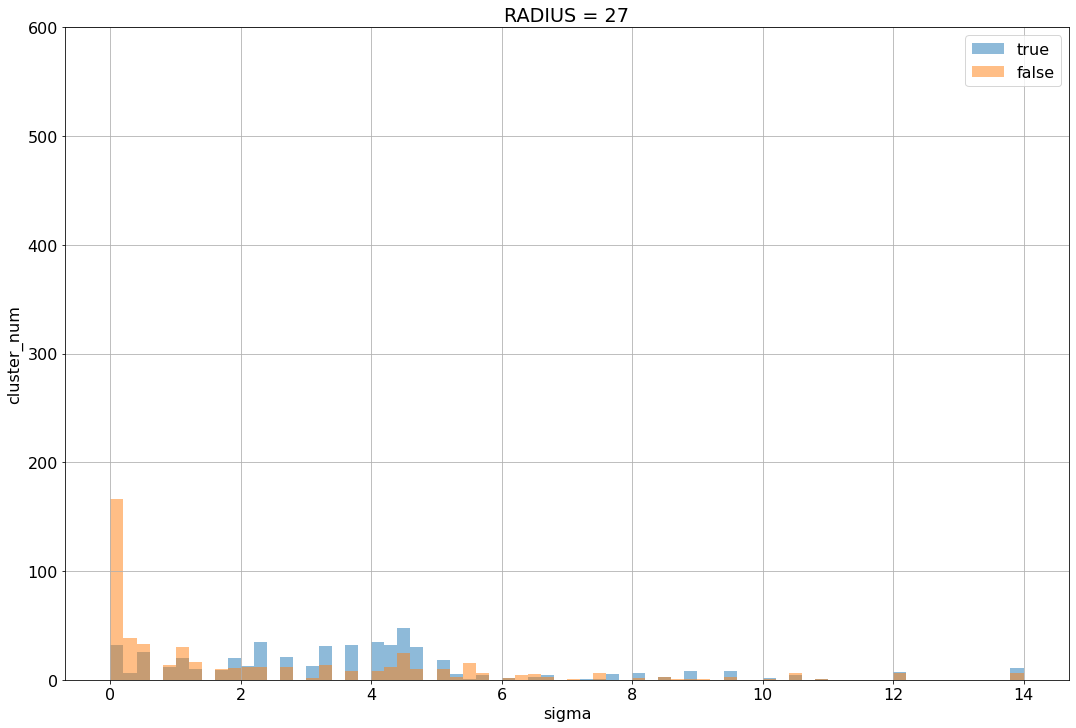

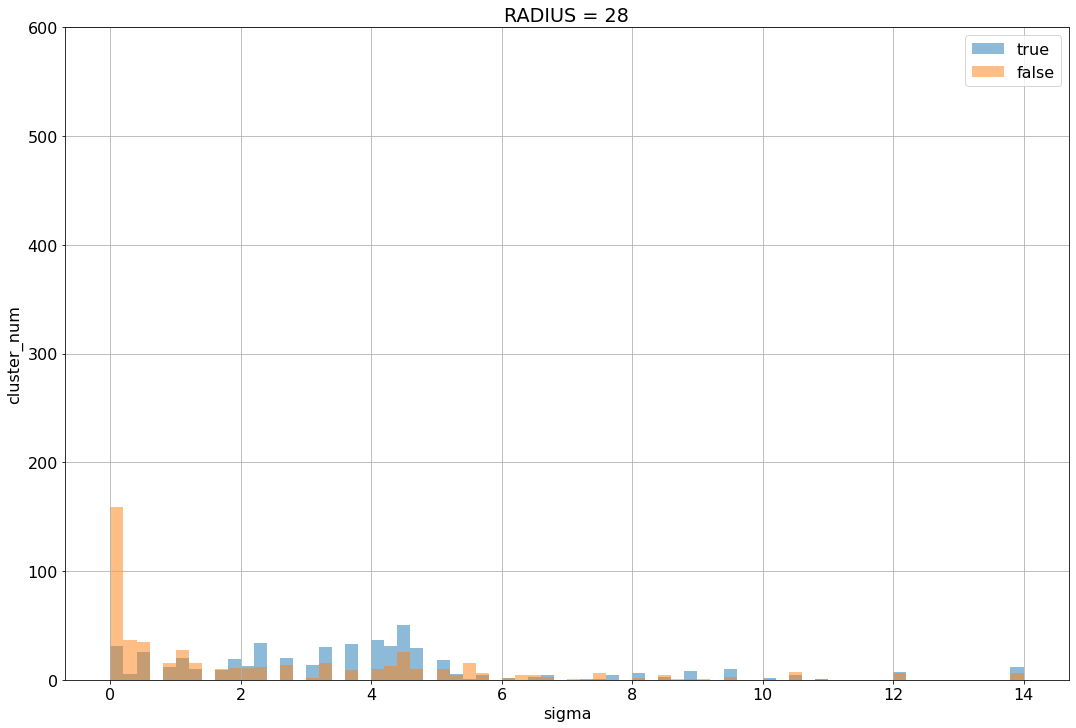

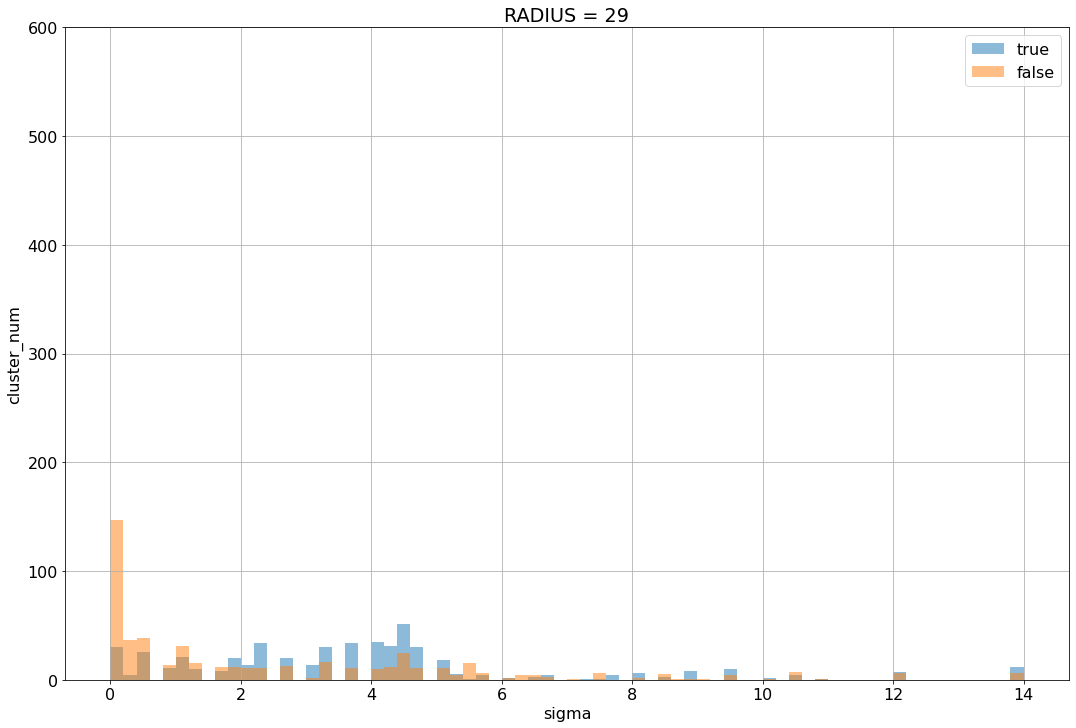

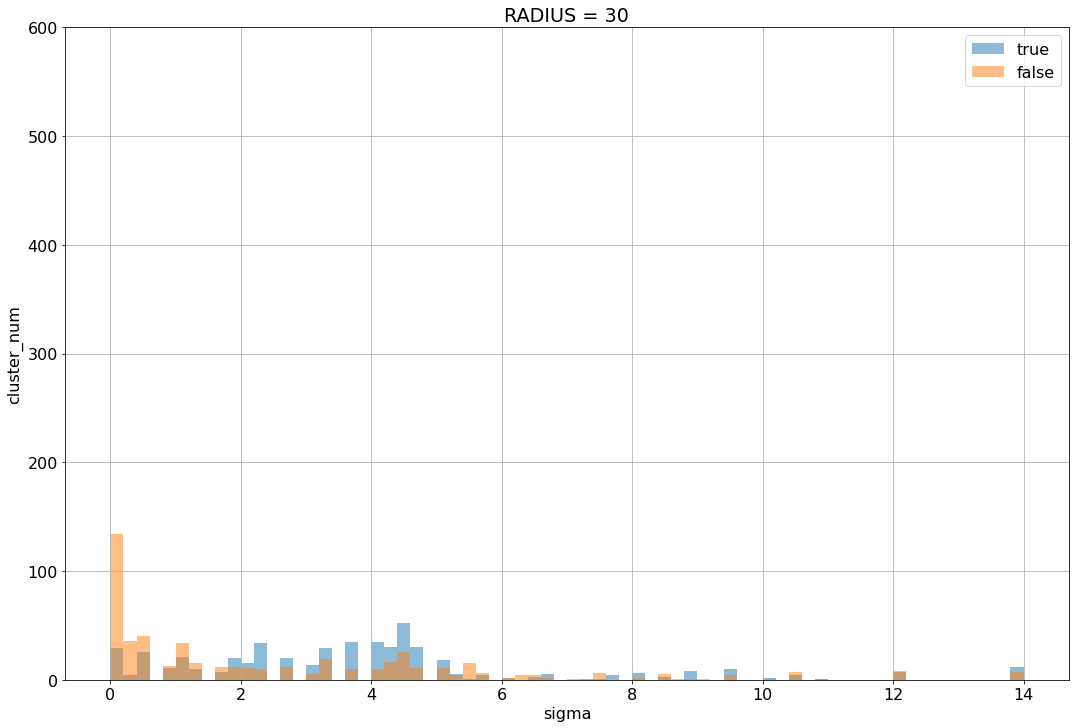

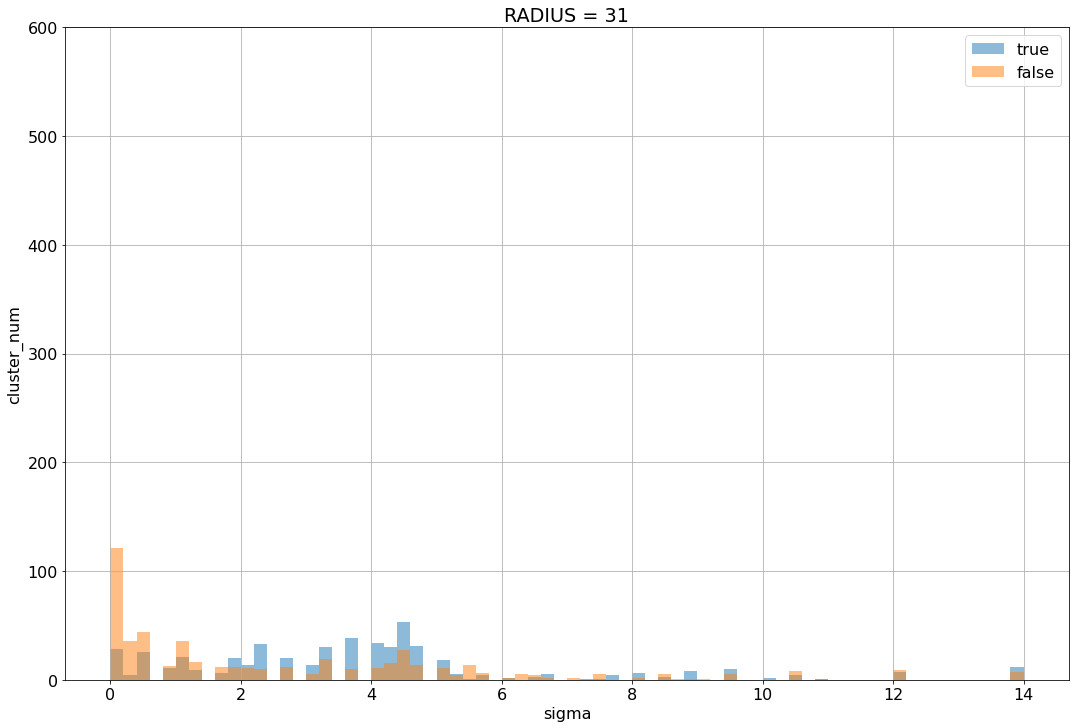

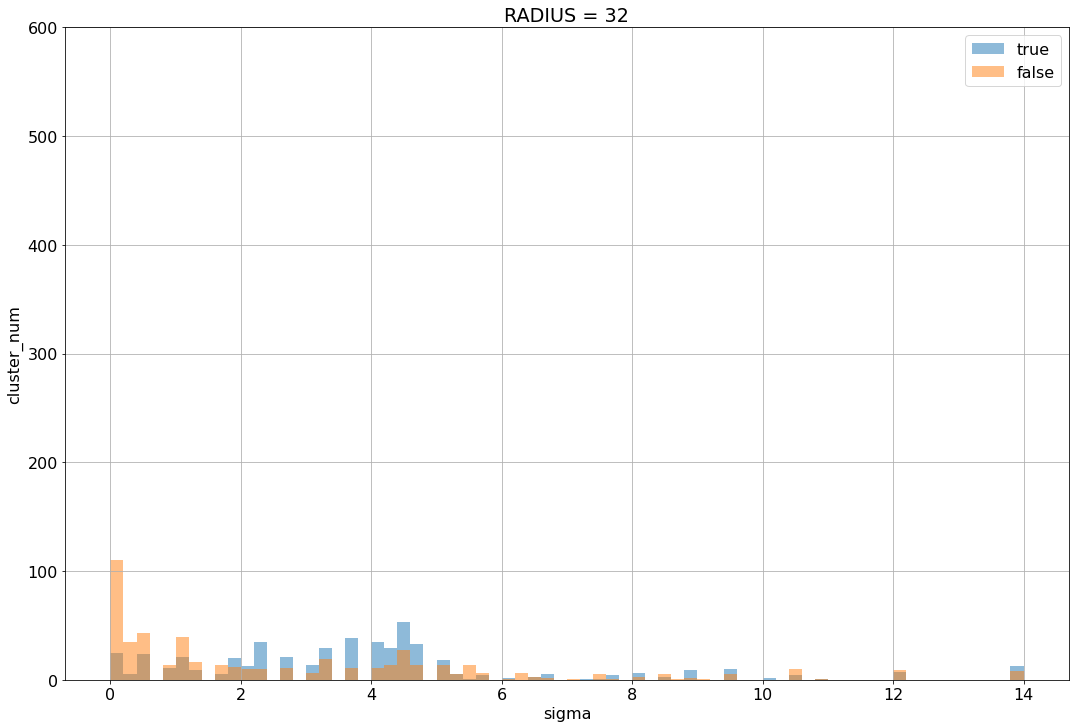

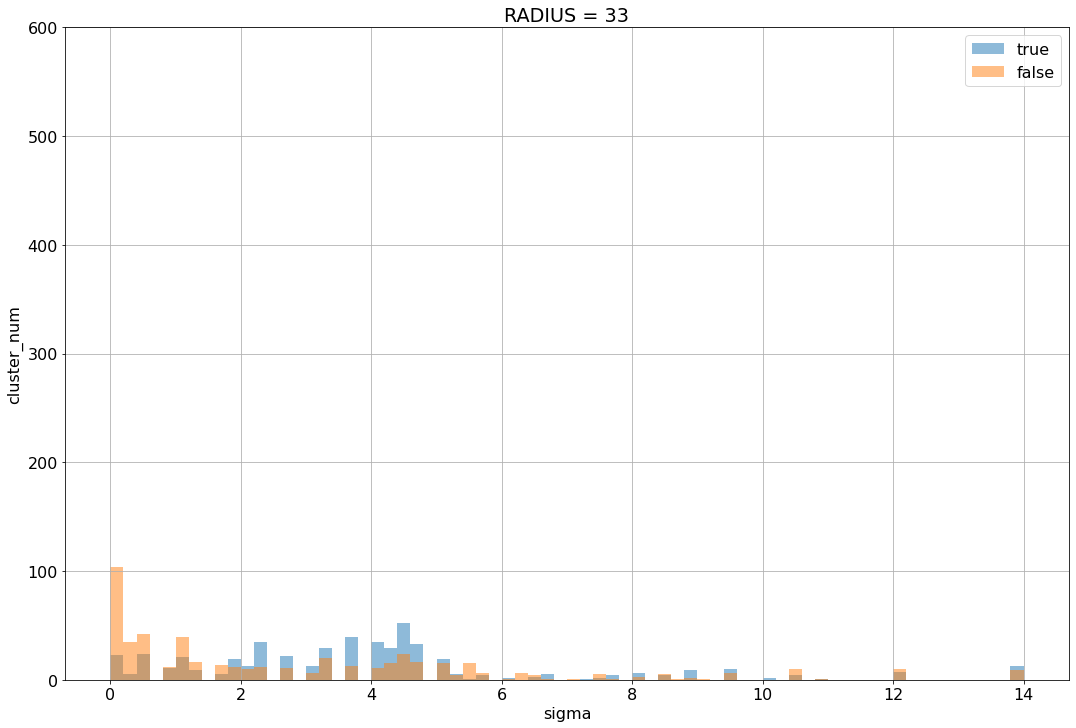

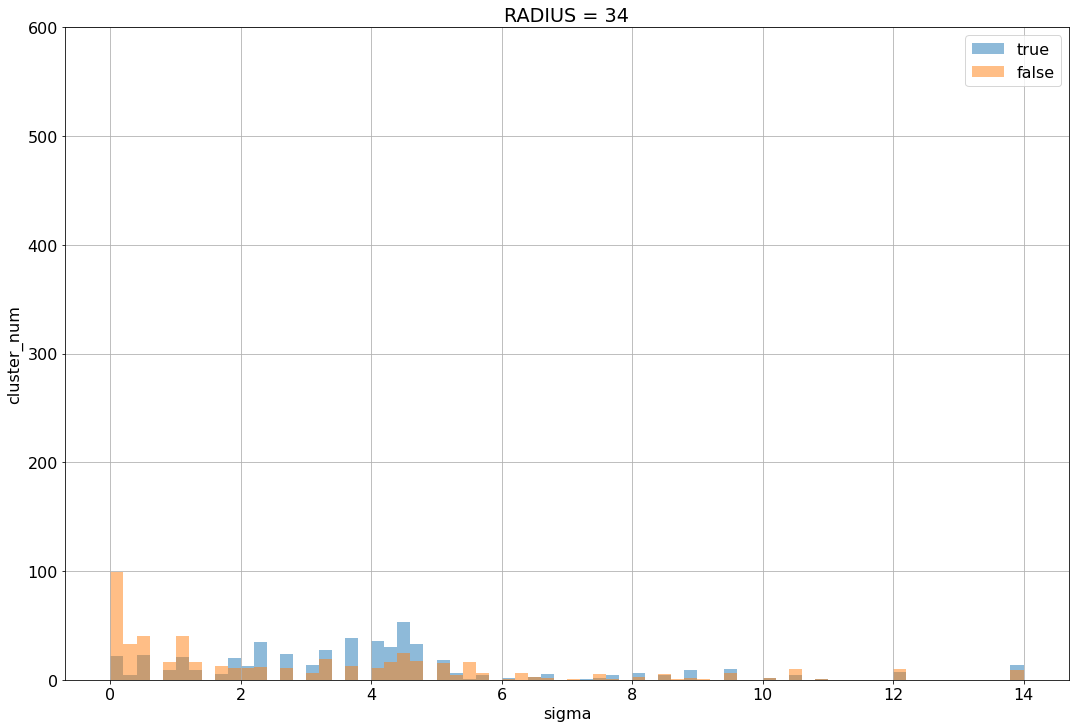

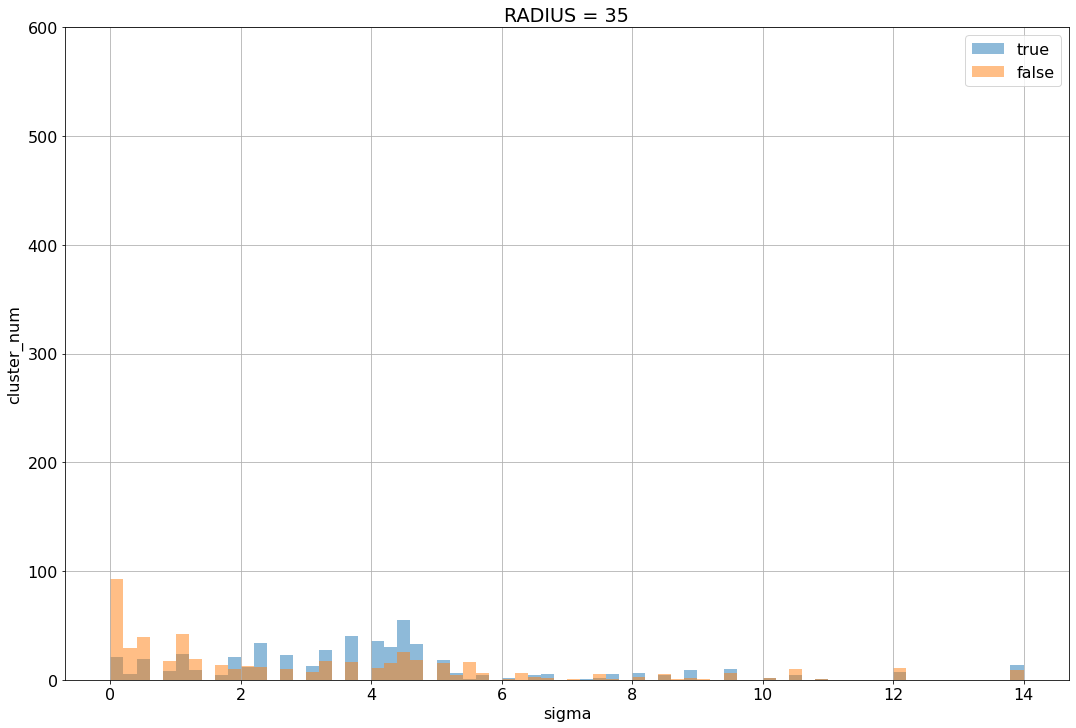

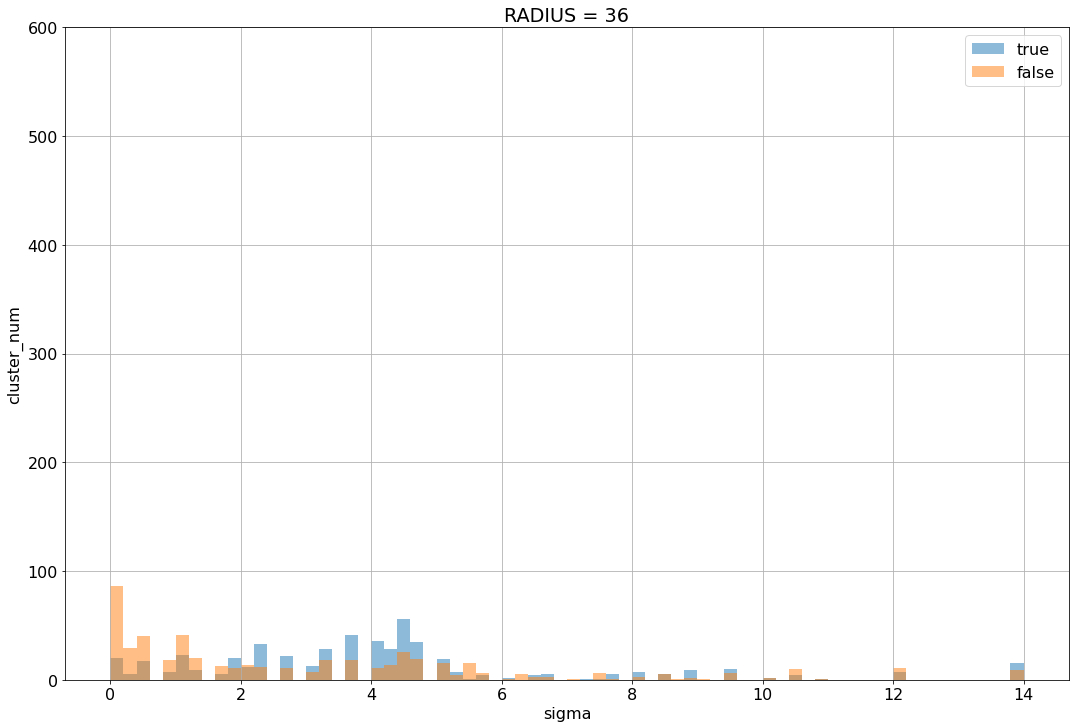

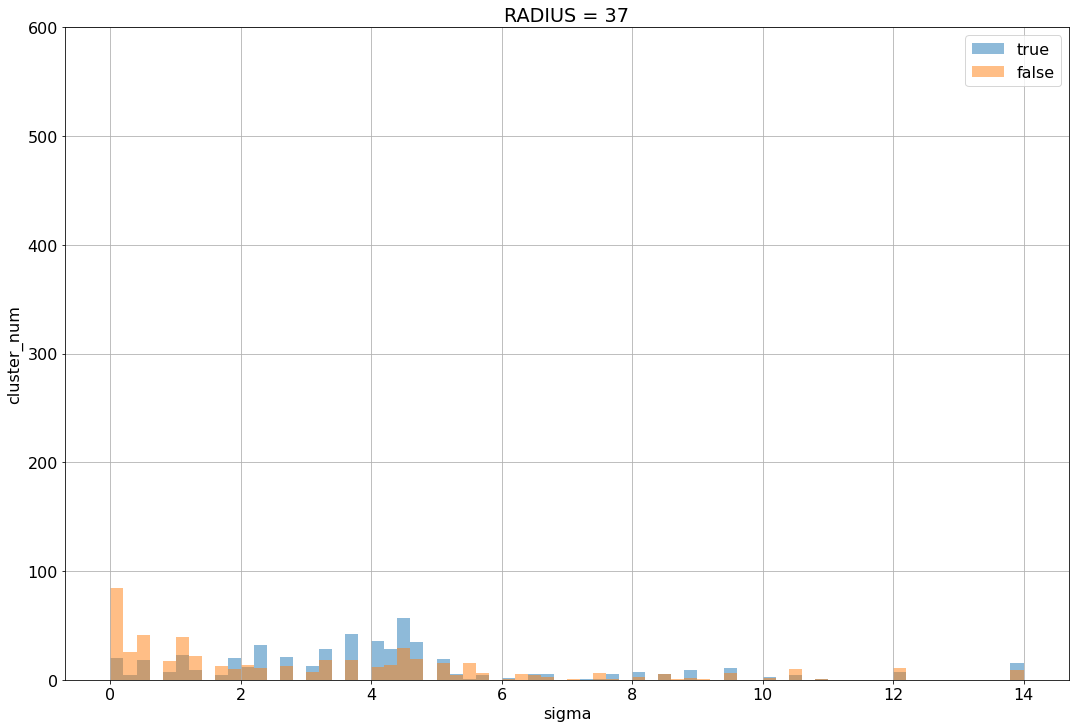

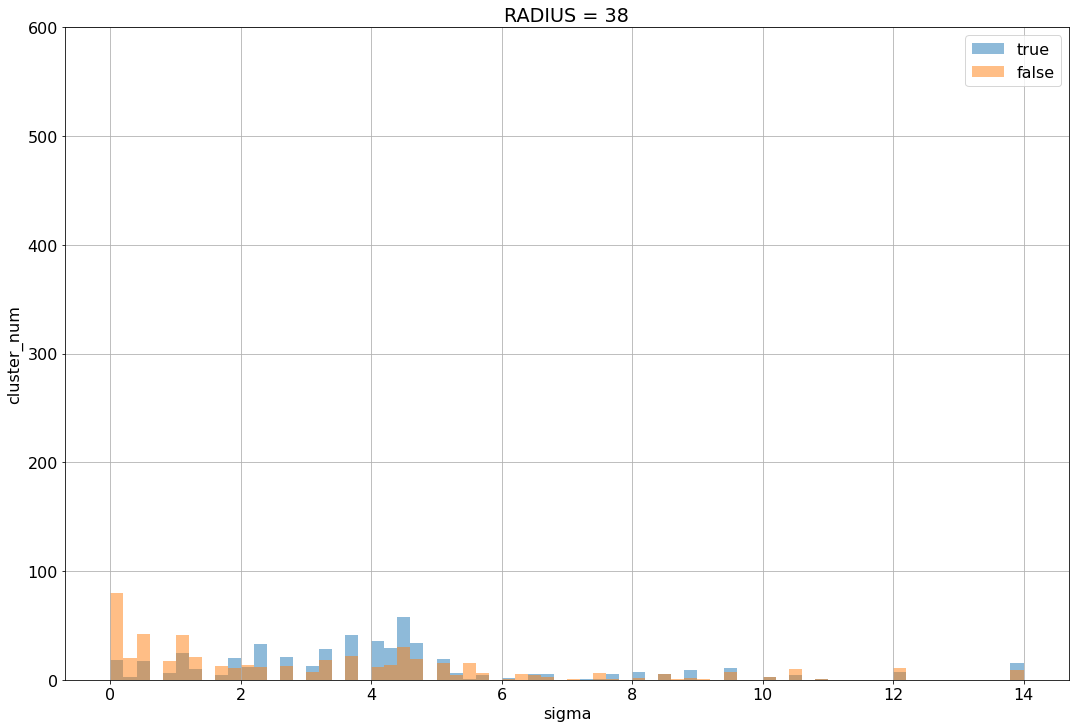

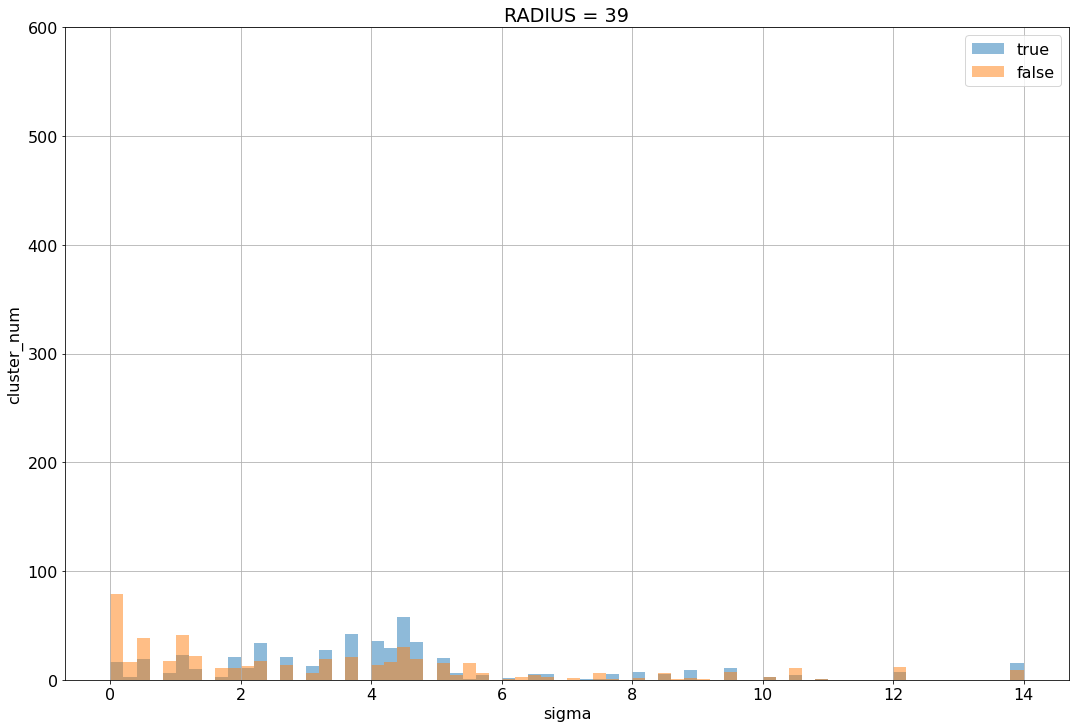

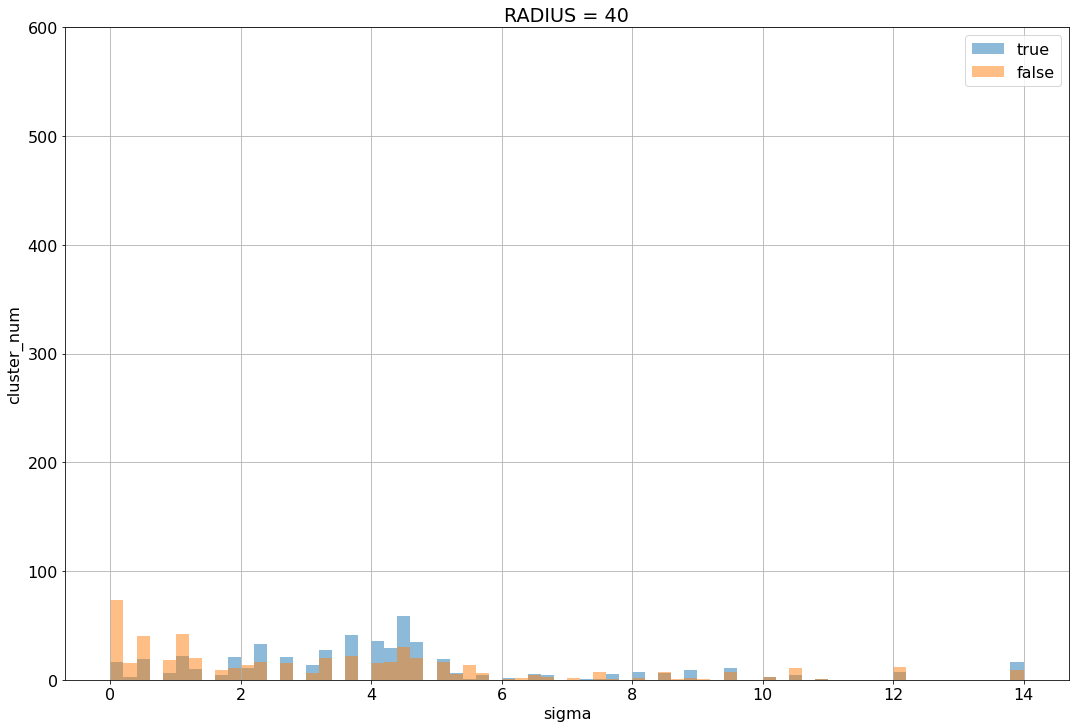

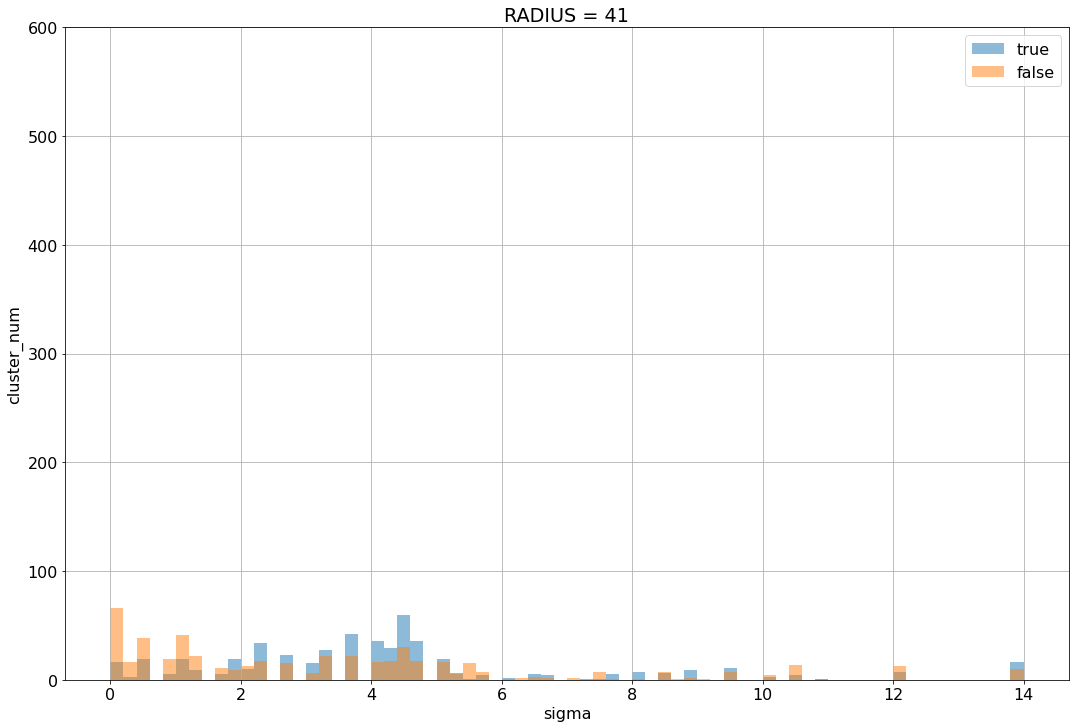

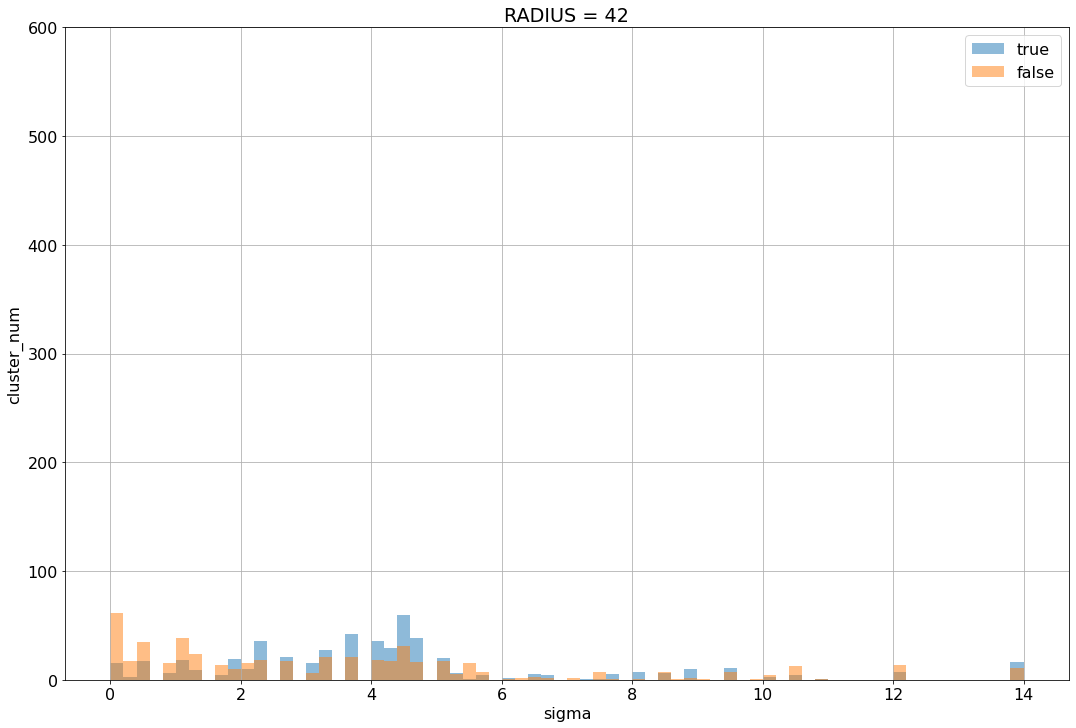

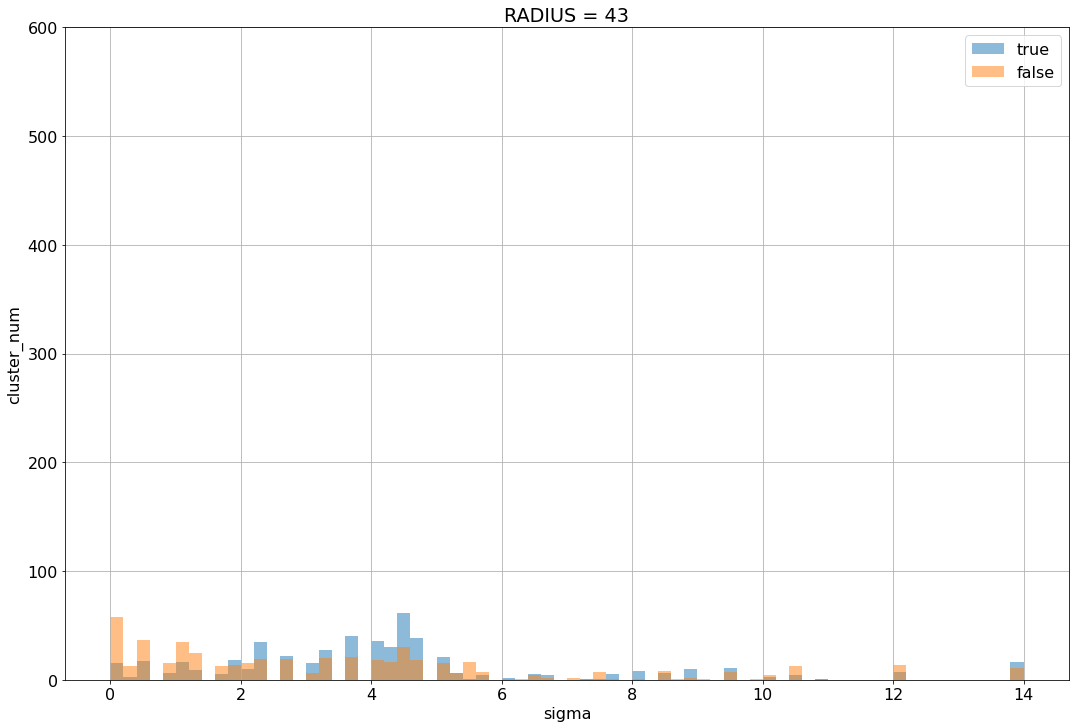

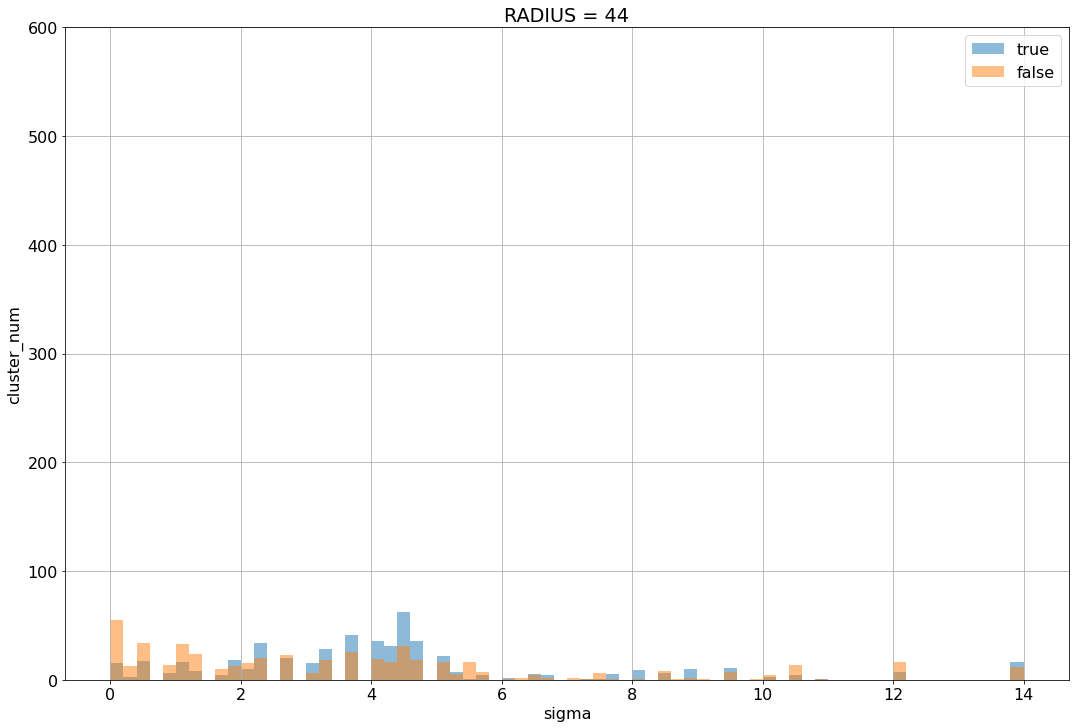

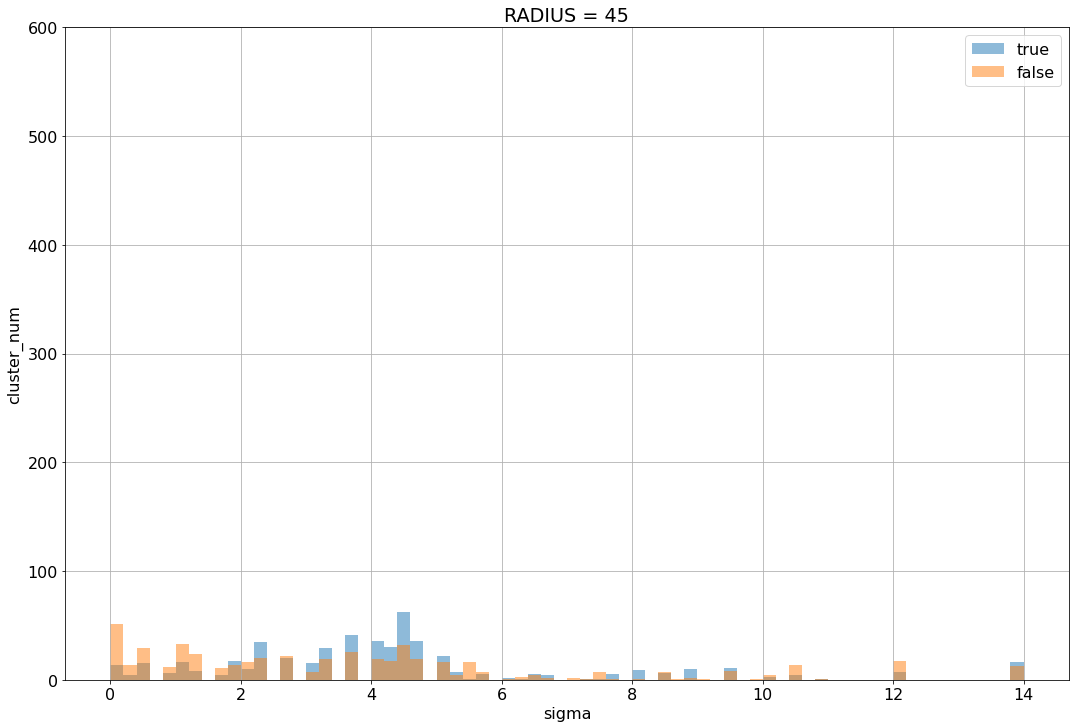

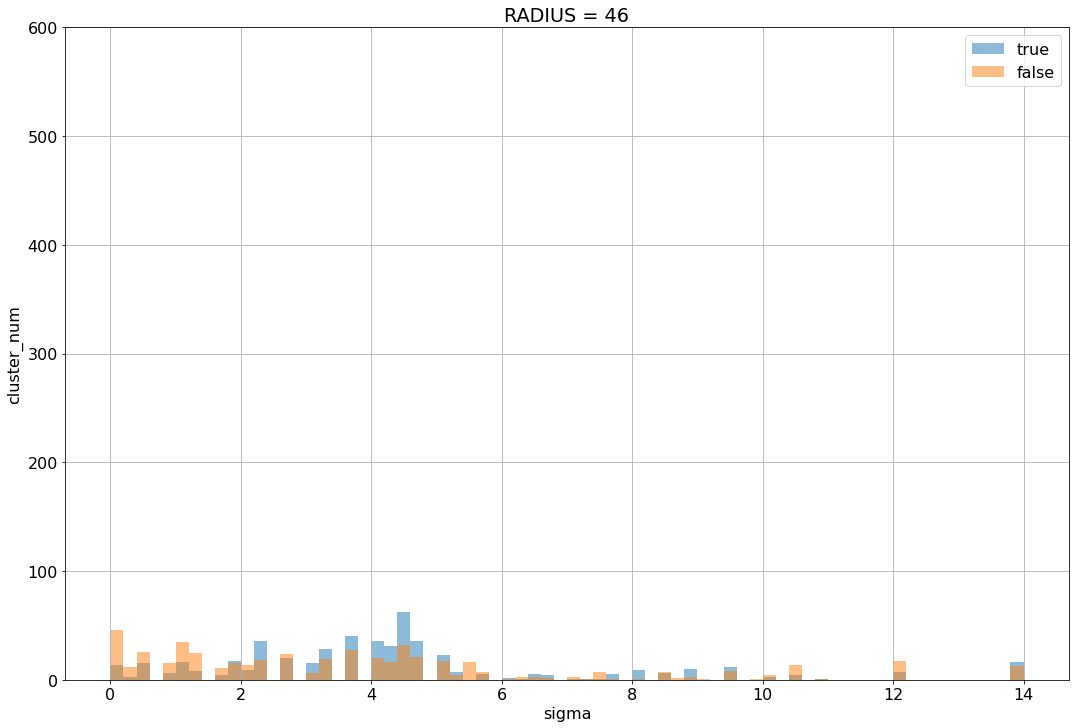

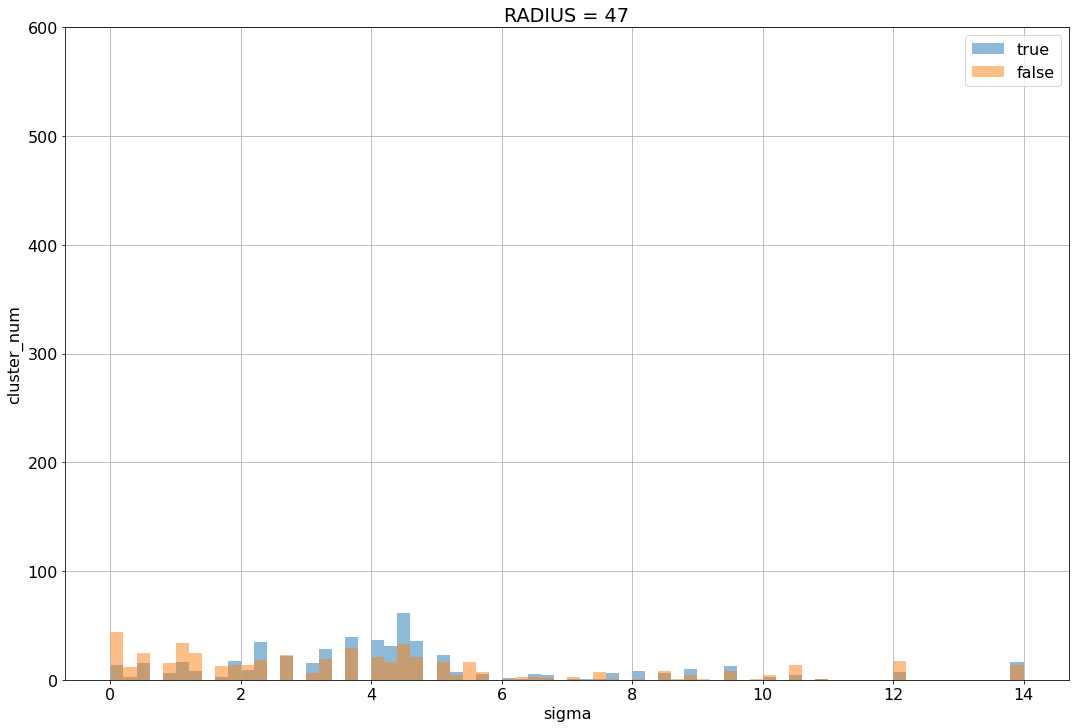

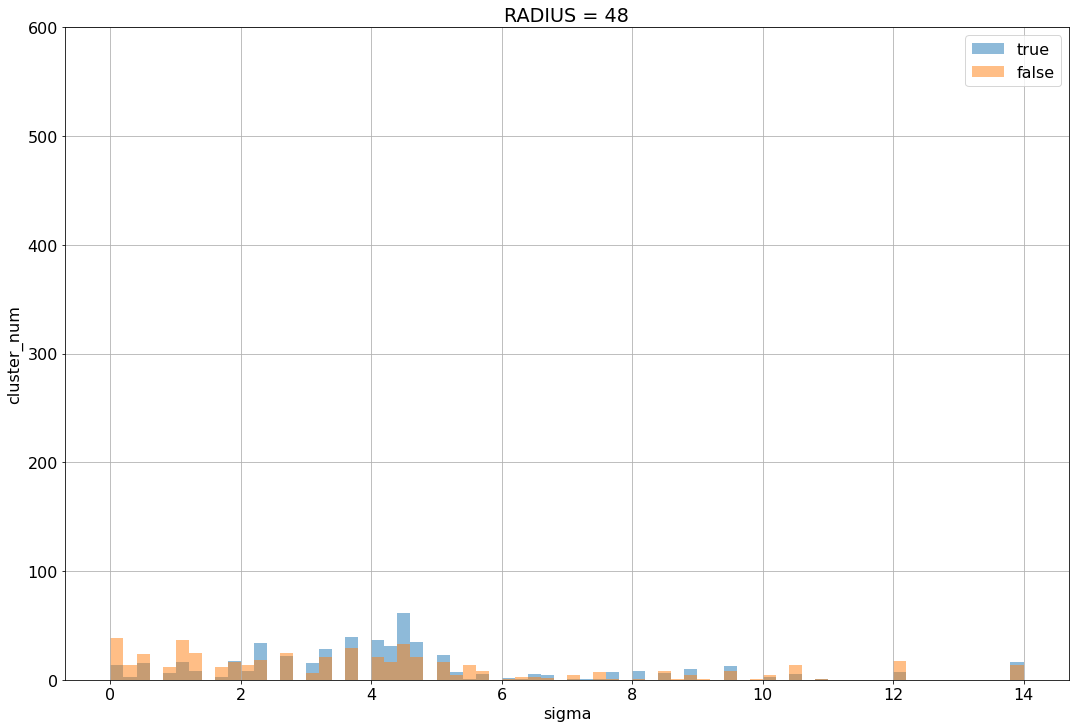

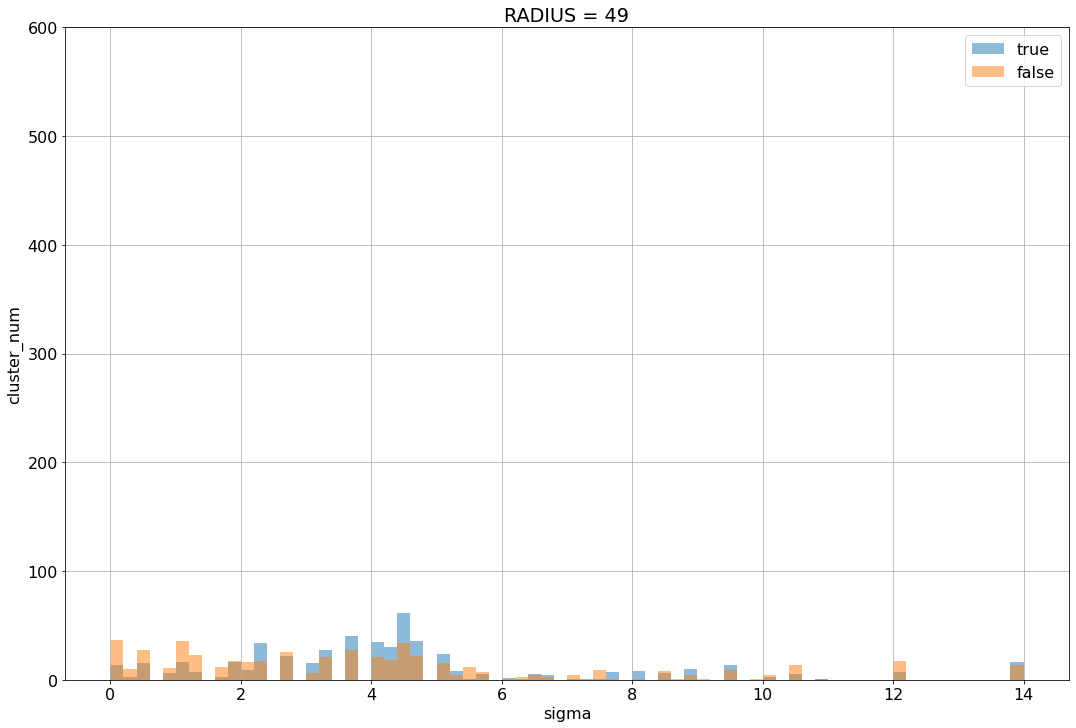

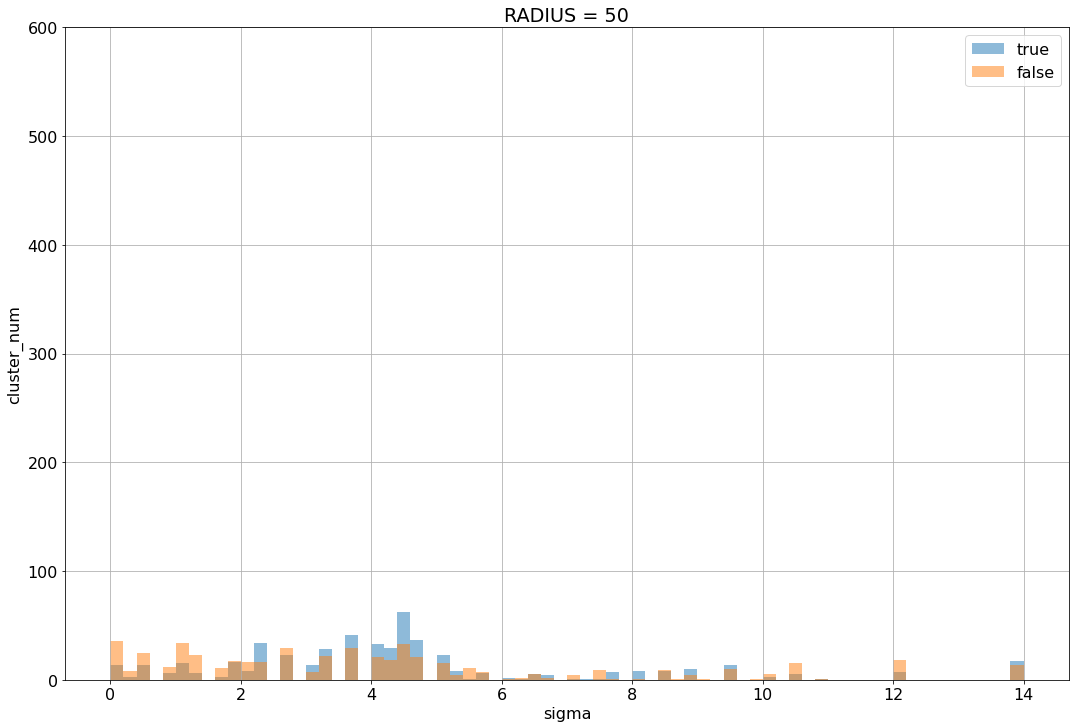

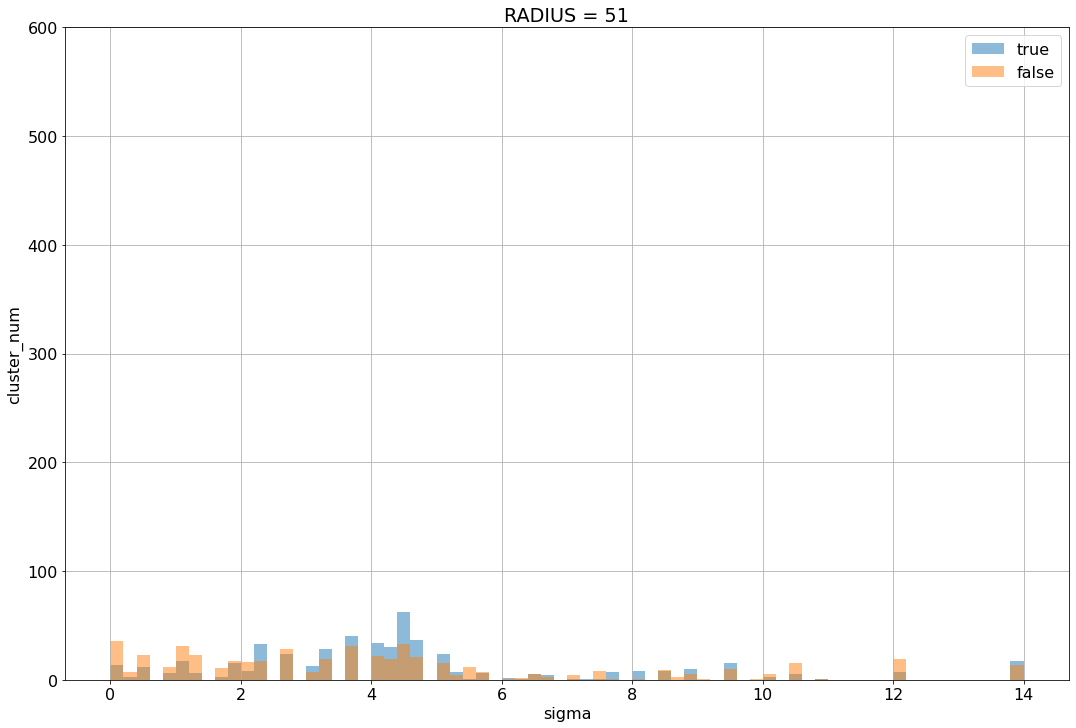

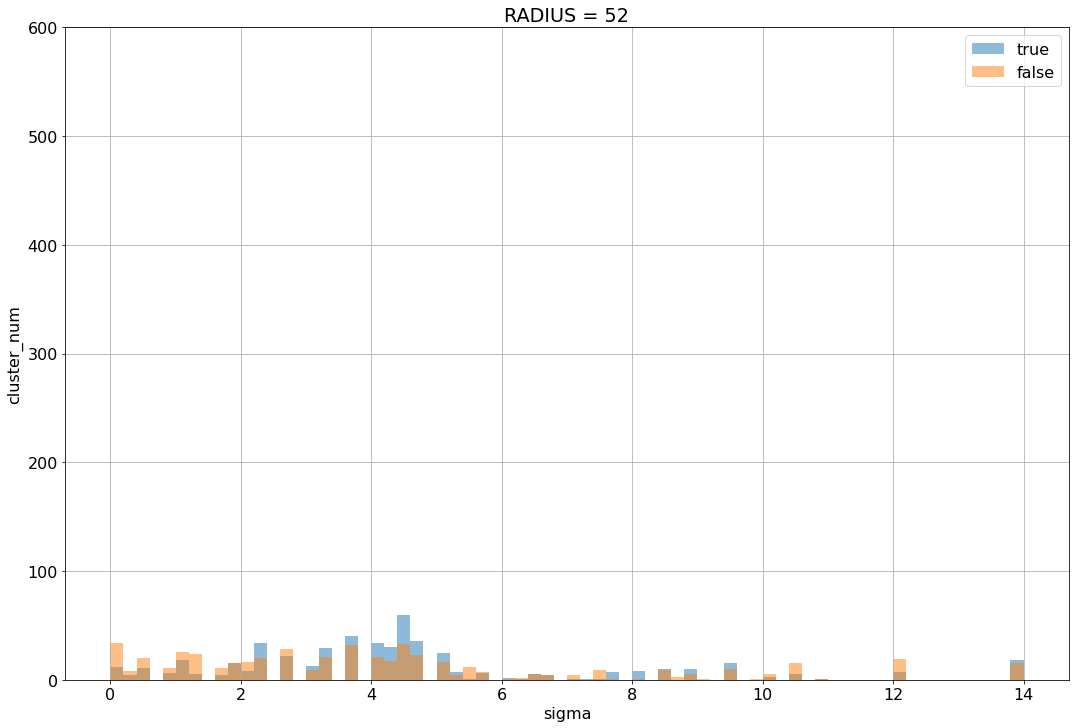

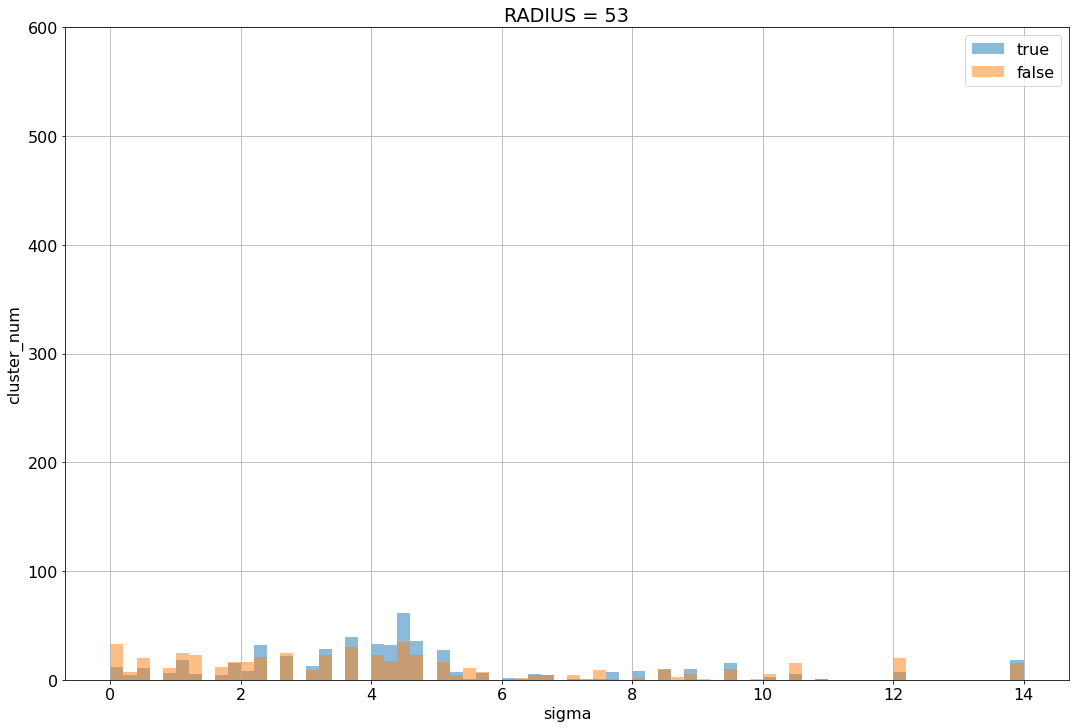

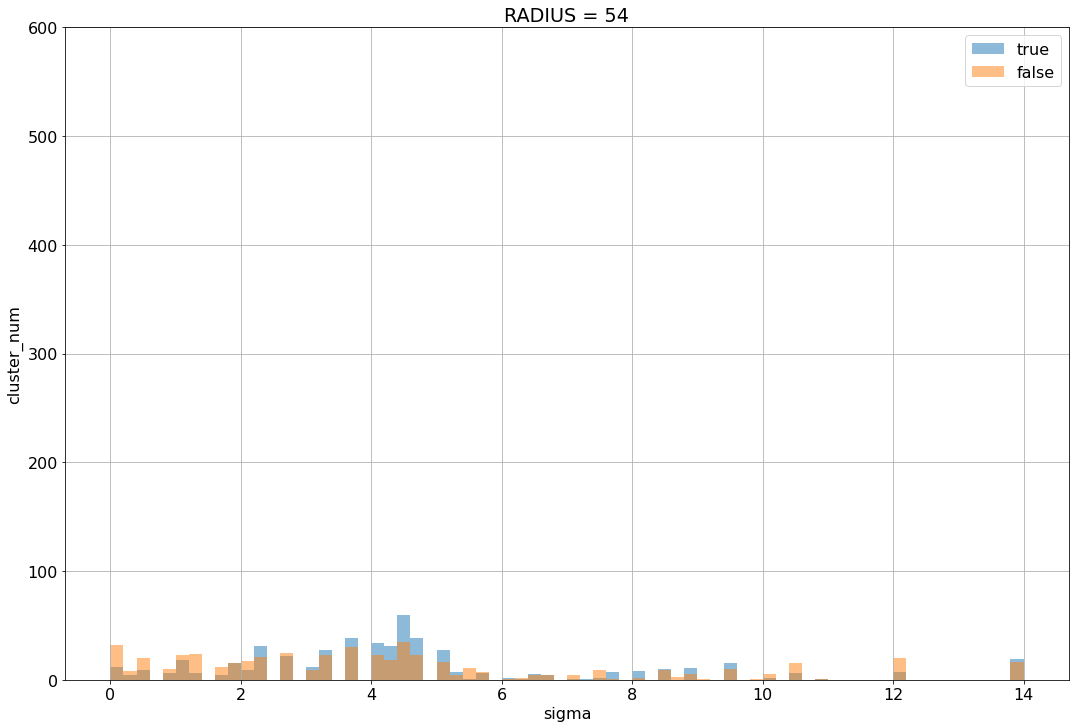

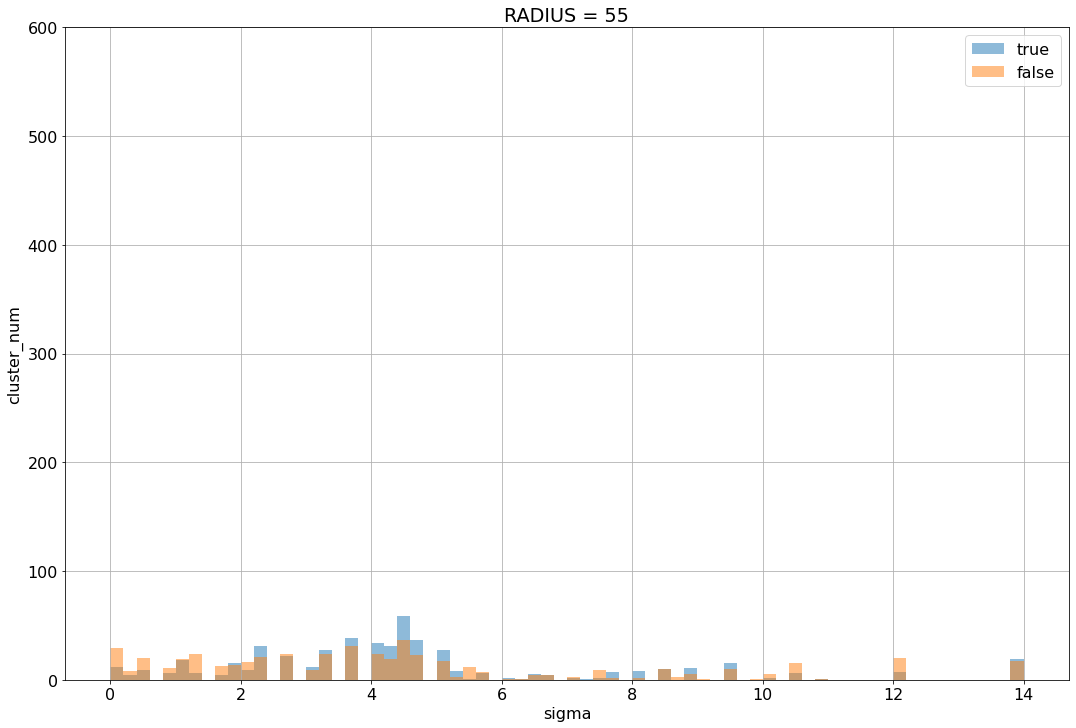

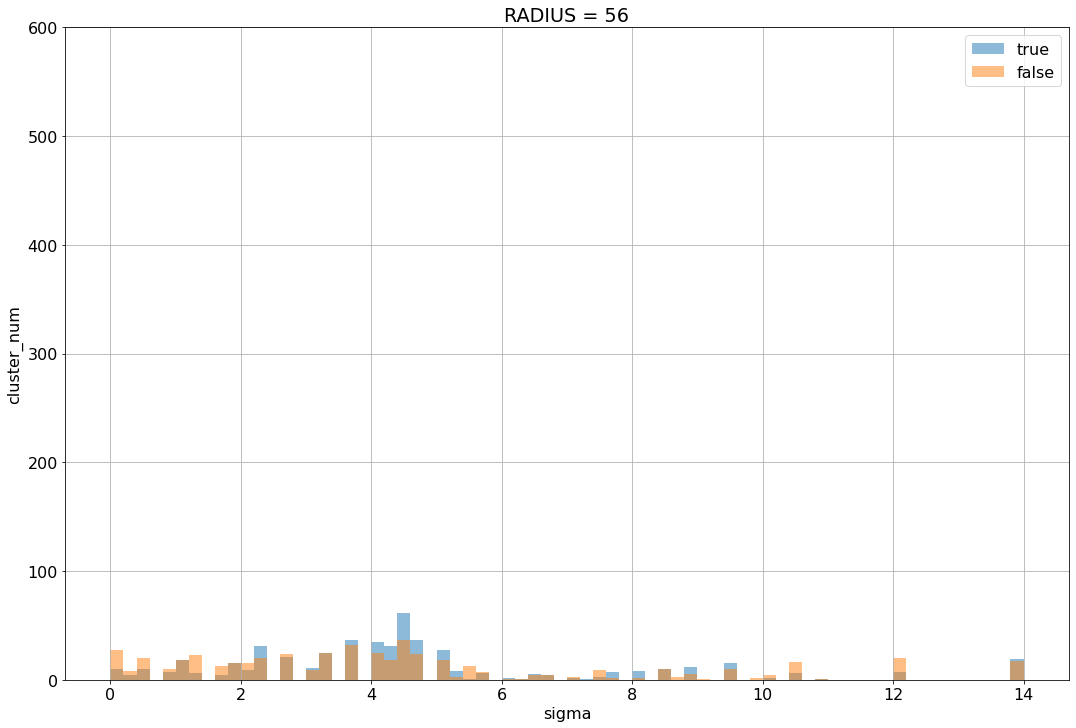

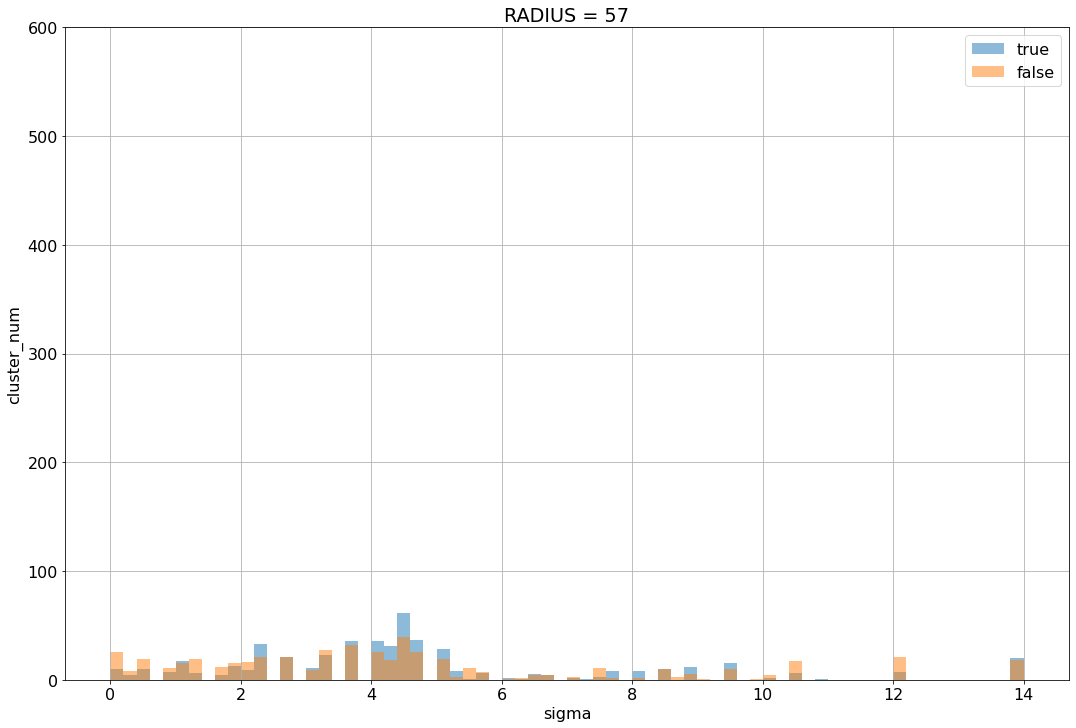

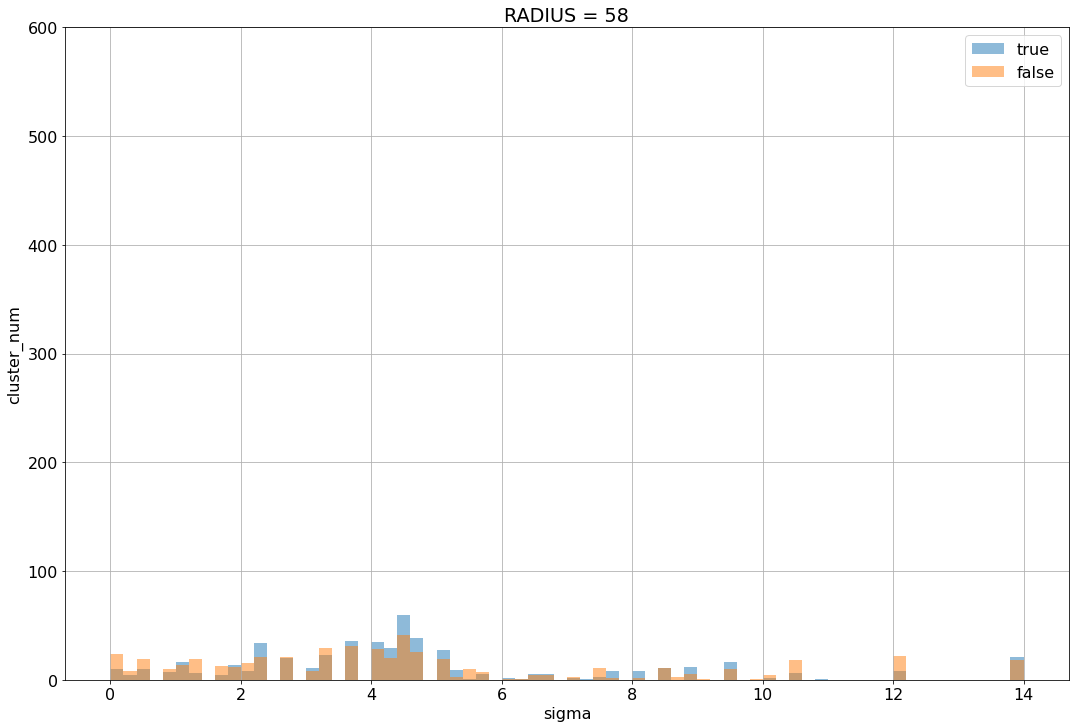

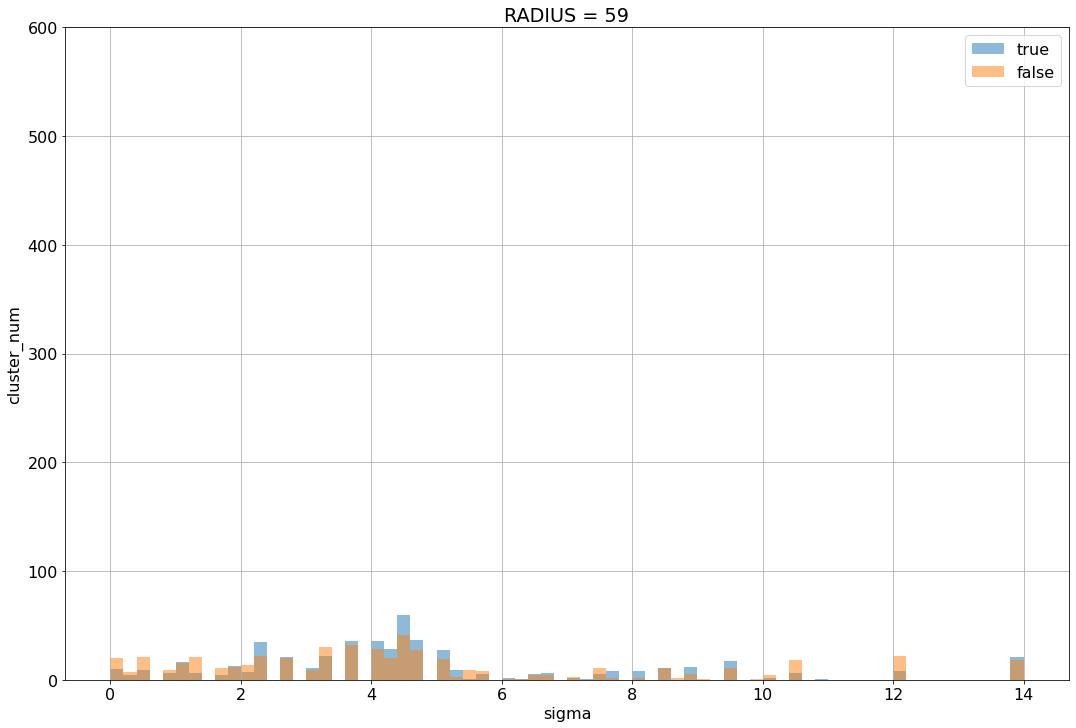

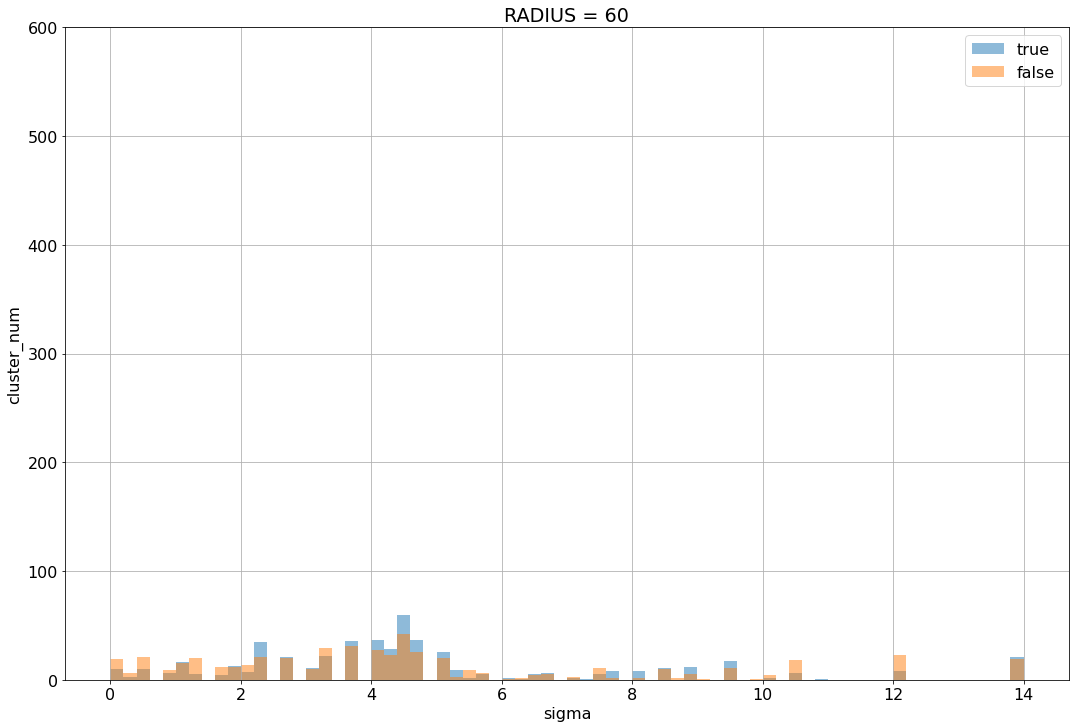

In [25]:
for i, rad in enumerate(rads):
    font = {'size': 16}
    plt.rc('font', **font)
    fig = plt.figure(figsize=(18, 12))
    plt.grid()
#     plt.xlim((0, 8))
    plt.ylim((0, 600))
    
    plt.hist(true_sigmas[:, i], density=False, bins=70, alpha=0.5, label='true', range=(0, 14))
    plt.hist(false_sigmas[:, i], density=False, bins=70, alpha=0.5, label='false', range=(0, 14))
    plt.xlabel('sigma')
    plt.ylabel('cluster_num')
    plt.legend()
    plt.title(f'RADIUS = {rad}')
#     plt.savefig(f'RADIUS = {rad}.jpg')

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [27]:
X = np.concatenate((true_dists, false_dists), axis=0)
Y = np.array([1] * DPS.clusters.shape[0] + [0] * DPS.clusters.shape[0])

In [69]:
sigma_scores = np.concatenate((true_sigmas, false_sigmas), axis=0)

In [77]:
sigmas_roc_aucs = []
for i in range(len(rads)):
    sigmas_roc_aucs.append(roc_auc_score(Y, sigma_scores[:, i]))

In [78]:
sigmas_roc_aucs

[0.6045529976499939,
 0.659373480199435,
 0.6928972642661706,
 0.7107079347047272,
 0.7315108720267596,
 0.7512965871080074,
 0.760898942311619,
 0.7702804043644033,
 0.7745998863978082,
 0.7691963573048808,
 0.7666050393338308,
 0.760871098637145,
 0.7594974773630926,
 0.7537059930724938,
 0.7456591711494982,
 0.7450169103916306,
 0.7394036256176656,
 0.7372819376227442,
 0.7352549181210346,
 0.7305586183597477,
 0.7202898712137242,
 0.7107784720133947,
 0.7097185561384164,
 0.6987425796607527,
 0.6960807243810352,
 0.6912637686970273,
 0.6845014682897672,
 0.6780064671574579,
 0.6723245013197902,
 0.6613819372514953,
 0.6532942779392711,
 0.6442543649600351,
 0.6372210527878943,
 0.6327493586673647,
 0.6301617531862445,
 0.6322388913020074,
 0.62755744150044,
 0.6232620906515791,
 0.6168896016869554,
 0.6106934559940006,
 0.6052825019212136,
 0.6018558737159426,
 0.5993258118287355,
 0.5893577763670316,
 0.5817787281751998,
 0.5761635871562698,
 0.5734330508128497,
 0.572826058709315

In [79]:
np.argmax(sigmas_roc_aucs)+1

9

In [80]:
sigmas_roc_aucs[np.argmax(sigmas_roc_aucs)]

0.7745998863978082

Text(0.5, 1.0, 'ROC_AUC (sigma_clf)')

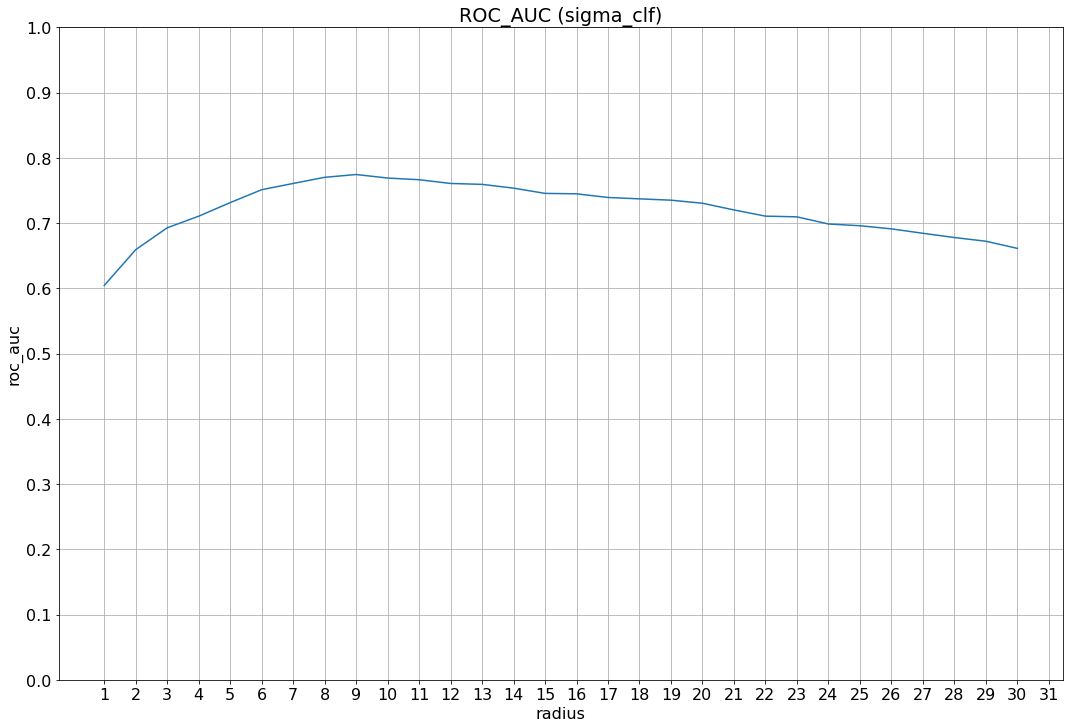

In [33]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))
plt.grid()
plt.xticks(rads)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim((0, 1))

plt.plot(rads[:30], sigmas_roc_aucs[:30])

    
plt.xlabel('radius')
plt.ylabel('roc_auc')
plt.title(f'ROC_AUC (sigma_clf)')
# plt.savefig(f'ROC_AUC (sigma_clf).jpg')

In [34]:
sigmas = np.array(sigmas)
linreg_coef_scores = []
for i in range(X.shape[0]):
    reg = LinearRegression(fit_intercept=False).fit(sigmas.reshape(-1, 1), X[i].reshape(-1, 1))
    linreg_coef_scores.append(reg.coef_[0][0])
linreg_coef_scores = np.array(linreg_coef_scores)

In [35]:
roc_auc_score(Y, -linreg_coef_scores)

0.4640983661331819

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, stratify=Y, test_size=0.33
)

In [37]:
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, Y_train)
logreg_scores = clf.predict_proba(X_test)[:,1].reshape(-1)

/home/svasilyev/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [38]:
roc_auc_score(Y_test, logreg_scores)

0.8013055895552835

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [40]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(len(sigmas), 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        out = F.sigmoid(x)
        return out

In [41]:
torch.manual_seed(0)
model = Net()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001)
number_of_epochs = 2000
for epoch in range(number_of_epochs):
    Y_pred = model(torch.Tensor(X_train))
    loss = criterion(Y_pred, torch.Tensor(Y_train).view(-1, 1))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (epoch+1)%200 == 0:
        Y_pred = model(torch.Tensor(X_test))
        test_loss = criterion(Y_pred, torch.Tensor(Y_test).view(-1, 1))
        print(f'epoch: {epoch+1}, train_loss={loss.item()}, test_loss={test_loss}')

/home/svasilyev/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch: 200, train_loss=46.45813751220703, test_loss=47.29087829589844
epoch: 400, train_loss=0.5706391334533691, test_loss=0.6158614754676819
epoch: 600, train_loss=0.5570790767669678, test_loss=0.6174455285072327
epoch: 800, train_loss=0.5272288918495178, test_loss=0.6032620668411255
epoch: 1000, train_loss=0.5147770047187805, test_loss=0.6036130785942078
epoch: 1200, train_loss=0.5038020610809326, test_loss=0.597588837146759
epoch: 1400, train_loss=0.4963846504688263, test_loss=0.5978975892066956
epoch: 1600, train_loss=0.4879592955112457, test_loss=0.5958421230316162
epoch: 1800, train_loss=0.4723997414112091, test_loss=0.5958239436149597
epoch: 2000, train_loss=0.4691334366798401, test_loss=0.6005001664161682


In [42]:
net_scores = model(torch.Tensor(X_test)).view(-1).detach().numpy()

In [43]:
roc_auc_score(Y_test, net_scores)

0.7951516387868897

In [44]:
clf = RandomForestClassifier(
    max_depth=4, 
    random_state=0,
    n_estimators=500,
    max_features='auto'
).fit(X_train, Y_train)
rf_scores = clf.predict_proba(X_test)[:,1].reshape(-1)

In [45]:
roc_auc_score(Y_test, rf_scores)

0.8953148374813

In [46]:
import pickle
with open('ACT_rf.pkl', 'wb') as f:
    pickle.dump(clf, f)

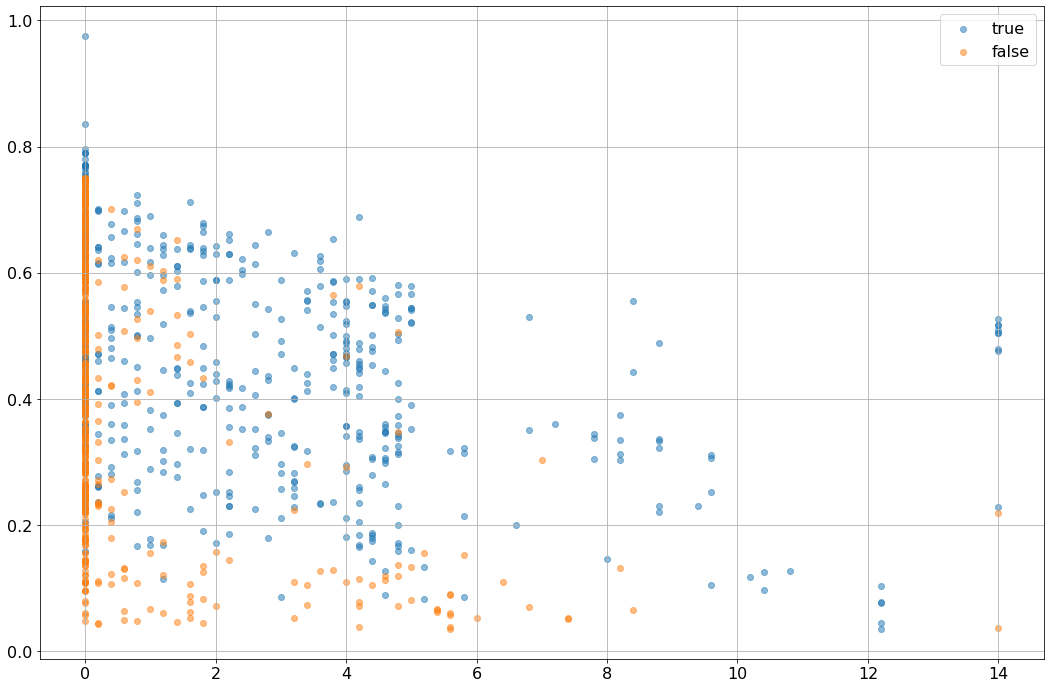

In [52]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))
plt.grid()

plt.scatter(true_sigmas[:,8], clusters['Z'], alpha=0.5, label='true')
plt.scatter(false_sigmas[:, 8], DPS.random_clusters[0]['Z'], alpha=0.5, label='false')

plt.legend()

<AxesSubplot:>

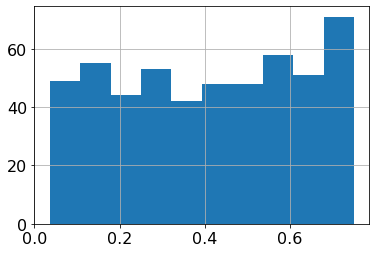

In [48]:
DPS.random_clusters[0]['Z'].hist()

<AxesSubplot:>

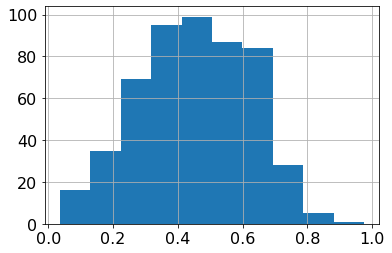

In [49]:
DPS.clusters['Z'].hist()

In [50]:
DPS.random_clusters[0]

,RA,DEC,Z,CX,CY,CZ,R
0,203.937346,17.568732,0.126453,-472.915431,-209.936166,163.824178,0
1,217.176647,10.889144,0.412134,-1285.164433,-974.667558,310.289289,0
2,208.230389,5.694111,0.136864,-513.668557,-275.777531,58.132299,0
3,203.624592,0.668558,0.262253,-996.261411,-435.765239,12.688887,0
4,193.977886,14.206652,0.484464,-1781.213613,-443.376295,464.696494,0
...,...,...,...,...,...,...,...
514,209.791727,19.274480,0.642605,-1970.699937,-1128.252643,794.093683,0
515,216.805753,14.386846,0.332309,-1049.246651,-785.101102,336.147951,0
516,176.572435,7.033649,0.126599,-538.291312,32.240293,66.533797,0
517,187.456212,5.130428,0.637826,-2361.172513,-309.018646,213.800872,0


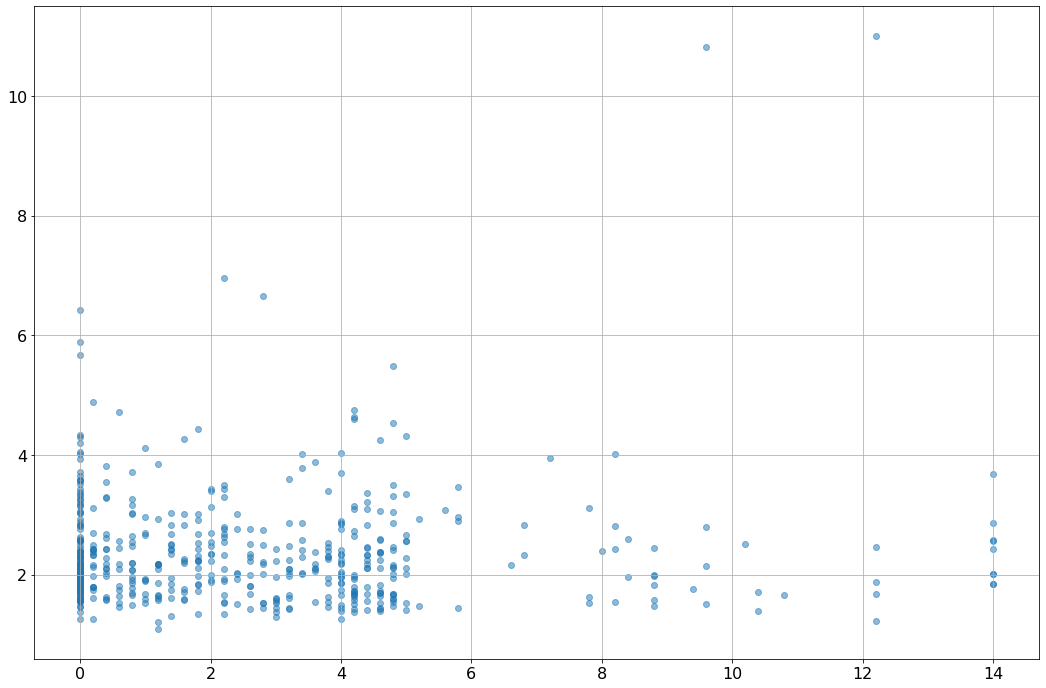

In [53]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))
plt.grid()

plt.scatter(true_sigmas[:,8], clusters['M'], alpha=0.5, label='true')

In [54]:
true_sigmas.shape

(519, 60)

In [111]:
near_true_cl = clusters['Z'] < 0.2

In [112]:
near_false_cl = DPS.random_clusters[0]['Z'] < 0.2

In [113]:
np.sum(near_true_cl), np.sum(near_false_cl)

(40, 112)

Text(0.5, 1.0, 'TRUE and FALSE clusters (cl_num=100)')

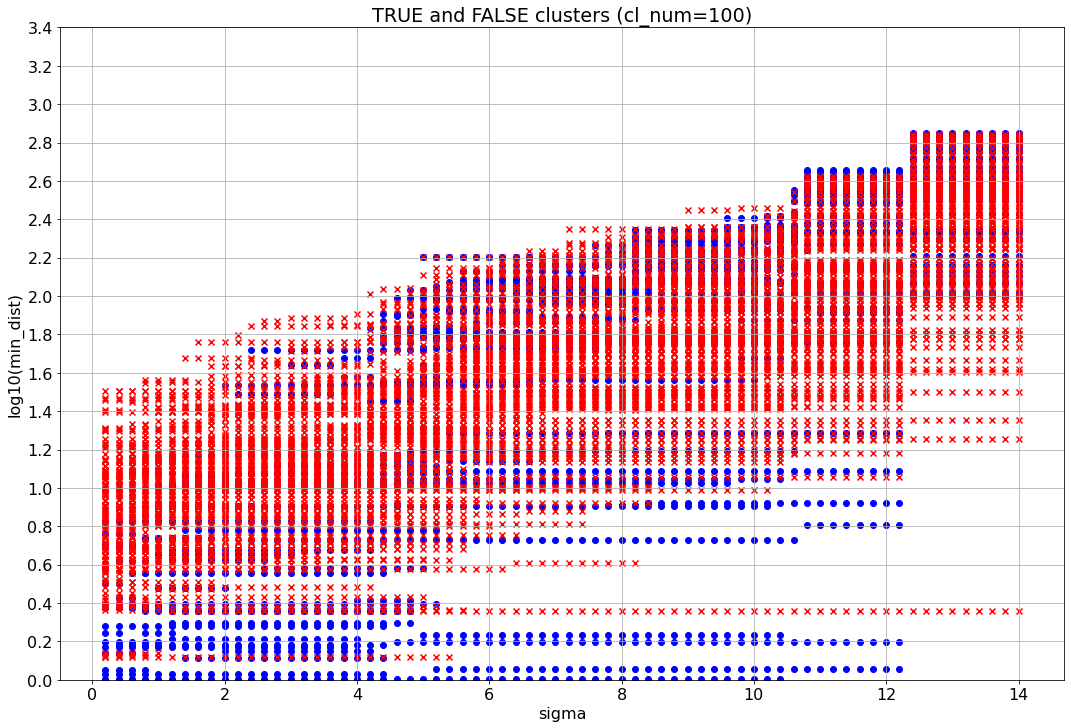

In [114]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))
plt.grid()
plt.yticks(np.arange(0, 3.6, 0.2))
plt.ylim((0, 3.4))

for e in true_dists[near_true_cl]:
    plt.scatter(sigmas, np.log10(e), c='b', marker='o')
    
for e in false_dists[near_false_cl]:
    plt.scatter(sigmas, np.log10(e), c ='r', marker='x')
    
plt.xlabel('sigma')
plt.ylabel('log10(min_dist)')
# plt.legend()
plt.title(f'TRUE and FALSE clusters (cl_num={cl_num})')
# plt.savefig(f'TRUE and FALSE clusters (cl_num={cl_num}).jpg')

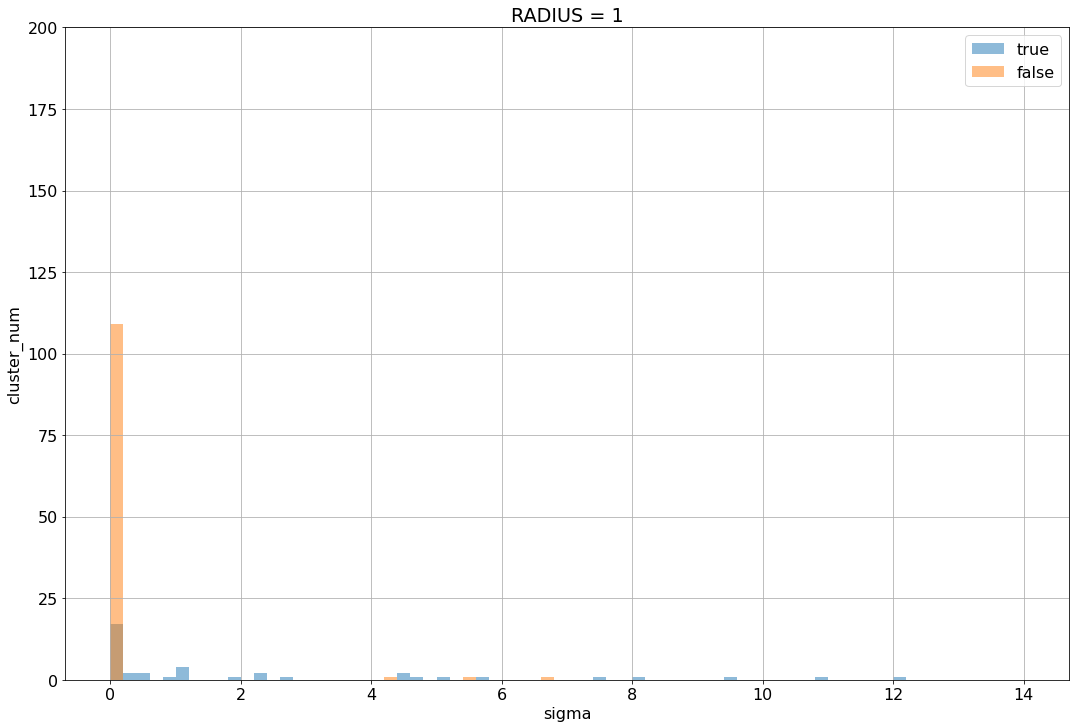

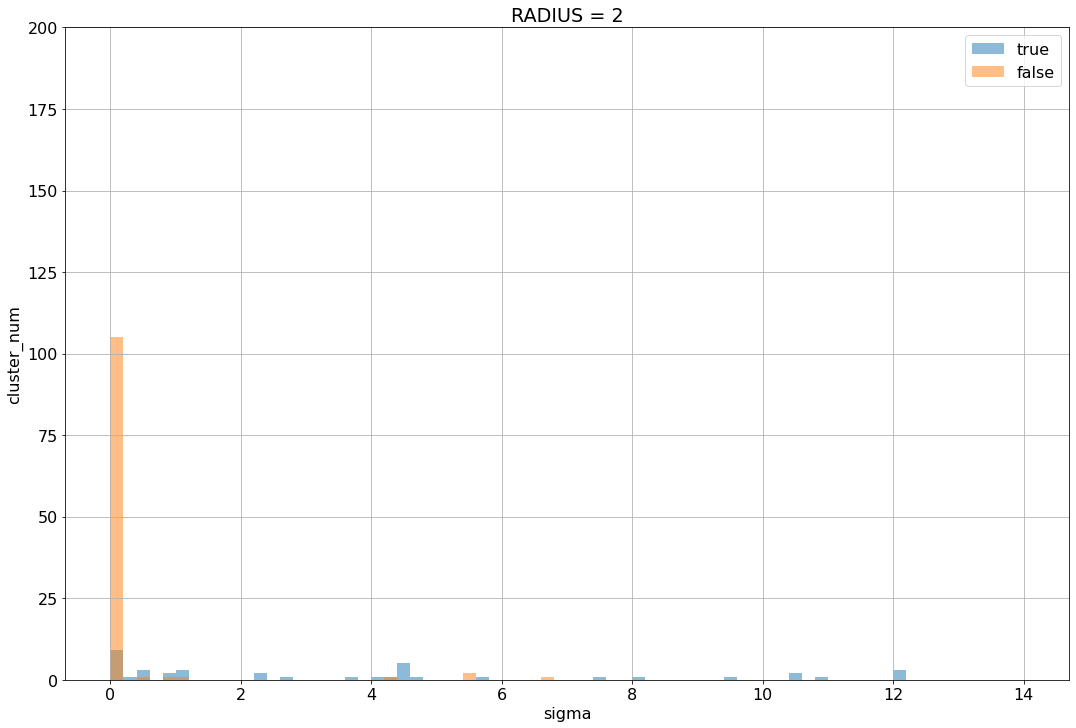

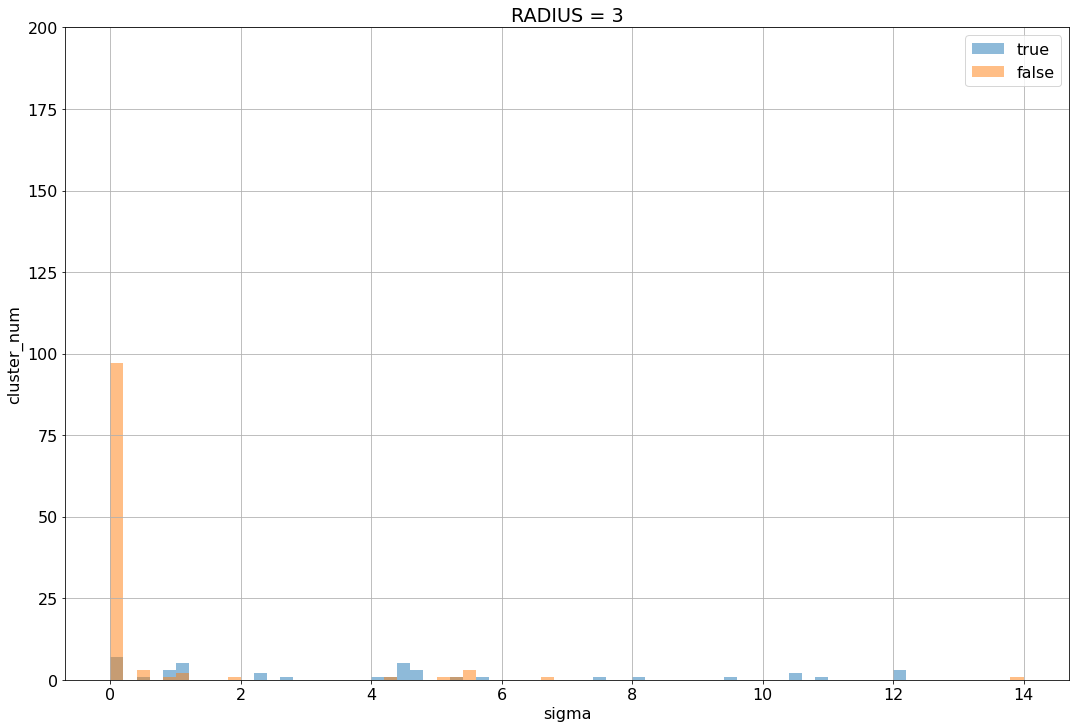

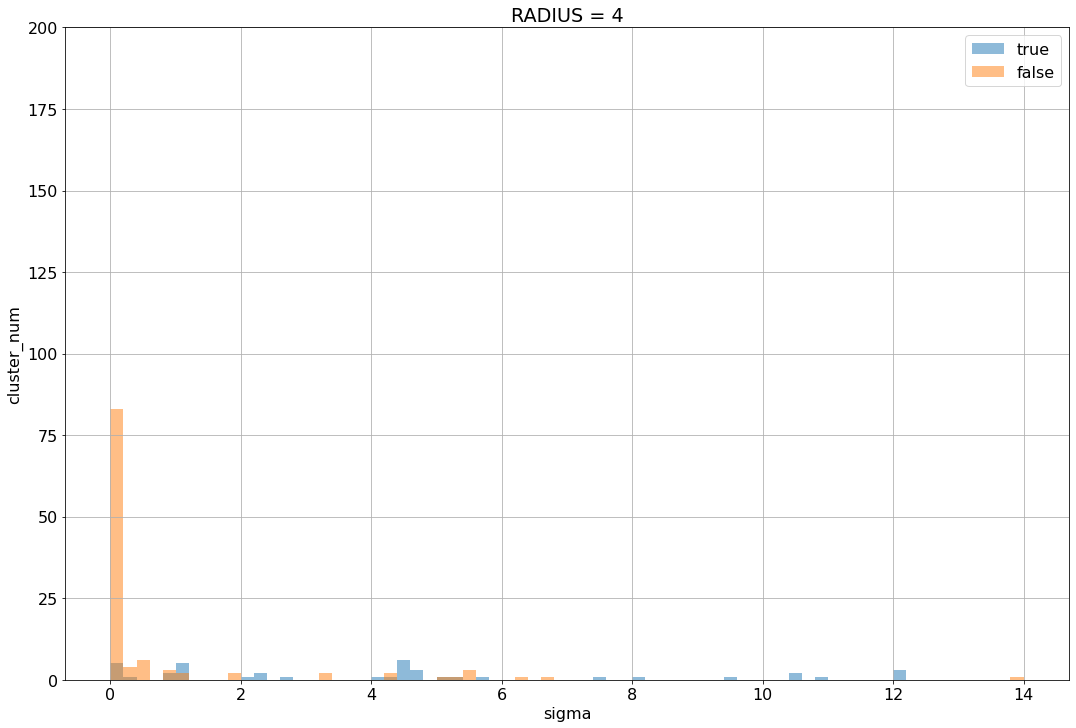

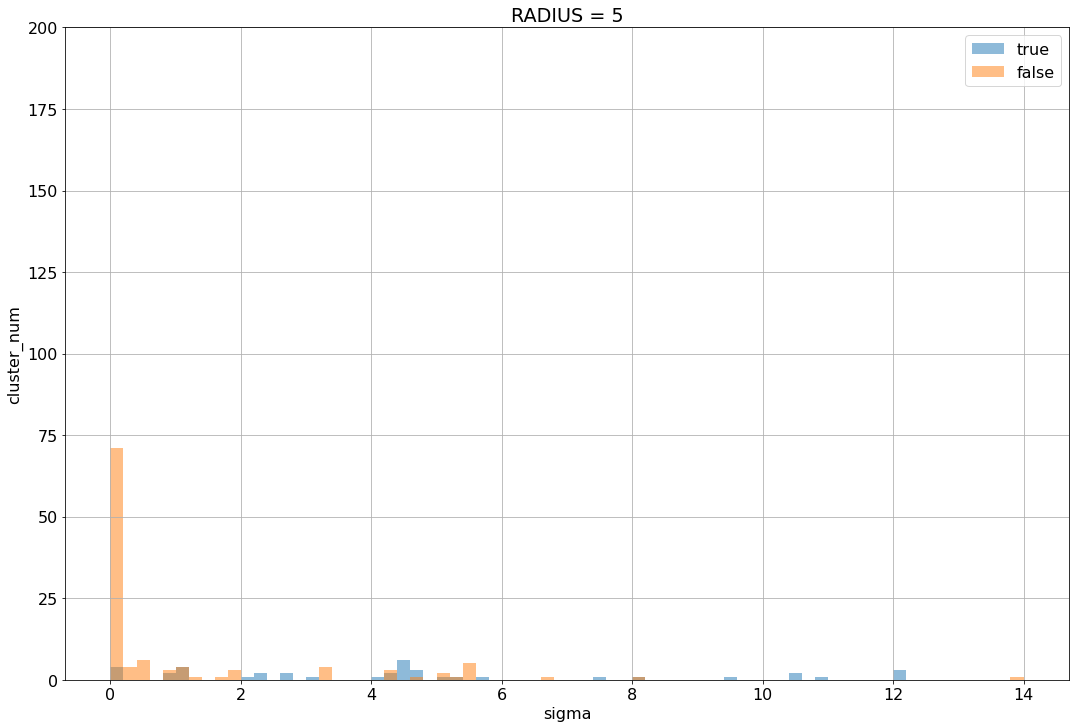

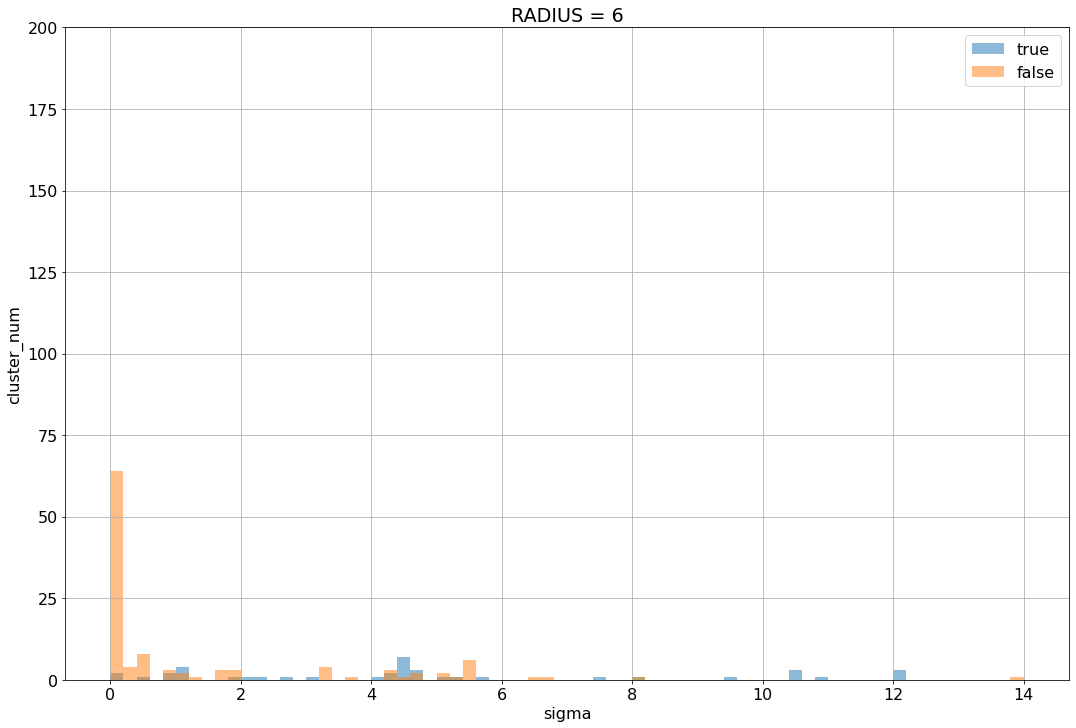

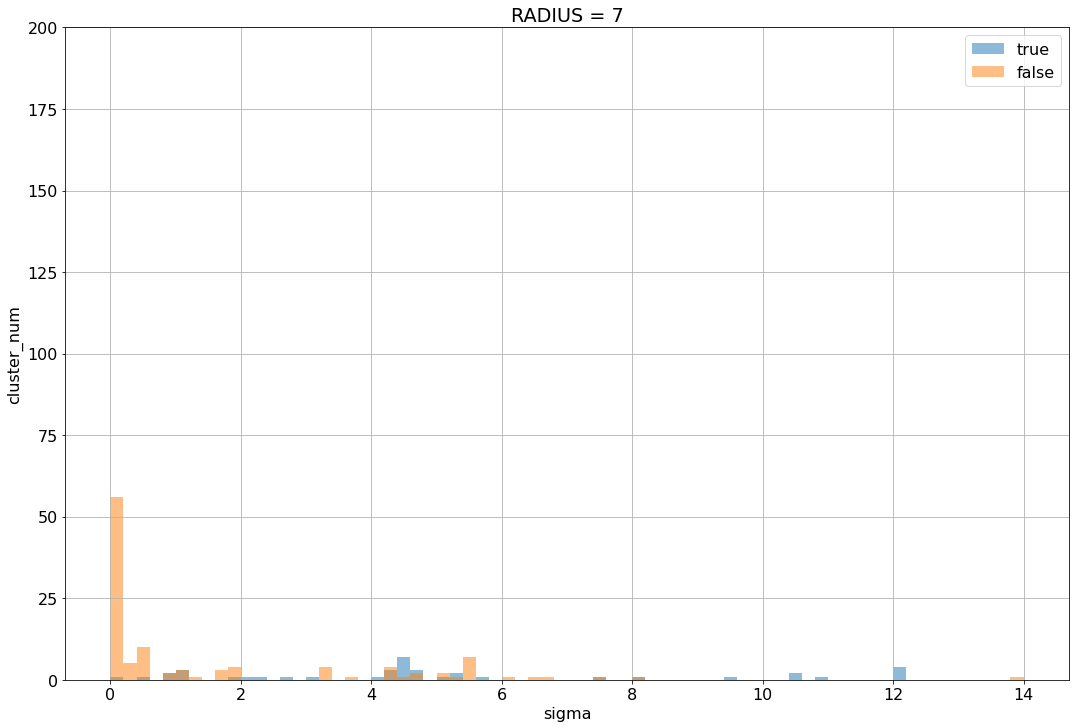

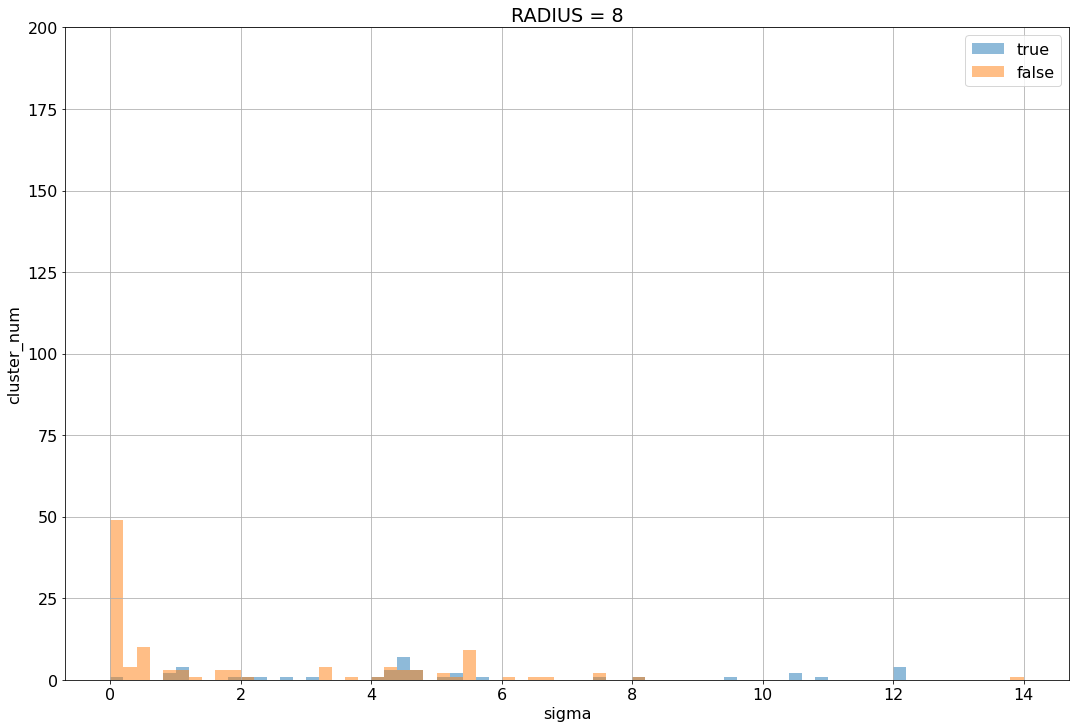

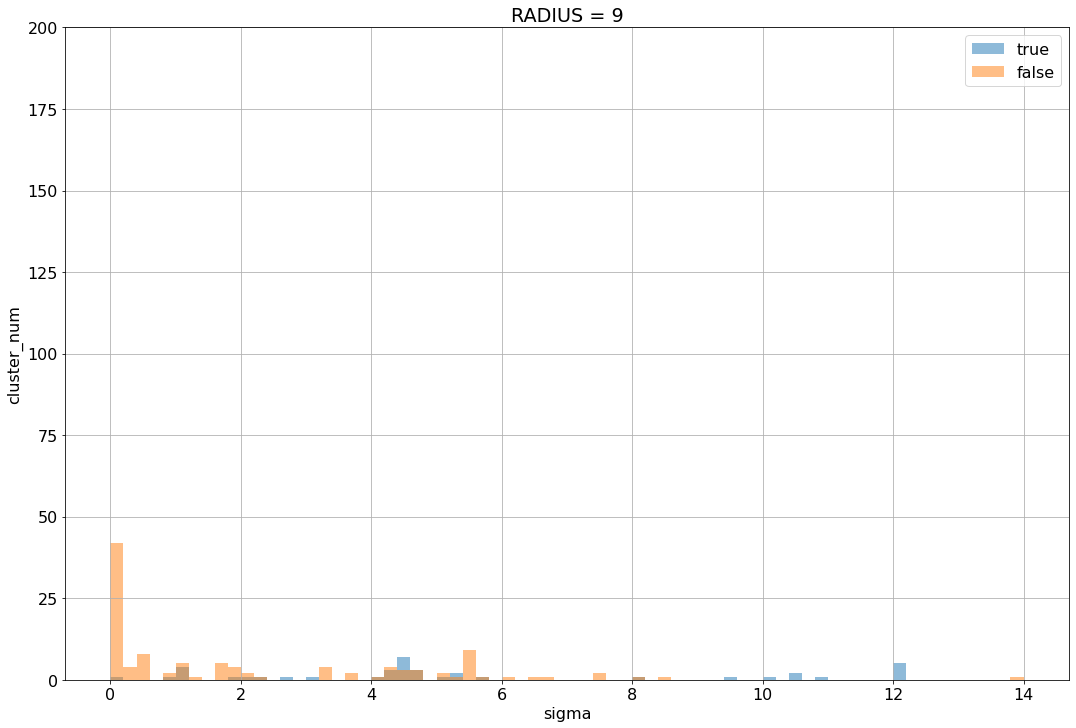

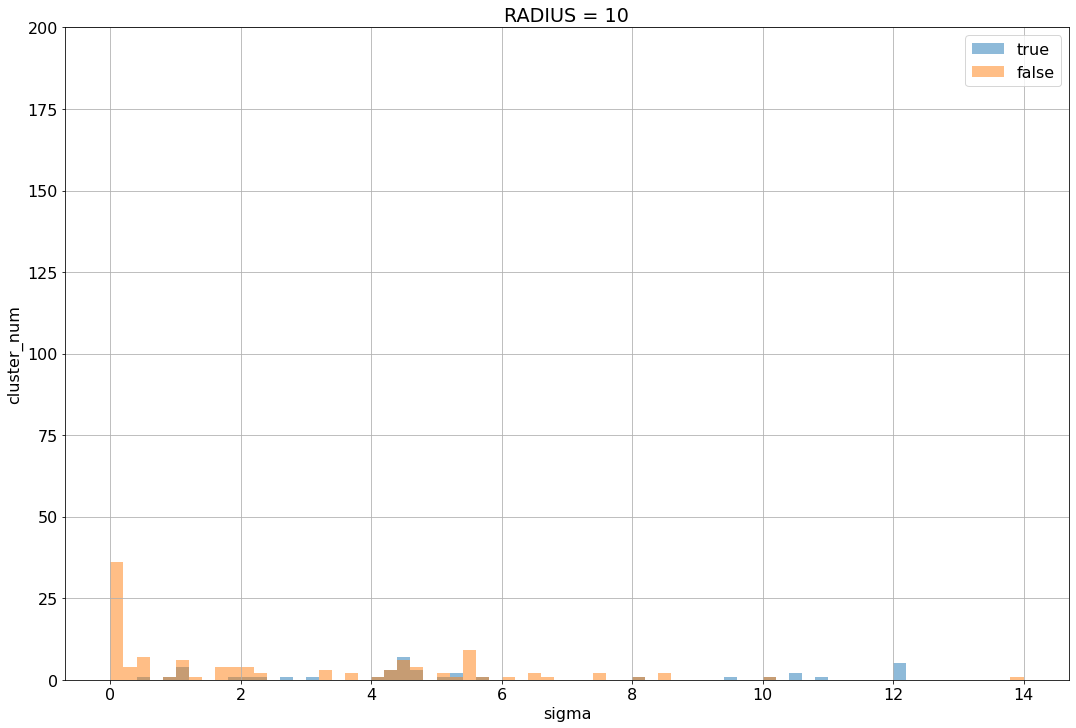

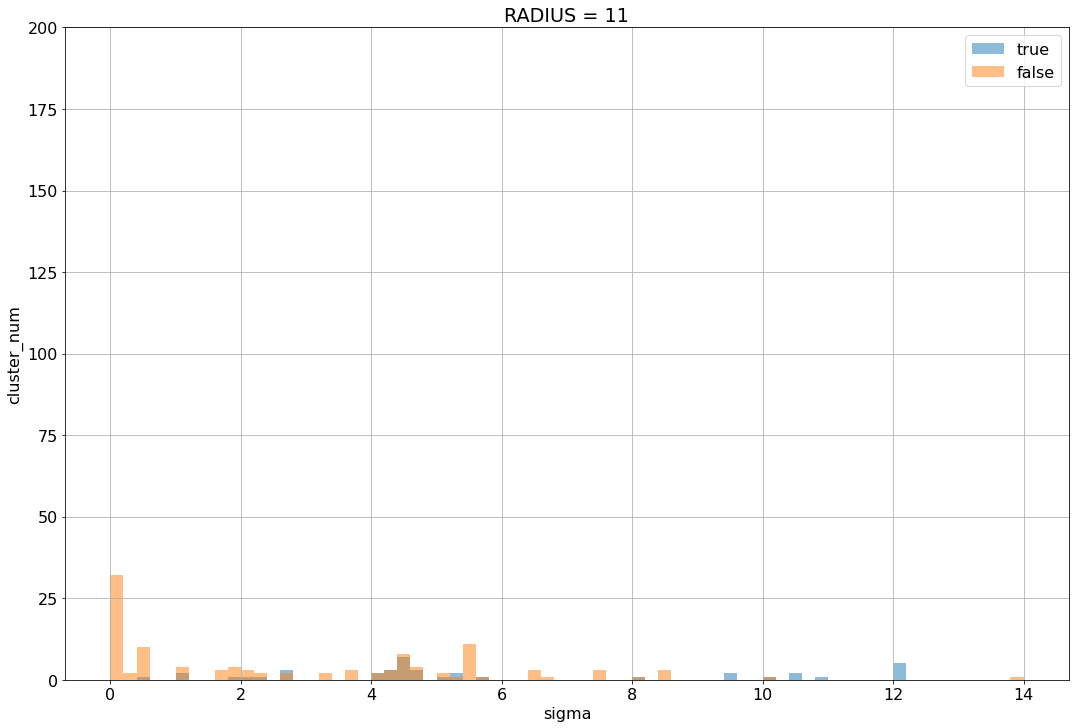

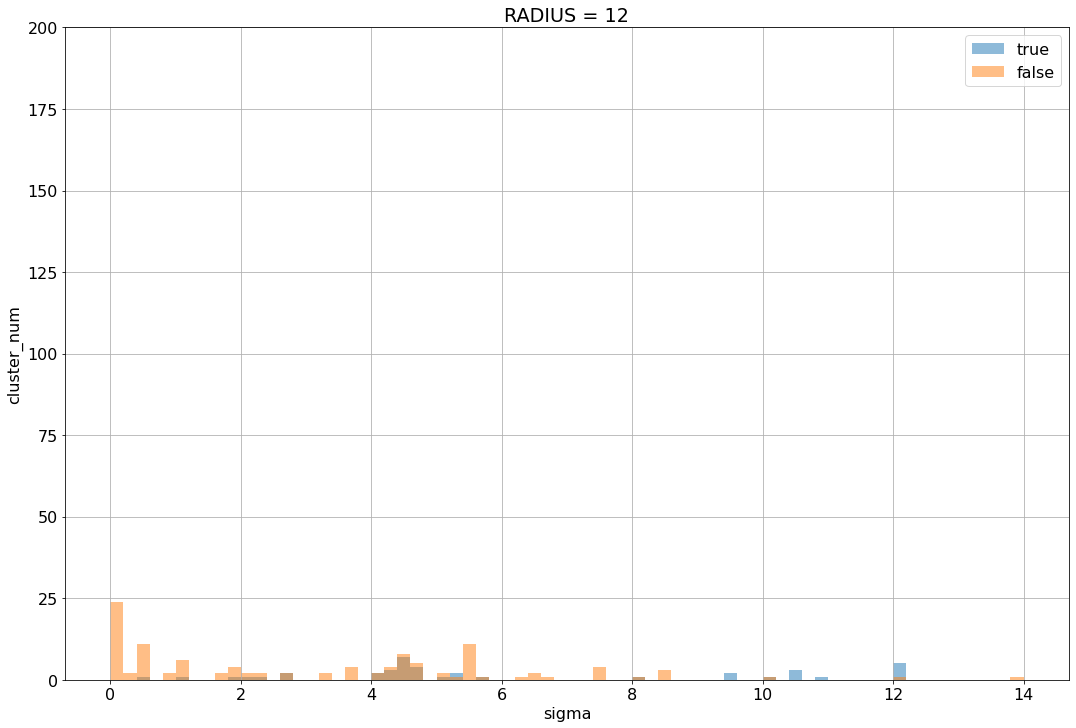

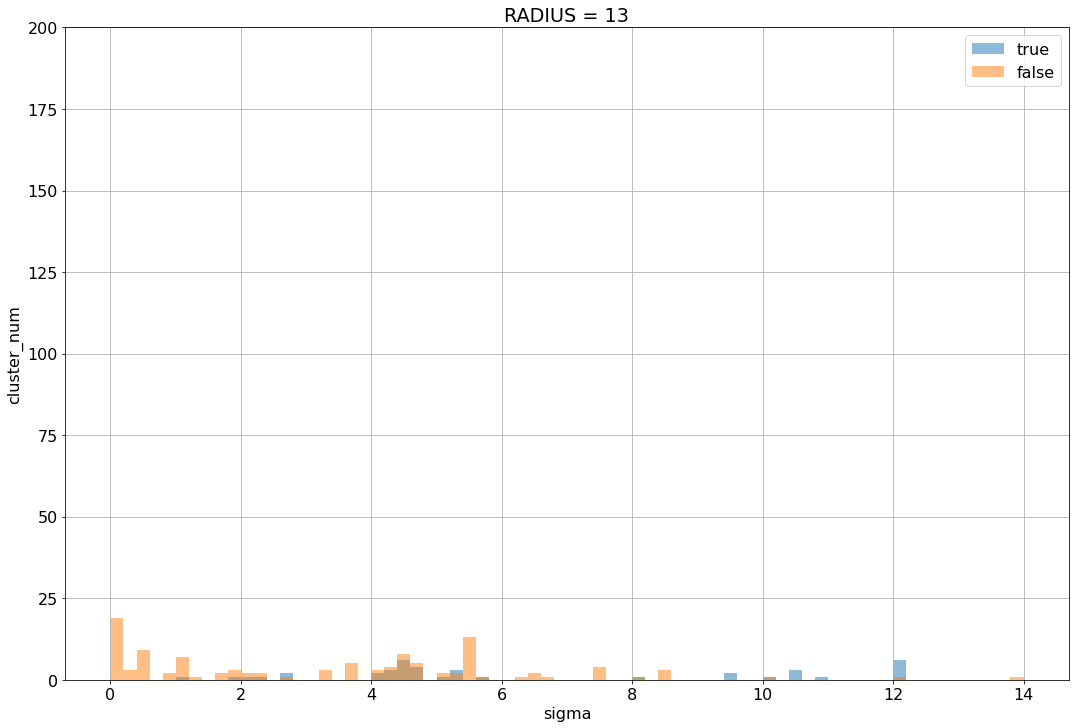

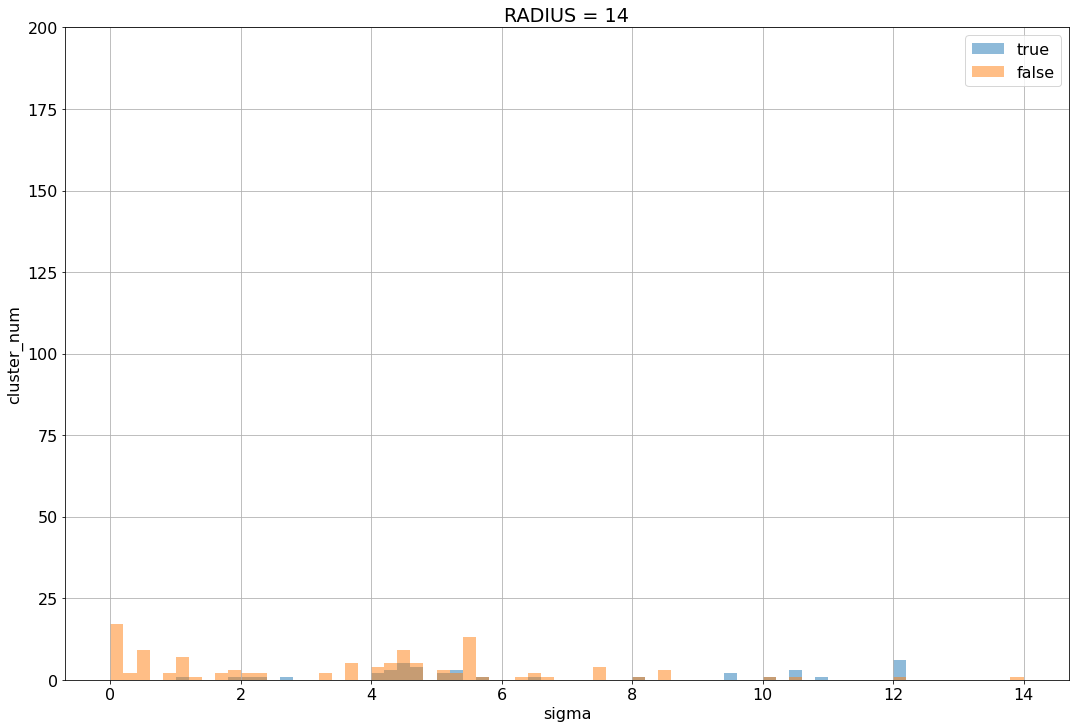

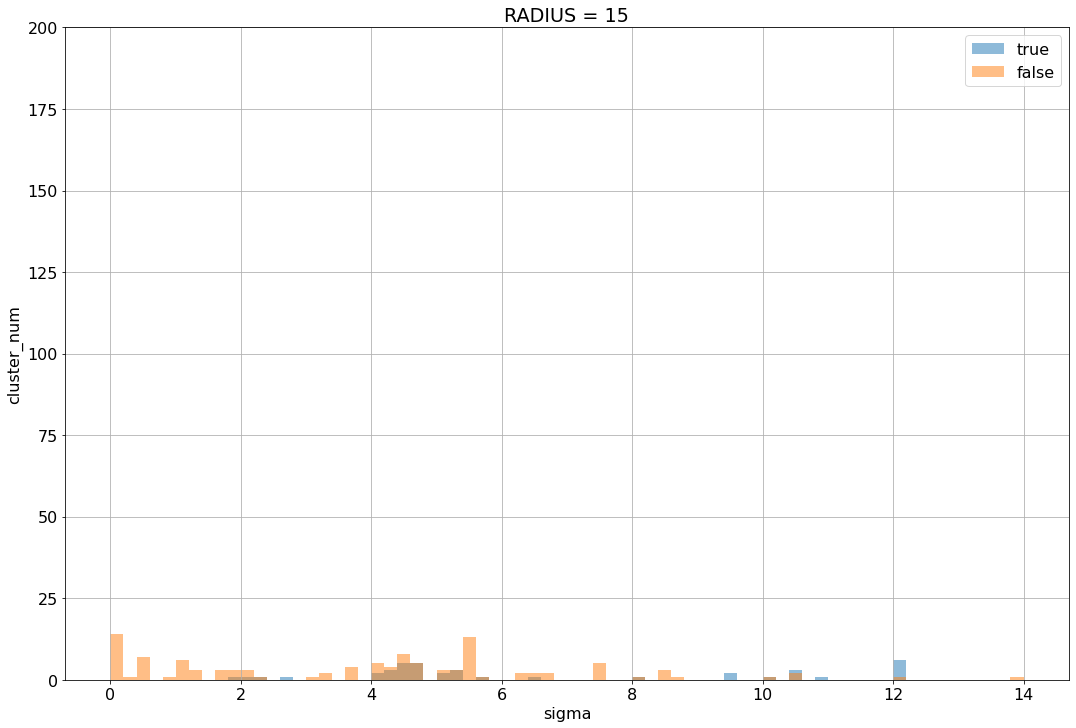

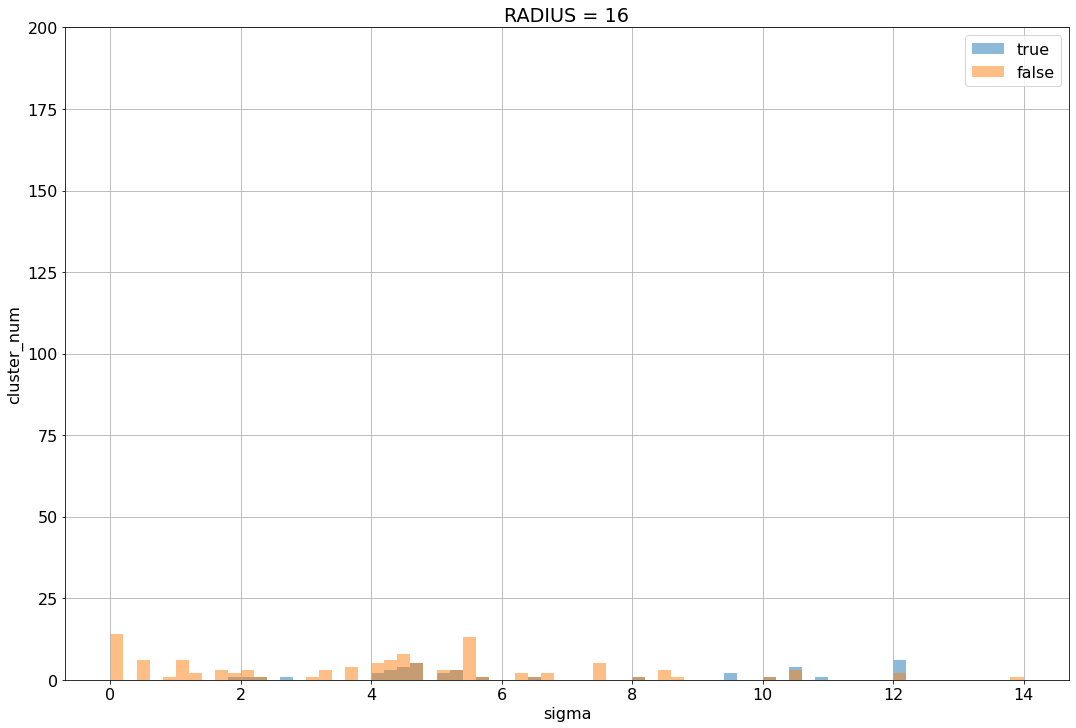

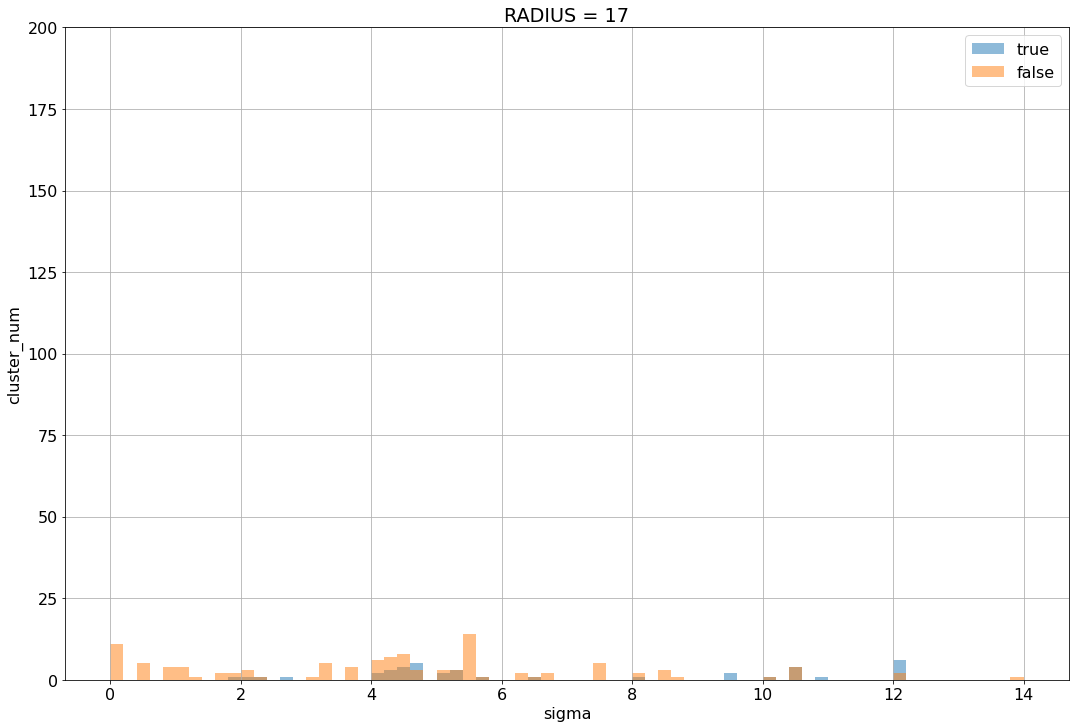

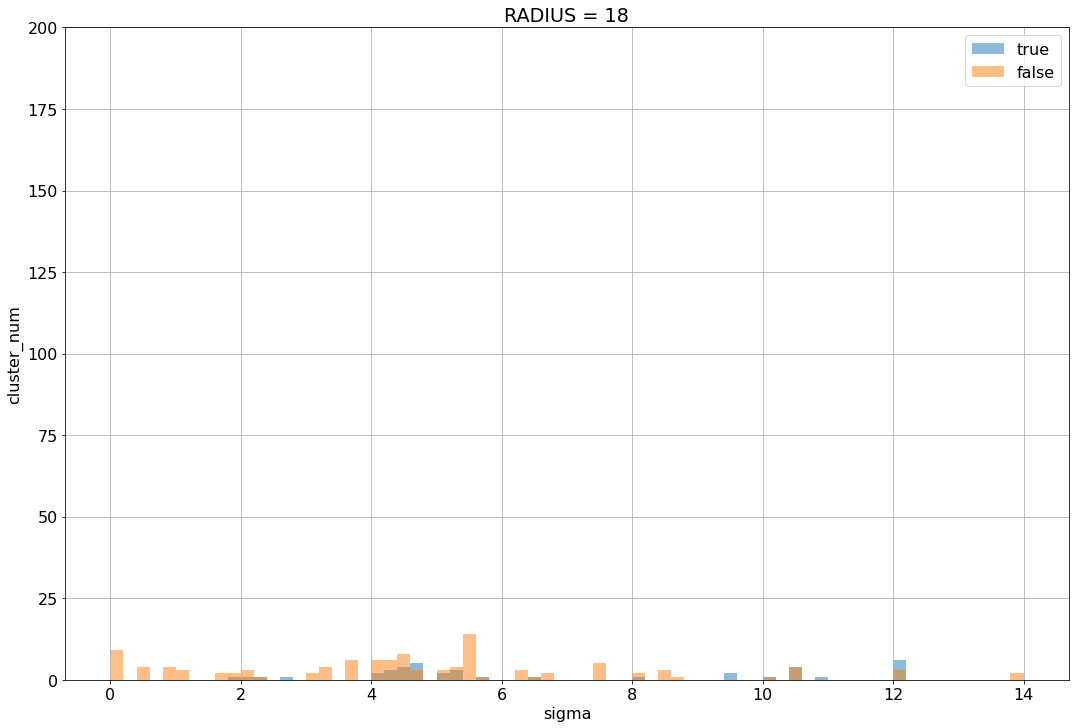

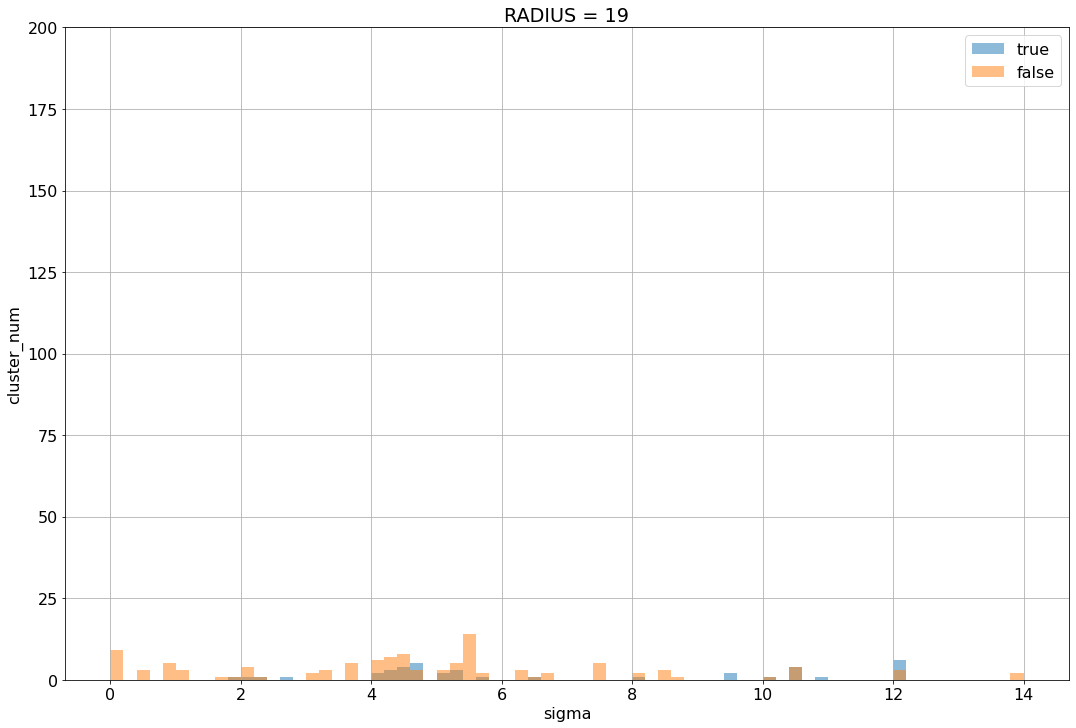

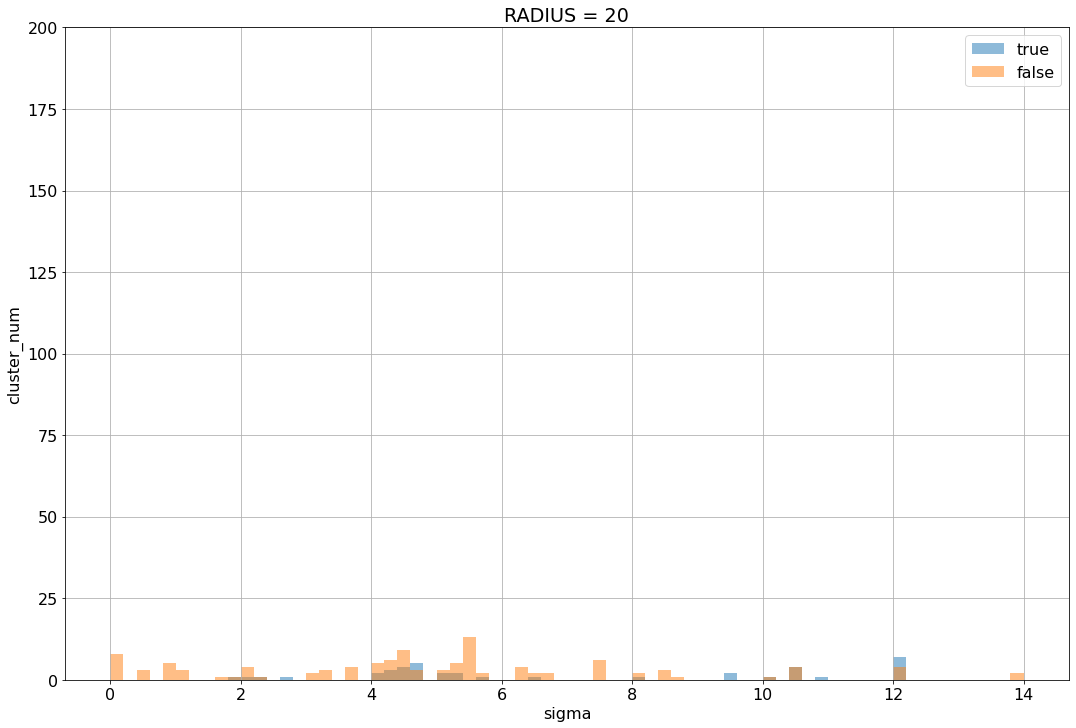

In [115]:
for i, rad in enumerate(rads[:20]):
    font = {'size': 16}
    plt.rc('font', **font)
    fig = plt.figure(figsize=(18, 12))
    plt.grid()
#     plt.xlim((0, 8))
    plt.ylim((0, 200))
    
    plt.hist(true_sigmas[near_true_cl, i], density=False, bins=70, alpha=0.5, label='true', range=(0, 14))
    plt.hist(false_sigmas[near_false_cl, i], density=False, bins=70, alpha=0.5, label='false', range=(0, 14))
    plt.xlabel('sigma')
    plt.ylabel('cluster_num')
    plt.legend()
    plt.title(f'RADIUS = {rad}')

In [116]:
X_01 = np.concatenate(
    (true_dists[near_true_cl], false_dists[near_false_cl]), axis=0
)
Y_01 = np.array(
    [1] * np.sum(near_true_cl) + [0] * np.sum(near_false_cl)
)

In [117]:
sigma_scores_01 = np.concatenate(
    (true_sigmas[near_true_cl], false_sigmas[near_false_cl]), axis=0
)

In [118]:
sigmas_roc_aucs_01 = []
for i in range(len(rads)):
    sigmas_roc_aucs_01.append(roc_auc_score(Y_01, sigma_scores_01[:, i]))

In [119]:
sigmas_roc_aucs_01

[0.7710937499999999,
 0.8600446428571429,
 0.8547991071428571,
 0.8545758928571429,
 0.8308035714285713,
 0.8308035714285713,
 0.8244419642857144,
 0.7880580357142857,
 0.7751116071428572,
 0.7441964285714285,
 0.73125,
 0.7273437500000001,
 0.7284598214285714,
 0.7262276785714284,
 0.703125,
 0.6994419642857144,
 0.6837053571428572,
 0.6566964285714285,
 0.6465401785714286,
 0.63828125,
 0.6225446428571428,
 0.6021205357142857,
 0.5909598214285714,
 0.5860491071428572,
 0.5713169642857143,
 0.5595982142857143,
 0.5430803571428572,
 0.5348214285714286,
 0.5358258928571429,
 0.5283482142857143,
 0.5128348214285714,
 0.4953125,
 0.48303571428571435,
 0.47790178571428577,
 0.48850446428571426,
 0.49029017857142854,
 0.50234375,
 0.5052455357142858,
 0.49084821428571423,
 0.48906249999999996,
 0.4636160714285714,
 0.45513392857142854,
 0.4517857142857143,
 0.4409598214285715,
 0.43604910714285716,
 0.4318080357142857,
 0.42566964285714287,
 0.4284598214285714,
 0.4252232142857142,
 0.41696

In [120]:
np.argmax(sigmas_roc_aucs_01)+1

2

In [121]:
max(sigmas_roc_aucs_01)

0.8600446428571429

Text(0.5, 1.0, 'ROC_AUC (sigma_clf)')

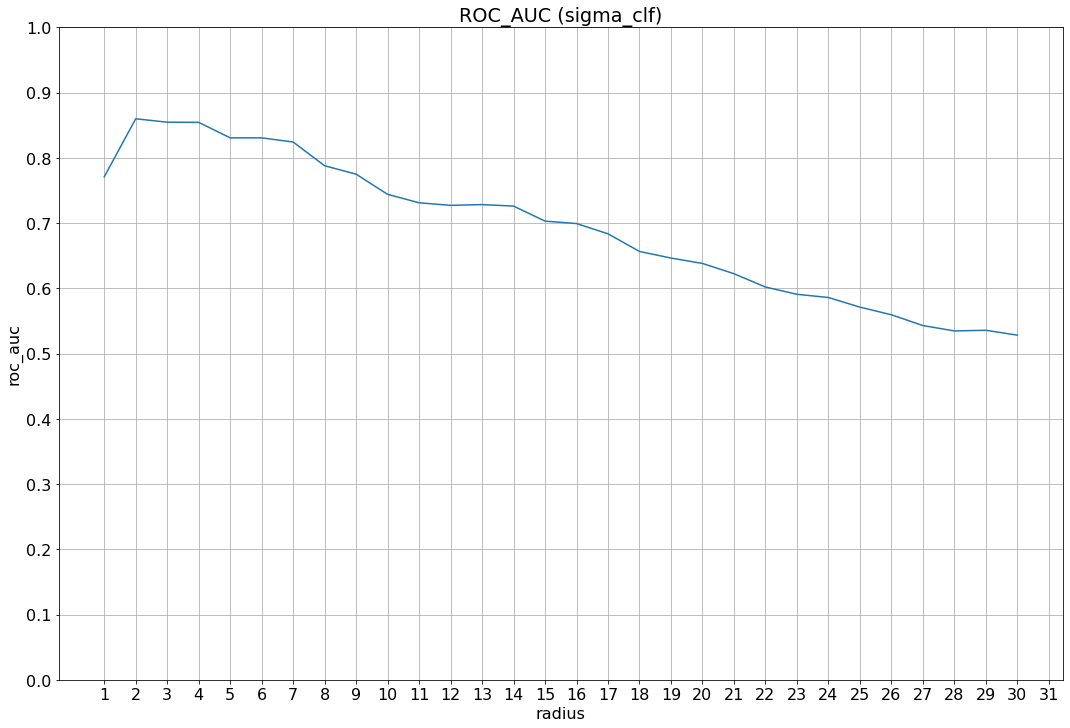

In [122]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))
plt.grid()
plt.xticks(rads)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim((0, 1))

plt.plot(rads[:30], sigmas_roc_aucs_01[:30])

    
plt.xlabel('radius')
plt.ylabel('roc_auc')
plt.title(f'ROC_AUC (sigma_clf)')